<!-- <div style="background-image: linear-gradient(rgba(255, 255, 255, 0.5), rgba(255, 255, 255, 0.5)), url('assets/paper.png')"> -->

## Converting PDF documents to Markdown with Google Gemini

<img src="assets/is_all_you_need.png" width="400" style="display: inline" />
<img src="assets/lowry.png" width="300" style="display: inline" />


### The problem

Unlike Madkdown or HTML, the data in a PDF page does not always come in the natural order. 
It's more like a canvas, with a list of elements like:
- `("World", font, location, transforms, ...)`
- `("Hello", font, location, transforms, ...)`
- `([Image], location, transforms, ...)`

that are placed at the correct location during rendering. It's generally not possible to reliably extract text  
in the natural order, and it gets especially messy with formulas:

![Attention](assets/attention.png)
```
In practice, we compute the attention function on a set of queries simultaneously, packed together | {...}
into a matrix | {...}
 Q | {...}
. The keys and values are also packed together into matrices | {...}
 K | {...}
 and | {...}
 V | {...}
 . We compute | {...}
the matrix of outputs as: | {...}
Attention( | {...}
Q, K, V | {...}
 ) = softmax( | {...}
QK | {...}
T | {...}
√ | {...}
d | {...}
k | {...}
) | {...}
V | {...}
(1) | {...}
```

On top of this, many older PDFs are scanned paper documents, and contain poorly  
recognized text, no text at all, full-page images instead of text, or images of page fragments.

Especially for a scanned PDF, we need to use AI to correctly extract the text  
and image from the document.

### Procedure

- Extract text and image from the document
- 🤖 Ask Gemini if the images look good.
    - If the images look good, we don't need to do the extra extraction step.
    - If they don't look good:
        - 🤖 Use Gemini to find bounding boxes for all images in the page.
        - Extract images from the bounding boxes.
 - 🤖 Give the page image, extracted text, and extracted images to Gemini, and generate markdown with references to images.
- Combine the markdown for all pages into a single document.
- 🤖 Pass the full document to Gemini and ask it to brush up the formatting to make it consistent across pages.
    - This step requires multi-step generation and context caching.
- Save the resulting markdown and images.

### Long context
During the second pass, we need to pass the whole document (text only) through Gemini Flash again, to fix small conversation errors and inconsistencies. We break the 100K token barrier at around 60-80 pages for a typical research paper, depending on the text density. 

### Caching

During the second pass, the input text is cached, as multiple calls to the model are required in order to re-generate the complete document.


### UI
There us a UI at the end of the notebok. Run the notebook (with `RUN_DEV_CELLS=False` for speed) and use it to convert your PDFs:

<img src="assets/ui.png" width="400" />

### API key
Set `GEMINI_API_KEY="your very secret key"` in the environment

### Findings

Durig this fun projects I found:
- Gemini works best with simple and concise tasks. Initially I tried to combine multiple tasks into one step, and the model was struggling.
- Gemini is able to find figures/plots/images in a PDF page, but it's not 100% reliable on its own.
- Gemini is excellent at converting between plain text and different text-based formats.

#### 🚩🥽 Recitation error
Gemini will fail with finish reason: `RECITATION` that triggers when the model is generating large chunks of  
material from some Google's database, regardless of license. This of couse makes using Gemini for format  
conversion challenging, as the generated text will often match large chunks of known material.

**GOOGLE: Pretty please, allow recitation if the recited material is also fully/largely present in the models input!**

Luckily, this mechanism can be fooled easily. I ask the model to insert `[<end of paragraph>]` after every paragraph, and cut them out later. This seems to be enough to avoid this error.


#### 🚩:🇰 Broken progress bars

It looks like TQDM is fully/partially broken on Kaggle at the moment.
Some functions in this notebook use it to show a progress bars, and `Loading widget...` is shown instead.
If you want to run the notebook to use the UI at the end, it might be better to use Colab or plain Jupyter.

Ready to run code is available at https://github.com/xl0/gemini-pdf-converter

---

### There are two ways to run this notebook
#### `RUN_DEV_CELLS=True` - will test the functions as I did during development, this is rather slow. Enable it to follow the inner works.
#### `RUN_DEV_CELLS=False` - runs vert fast and you can use the UI at the end of the notebook to convert your PDFs into markdown!

### `RUN_SUPER_LONG_CONTEXT` - This will run the very long ( > 100K) token demonstration, and takes a long time.

In [1]:
RUN_DEV_CELLS=True

# There is an example that demonstrates the use of long context. It takes a particularly long time to run.
# Keep this one as False unless you are sure.
RUN_SUPER_LONG_CONTEXT=False

# Gemini Flash is good for most sub-tasks, while other require a mode capable Gemini Pro.

## The 2 model names are gemini-1.5-flash-002 and gemini-1.5-pro-002
## The numeric version is required for the cache, because cache can not be shared between sub-versions of the model.

IMAGE_CHECK_MODEL="gemini-1.5-pro-002"
IMAGE_EXTRACTION_MODEL="gemini-1.5-pro-002"
PAGE_TO_MARKDOWN_MODEL="gemini-1.5-pro-002"
SECOND_PASS_MODEL="gemini-1.5-flash-002" # Use flash for the second pass - the task is simple.

In [2]:
import os

IN_KAGGLE=False
if "KAGGLE_URL_BASE" in os.environ: IN_KAGGLE=True

if IN_KAGGLE:
    !pip install -U pymupdf -q
    # Copy over the files and image assets.
    !cp -a /kaggle/input/* .
    
    
    # Display images inline (default) to oveeride Kaggle styling.
    
    from IPython.display import display, Markdown, HTML
    
    style="""
    <style>
    .jp-RenderedHTMLCommon > img {
        display: inline!important;
    }
    </style>
    """
    display(HTML(style))
else:
    !pip install -qU pymupdf fastprogress ipywidgets google-generativeai

In [3]:
if IN_KAGGLE:
    from kaggle_secrets import UserSecretsClient
    api_key=UserSecretsClient().get_secret("GEMINI_API_KEY")
else:    
    from dotenv import load_dotenv
    load_dotenv()
    api_key = os.environ["GEMINI_API_KEY"]

In [4]:
import io
import re

import fitz
from PIL import Image
import os
import shutil

# from tqdm.auto import tqdm
from fastprogress.fastprogress import master_bar, progress_bar # tqdm is broken on Kaggle, but fastprogress works

import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold, RequestOptions
from google.generativeai.types.content_types import to_part
from google.generativeai.protos import Candidate
from google.generativeai import caching
from google.api_core import retry

genai.configure(api_key=api_key)

import datetime

from typing import Any

from time import sleep
from dataclasses import dataclass, field
import random
import string
from IPython.display import Markdown
from pathlib import Path
import warnings

import json
from typing_extensions import TypedDict

In [5]:
# Gemini is a bit trigger-happy on the filters, and some research papers might get flagged.
SAFETY_SETTINGS = {
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
}


# We have 2 types of retries, as the Gemini API has proven to be flaky.

# One retry strategy internal to the Gemini SDK for when the request returns with a failure
def retry_predicate(exception):
    print(f"Retry on exception {exception}")
    sleep(5)
    return True

# Gemini fails quite often. Retry on failures.
request_options=RequestOptions(retry=retry.Retry(predicate=retry_predicate, initial=5, multiplier=2, maximum=5*60, timeout=20*60))

# Sometimes the request will finish successfully, but the response will be empty (no candidates).
# In this case we will also retry the request with exponential backoff.

MAX_RETRIES=5

# Gemini has another annoying feature - it detects when the genreatio is reciting "cipyrighted content",
# which you'd expect would happen all the time when converting a PDF to markdown.

# Surprisingly, it only triggers infrequently and rather randomly, even with temperature=0,
# and does not trigger if I retry the exact same request.

# I also noticed that it's often enough to retry the offending request, even with temperature=0, top_k=1, so
# we will also retry those, in case some RECITATION sneaks through.

# GOOGLE: Please fix your stuff. :/

In [6]:
@dataclass
class PDFImage:
    image: Image.Image
    name: str
    bbox: list[int] = field(default_factory=list)  # For images we extract later, keep the bbox.
    export: bool = False                           # Export images will be saved as files.

@dataclass
class PDFPage:
    page_num: int
    extracted_text: str;
    page_image: Image.Image
    extracted_images: list[PDFImage];

    # Used to keep track of intermediate steps for debugging.
    extracted_images_analyzed: Any = field(default_factory=dict);
    images_proposed: list[Any] = field(default_factory=list);

    markdown: str = "";

@dataclass
class PDFDocument:
    pages: list[PDFPage];
    markdown: str= "";

In [7]:
# For the demo in the description.
# pdf = fitz.open("AIAYN.pdf")

# texts = []
# for block in pdf[3].get_text("dict")["blocks"]:
#     if (block["type"] == 0):
#         for line in block["lines"]:
#             for span in line["spans"]:
#                 print(span["text"] + " | {...}", )

### Use PyMuPDF to extract text and images from a PDF. No AI yet. :)

In [8]:
def extract_pdf_content(pdf_path):
    pdf = fitz.open(pdf_path)

    pages: list[PDFPage] = []
    num_images = 0

    pbar = progress_bar(pdf)
    pbar.prefix = "Converting PDF"
                    
    for page_num, pdf_page in enumerate(pbar):

        pbar.comment = f"Converting PDF page {page_num}/{len(pdf)}"

                                                     # desc="Extracting PDF content", unit="page")):
        extracted_images: list[PDFImage] = []

        # Get images
        image_list = pdf_page.get_images()
        for img in image_list:
            xref = img[0]
            base_image = pdf.extract_image(xref)

            extracted_images.append(PDFImage(
                image=Image.open(io.BytesIO(base_image["image"])),
                name=f"image_{num_images}.png"

            ))
            num_images += 1

        pages.append(PDFPage(
            page_image=Image.open(io.BytesIO(pdf_page.get_pixmap(dpi=300, annots=False).tobytes())),
            extracted_text=pdf_page.get_text(),
            extracted_images=extracted_images,
            page_num=page_num
        ))
        
    return PDFDocument(pages=pages)

### Let's try with a well-formatted PDF

In [9]:
if RUN_DEV_CELLS:
    aiayn = extract_pdf_content("AIAYN.pdf")

In [10]:
def show_pdf_page(pdf_page: PDFPage):
    display(pdf_page.page_image.resize((350, 500)))
    for image in pdf_page.extracted_images:
        img = image.image
        width, height = img.size
        aspect = width / height
        if width > height:
            new_width = 200
            new_height = int(200 / aspect)
        else:
            new_height = 200
            new_width = int(200 * aspect)
        display(img.resize((new_width, new_height)))
    print(pdf_page.extracted_text)

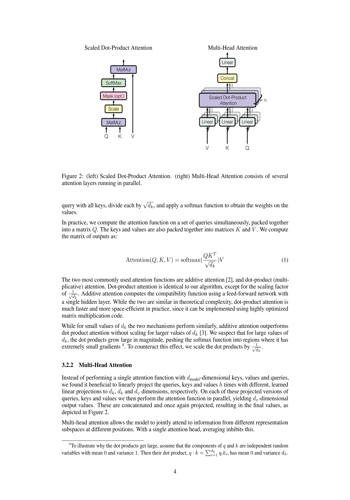

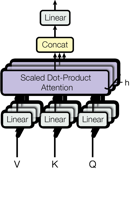

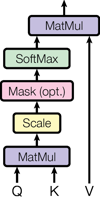

Scaled Dot-Product Attention
Multi-Head Attention
Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several
attention layers running in parallel.
query with all keys, divide each by √dk, and apply a softmax function to obtain the weights on the
values.
In practice, we compute the attention function on a set of queries simultaneously, packed together
into a matrix Q. The keys and values are also packed together into matrices K and V . We compute
the matrix of outputs as:
Attention(Q, K, V ) = softmax(QKT
√dk
)V
(1)
The two most commonly used attention functions are additive attention [2], and dot-product (multi-
plicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor
of
1
√dk . Additive attention computes the compatibility function using a feed-forward network with
a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is
much faster and more space-efﬁcient i

In [11]:
if RUN_DEV_CELLS:
    show_pdf_page(aiayn.pages[3])

### Not bad. We lost formatting, the formulas are messed up, and we don't know where to place the images in the page. We can clean up the text using Gemini, and use the extracted hi-res images as is, with some extra annotations.

### Let's try with a scanned document that has worse formatting.

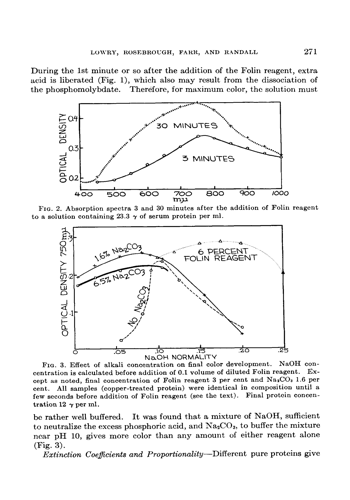

LOWRY, 
ROSEBROUGH, 
FARR, 
AND 
RANDALL 
271 
During 
the 1st minute or so after the addition 
of the Folin reagent, extra 
acid is liberated 
(Fig. 
l), which 
also may result 
from the dissociation 
of 
the phosphomolybdate. 
Thergfore, 
for maximum 
color, the solution 
must 
I 
I 
1 
I 
I 
I 
I 
400 
500 
600 
700 
800 
900 
1000 
mp 
FIG. 
2. Absorption 
spectra 
3 and 
30 minutes 
after 
the 
addition 
of Folin 
reagent 
to a solution 
containing 
23.3 
‘y of serum 
protein 
per 
ml. 
I 
I 
a 
I 
0 
.05 
10 
.15 
.20 
.25 
NaOH 
NORMALITY 
FIG. 
3. Effect 
of alkali 
concentration 
on final 
color 
development. 
NaOH 
con- 
centration 
is calculated 
before 
addition 
of 0.1 volume 
of diluted 
Folin 
reagent. 
Ex- 
cept 
as noted, 
final 
concentration 
of Folin 
reagent 
3 per 
cent 
and 
Na&03 
1.6 per 
cent. 
All 
samples 
(copper-treated 
protein) 
were 
identical 
in composition 
until 
a 
few 
seconds 
before 
addition 
of Folin 
reagent 
(see the 
text). 
Final 
protein 

In [12]:
if RUN_DEV_CELLS:
    lowry = extract_pdf_content("Lowry.pdf")
    show_pdf_page(lowry.pages[6])

### This is a mess. Not only is the text all over the place, the extracted images are just slices of the page.

### We will need to use Gemini to both re-OCR the text, and locate the images in the page.

---

In [13]:
## Handle retries and errors.

def PartType_to_Content(parts: list, role:str = "user"):
        return {
            "role": role,
            "parts": [ to_part(part) for part in parts]
        }

def gemini_generate(model,
                    parts,
                    prefill:str=None,
                    generation_config=None,
                    safety_settings=SAFETY_SETTINGS,
                    retries=MAX_RETRIES):

    messages = PartType_to_Content(parts, role="user")
    if (prefill):
        prefill = PartType_to_Content(prefill, role="model")

    attempts = 0



    while attempts < retries:
        if (attempts > 0):
            warnings.warn(f"Retry {attempts} of maximum {retries}", stacklevel=1)

        response = model.generate_content(
            messages,
            generation_config=generation_config,
            safety_settings=safety_settings,
            request_options=request_options
        )

        
        
        # The call was successful, or we have reached the max tokens.
        # A page should normally not contain this many tokens, but sometimes Gemini gets stuck. :/
        if response.candidates[0].finish_reason in [ Candidate.FinishReason.STOP, Candidate.FinishReason.MAX_TOKENS]:
            tok_in = response.usage_metadata.prompt_token_count
            tok_out = response.usage_metadata.candidates_token_count
            
            if response.candidates[0].finish_reason == Candidate.FinishReason.MAX_TOKENS:
                print(f"Max token reached, the response will be truncated! ({tok_in} tokens in, {tok_out} tokens out)")
            return response.text, tok_in, tok_out


        # Failure cases
        if len(response.candidates) == 0:
            warnings.warn("No candidates received from the model.", stacklevel=1)
            attempts += 1
            continue

        if not response.candidates[0].finish_reason == Candidate.FinishReason.STOP:
            warnings.warn(f"Unexpected finish reason {response.candidates[0].finish_reason.name}", stacklevel=1)
            attempts += 1

    # If we reach here, we have failed all retries.
    if len(response.candidates) == 0:
        raise Exception("No candidates received from the model.")

    if not response.candidates[0].finish_reason == Candidate.FinishReason.STOP:
        raise Exception(f"Unexpected finish reason {response.candidates[0].finish_reason}")

    print(reponse)
    raise Exception("Huh? How did we get here??")

In [14]:
# model = genai.GenerativeModel(model_name="gemini-1.5-flash-002")

# # For logging.
# def retry_predicate(exception):
#     print(f"Retry on exception {exception}")
#     return True


# model.generate_content(["Hello"], request_options=RequestOptions(retry=retry.Retry(predicate=retry_predicate, initial=5, multiplier=2, maximum=60, timeout=5*60)))

In [15]:
good_enough_prompt="""
You are given a page from a PDF document, and images automatically extracted from it.

First, check if the original page actually has images (figures, plots, diagrams, etc) in it.
If no, return an empty list for the image ratings.
If yes, for all provided images, determine if the image is extracted perfectly.

A perfectly extracted image fully captures one or more figure, plot, or diagram in the page.

Poorly extracted images:
- Extracted image captures only part of a figure, plot, or diagram.
- Extracted image is an image of the full page with mostly text in it.

Be picky.
It's ok if all images are good or bad. Briefly explain your reasoning before making a decision.
"""

# I found that even for this simple task a bit of COT makes a day and night difference.
# The model will generate the values in alphabetical order of the keys, so we need to place reasoning before decision.
class ImageRating(TypedDict):
    a_name: str
    b_reason: str
    c_good: bool

class NeedManualExtraction(TypedDict):
    a_page_has_images: bool
    image_ratings: list[ImageRating]


def analyze_extracted_images(page: PDFPage):
    model = genai.GenerativeModel(model_name=IMAGE_CHECK_MODEL,)

    messages = ["PDF Page:\n", page.page_image]

    if len(page.extracted_images):
        messages.append("Extracted images:\n")
    else:
        messages.append("No images have been extracted from this page, reply with an empty list for image ratings")

    for image in page.extracted_images:
        messages.append(f"Extracted image '{image.name}':\n")
        messages.append(image.image)

    messages.append(good_enough_prompt)

    result, _, _ = gemini_generate(
        model,
        messages,
        generation_config=genai.GenerationConfig(
            max_output_tokens=4000,
            temperature=0,
            top_k=1,
            response_mime_type="application/json",
            response_schema=NeedManualExtraction,
        ),
        safety_settings=SAFETY_SETTINGS,
    )

    page.extracted_images_analyzed = json.loads(result)

In [16]:
if RUN_DEV_CELLS:
    analyze_extracted_images(aiayn.pages[0])
    print("AIAYN no images: " + json.dumps(aiayn.pages[0].extracted_images_analyzed, indent=2))

    analyze_extracted_images(aiayn.pages[3])
    print("AIAYN with good images: " + json.dumps(aiayn.pages[3].extracted_images_analyzed, indent=2))

    analyze_extracted_images(lowry.pages[0])
    print("Lowry no images: " + json.dumps(lowry.pages[0].extracted_images_analyzed, indent=2))

    analyze_extracted_images(lowry.pages[1])
    print("Lowry no images: " + json.dumps(lowry.pages[1].extracted_images_analyzed, indent=2))

    analyze_extracted_images(lowry.pages[6])
    print("Lowry bad images: " + json.dumps(lowry.pages[6].extracted_images_analyzed, indent=2))

AIAYN no images: {
  "a_page_has_images": false,
  "image_ratings": []
}
AIAYN with good images: {
  "a_page_has_images": true,
  "image_ratings": [
    {
      "a_name": "image_2.png",
      "b_reason": "The image is a perfect extraction of the left diagram.",
      "c_good": true
    },
    {
      "a_name": "image_1.png",
      "b_reason": "The image is a perfect extraction of the right diagram.",
      "c_good": true
    }
  ]
}
Lowry no images: {
  "a_page_has_images": false,
  "image_ratings": []
}
Lowry no images: {
  "a_page_has_images": false,
  "image_ratings": []
}
Lowry bad images: {
  "a_page_has_images": true,
  "image_ratings": [
    {
      "a_name": "image_101.png",
      "b_reason": "The extracted image captures only part of the figure.",
      "c_good": false
    },
    {
      "a_name": "image_102.png",
      "b_reason": "The extracted image captures only part of the figure.",
      "c_good": false
    },
    {
      "a_name": "image_103.png",
      "b_reason": "The

### Gemini Flash correctly recognized if a pages has images in it, and for a page with images it correctly recognized if the images are good or not.
### Looks promising. I will assume that the page contains good images if the model gives 👍 for 80%+ of the images

In [17]:
def page_needs_image_extraction(page: PDFPage):
    analyze_extracted_images(page)

    if not page.extracted_images_analyzed.get("a_page_has_images", False):
        # Remove the wrongly extracted images from pages without images to avoid confusing the model later
        page.extracted_image = []
        return False

    good_images = [rating.get("c_good", False) for rating in page.extracted_images_analyzed.get("image_ratings", [])]

    # Sometimes Gemini hallucinates images when given an empry list of extracted images.
    if len(page.extracted_images) < 1:
        return True

    # <= to account for the case where there are images, but none have been extracted.
    if good_images.count(True) <= 0.8 * len(good_images):
        # Images bad overall - remove everything.
        page.extracted_images = []
        return True

    return False

In [18]:
if RUN_DEV_CELLS:
    print(page_needs_image_extraction(aiayn.pages[3]))
    print(page_needs_image_extraction(lowry.pages[6]))

False
True


### Now, if the page needs AI-asisted image extraction...

In [19]:
# I think Gemini prefers this order or coordinates.
image_extraction_prompt = """
Annotate the images in the document with a meaningful filename (.png) and a bounding box.
Only provide one annotation for each image. Do not annotate tables.

JSON schema:
[
    {
        a_caption: "Image caption",
        bbox: [top, left, bottom, right]
    },
]
"""

class ImageAnnotation(TypedDict):
    a_caption: str
    bbox: list[int]


def page_find_bboxes(page: PDFPage):
    model = genai.GenerativeModel(model_name=IMAGE_EXTRACTION_MODEL)
    result, _, _ = gemini_generate(
        model,
        [page.page_image, image_extraction_prompt],
        generation_config=genai.GenerationConfig(
            temperature=0,
            top_k=1,
            response_mime_type="application/json",
            response_schema=list[ImageAnnotation],
            max_output_tokens=2000,

        ),
        safety_settings=SAFETY_SETTINGS,
        retries=MAX_RETRIES
    )

    page.images_proposed = []

    # Sanity check the bounding boxes and unswap coordinates if they seem to have been swapped (happens infrequently)
    for image in json.loads(result):
        bbox = image.get("bbox")
        if len(bbox) == 4:
            page.images_proposed.append({
                "a_caption": image.get("a_caption", "unknown"),
                "bbox": [min(bbox[0], bbox[2]), min(bbox[1], bbox[3]), max(bbox[0], bbox[2]), max(bbox[1], bbox[3])]
            })

In [20]:
if RUN_DEV_CELLS:
    page_find_bboxes(lowry.pages[6])

In [21]:
from PIL import ImageDraw

def visualize_bboxes(page: PDFPage):
    img = page.page_image.copy()
    draw = ImageDraw.Draw(img)

    colors = ["red", "green", "blue", "yellow", "purple", "orange", "pink", "brown", "cyan", "magenta"]
    width, height = img.size

    for i, bbox in enumerate([image["bbox"] for image in page.images_proposed]):
        # The order of coordintes is different in PIL
        bbox_img = [
            bbox[1] * width / 1000,   # xmin
            bbox[0] * height / 1000,  # ymin
            bbox[3] * width / 1000,   # xmax
            bbox[2] * height / 1000,  # ymax
        ]
        draw.rectangle(bbox_img, outline=colors[i % len(colors)], width=5)

    return img

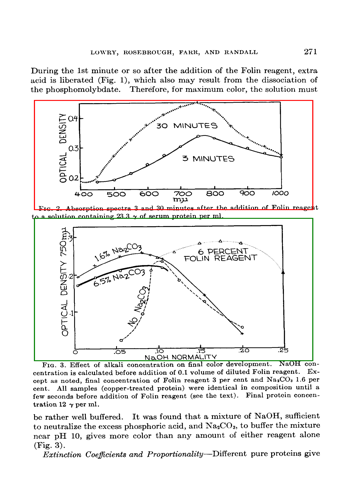

In [22]:
if RUN_DEV_CELLS:
    display(visualize_bboxes(lowry.pages[6]).resize((350, 500)))

### It's not perfect, but might be good enough.

> I tried adding more bboxes that are shifted/scaled around the predicted one, extracting the images and asking Gemini to score how well they are cropped, but for some reason Gemini had a very hard time figuring out which ones had the best crop.

I will scale up the bbox by 15% and hope it captures the whole image.
A dedicated fine-tuned object detection model would give better results, but let's stick to the challenge.


> Note: Right now Gemini seems to do a good job. For some reason, the same model was giving me bboxes that were just a tad too small.  
> I'll leave bbox scaling as is, in case it makes the same mistake for other pages.

In [23]:
def scale_bbox(bbox: list[int], scale):
    assert(len(bbox) == 4)

    ymin, xmin, ymax, xmax = bbox

    width = xmax - xmin
    height = ymax - ymin

    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2

    scaled_width = width * scale
    scaled_height = height * scale

    scale_bbox = [
        center_y - scaled_height/2, center_x - scaled_width/2,
        center_y + scaled_height/2, center_x + scaled_width/2
    ]

    return [max(0, min(1000, int(x))) for x in scale_bbox]

def page_scale_bboxes(page: PDFPage, scale):
    for image in page.images_proposed:
        image["bbox"] = scale_bbox(image["bbox"], scale)

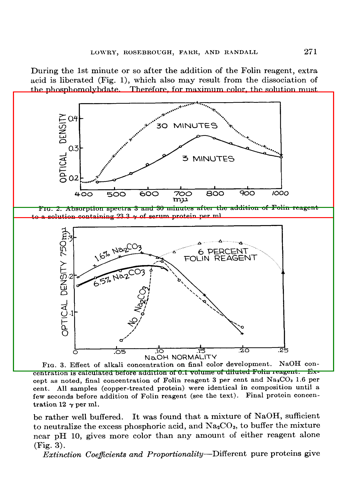

In [24]:
if RUN_DEV_CELLS:
    page_scale_bboxes(lowry.pages[6], 1.15)
    display(visualize_bboxes(lowry.pages[6]).resize((350, 500)))

### We get a bit more text around the image, but I think it's a better alternative to cropping the image.

Another solution would be to pass the images with rendered bboxes to Gemini and ask it to adjust the bboxes, but I did not try that.

In [25]:
# Adds the extracted images to the page.

# I will give a random name to extracted images to avoid biasing the model based on the image number.
# Store the names in a list to avoid duplicates.
random_names = []

def extract_images_from_page(page: PDFPage):

    # Drop the previouly extracted bad images.
    page.extracted_images = []

    for bbox in [image["bbox"] for image in page.images_proposed]:
        ymin, xmin, ymax, xmax = bbox
        width, height = page.page_image.size

        bbox_img = page.page_image.crop((
            xmin * width / 1000, ymin * height / 1000,
            xmax * width / 1000, ymax * height / 1000
        ))

        while True:
            random_name = ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))
            if random_name not in random_names:
                random_names.append(random_name)
                break

        page.extracted_images.append(PDFImage(
            image=bbox_img,
            name=f"image_{random_name}.png",
            bbox=bbox,
        ))

In [26]:
if RUN_DEV_CELLS:
    extract_images_from_page(lowry.pages[6])

In [27]:
# Remove the anti-reciting hack.
def remove_recitation_hack(markdown: str):
    return markdown.replace("[end of paragraph]", "")

In [28]:

common_markdown_prompt = """
Use markdown heading levels for sections.

Insert 2 new lines to force a line bvreak.

For images:
<img src="filename" width="x">. Do not rename images.

For tables:
Use markdown tables, don not include images of tables.

For math formulas:
Use markdown formulas `$...$ ` for inline formulas, and block formulas \n$$\n...\n$$\n for block formulas.
Use \\tag{n} if you need to number a block formula.

For chemical formulas:
Use <sub> and <sup>

For figure captions:
Use markdown quotes (> Figure n: caption)

Escape symbols in text that would be wrongly interpreted as markdown (#, $, *, etc)

Avoid using HTML to format the document, but keep HTML code if it's present as part of the document.

Insert [end of paragraph] after each paragraph.
"""

page_markdown_prompt = """
Convert the page to markdown. Convert all text as is, don't skip any parts, don't change wording.
Ignore purely decorative elements.

If a page contains figures, plots, diagrams, etc and an image for it is available, include it in markdown.
Place each image roughly where it appears in the page. Avoid breaking sentences to fit images.
Ignore images that do not belong in the page.
"""

prompt = "\n".join(common_markdown_prompt + page_markdown_prompt)


def page_to_markdown(page: PDFPage):
    model = genai.GenerativeModel(model_name=PAGE_TO_MARKDOWN_MODEL)
    image_messages = []
    for img in page.extracted_images:
        image_messages.append(f"Image variant {img.name}:\n")
        image_messages.append(img.image)

    markdown, tok_in, tok_out = gemini_generate(
        model,
        [
            page.page_image,
            f"Extracted page text:\n",
            page.extracted_text,
            "\nExtracted images:\n",
            *image_messages,
            prompt
        ],
        prefill=["```markdown\n"], # Gemini often wraps the output in ```markdown or ```text. I prefill it for consistency.
        generation_config=genai.GenerationConfig(
            temperature=0,
            top_k=1,
            max_output_tokens=4000,
            response_mime_type="text/plain"
        ),
        safety_settings=SAFETY_SETTINGS
    )

    markdown = markdown.strip()
    
    prefix = "```markdown\n"
    suffix = "```"

    if markdown.startswith(prefix):
        markdown = markdown[len(prefix):]
    if markdown.endswith(suffix):
        markdown = markdown[:-len(suffix)]

    page.markdown = remove_recitation_hack(markdown).strip()
    return tok_in, tok_out

In [29]:
## Save the images so we can render them.
def save_markdown_images(page: PDFPage, directory: str="."):
    directory = Path(directory)
    # Save the images mentioned in the markdown
    os.makedirs(directory, exist_ok=True)
    for img in page.extracted_images:
        if (img.name in page.markdown):
            img.image.save(directory / img.name)

In [30]:
# We saved the images in an output dir, but the image references in Markdown don't have this
# prefix. To render markdown in the notebook, I will need to prepend the directory to the image names.

def patch_dir_base(input: string, image_names: list[str], prefix: Path):
    prefix = Path(prefix)

    replacements = { name : str(prefix/name) for name in image_names }
    pattern = '|'.join(map(re.escape, replacements.keys()))
    return re.sub(pattern, lambda m: replacements[m.group()], input)

In [31]:
# I also wrap the markdown in a collapsible element to avoid cluttering the notebook.
def display_markdown(markdown: str, image_names: list[str], prefix: Path):
    display(Markdown(f"<details><summary>Click to expand</summary>\n\n{patch_dir_base(markdown, image_names, prefix)}\n\n</details>"))

In [32]:
# Let's try with the AIAYN page.
if RUN_DEV_CELLS:
    page_to_markdown(aiayn.pages[3])
    save_markdown_images(aiayn.pages[3], "aiayn_dev")
    display_markdown(aiayn.pages[3].markdown, [image.name for image in aiayn.pages[3].extracted_images], "aiayn_dev")
    # print(aiayn.pages[3].markdown)

<details><summary>Click to expand</summary>

# Scaled Dot-Product Attention


<img src="aiayn_dev/image_2.png" width="150">


# Multi-Head Attention


<img src="aiayn_dev/image_1.png" width="300">


> Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.


query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$. We compute the matrix of outputs as:


$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
\tag{1}
$$


The two most commonly used attention functions are additive attention [2], and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [3]. We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients<sup>4</sup>. To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.

## 3.2.2 Multi-Head Attention

Instead of performing a single attention function with $d_{\text{model}}$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values, as depicted in Figure 2.

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

<sup>4</sup>To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean 0 and variance 1. Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean 0 and variance $d_k$.

</details>

### Looks very good! Let's try with the Lowry page.

In [33]:
if RUN_DEV_CELLS:
    page_to_markdown(lowry.pages[6])
    save_markdown_images(lowry.pages[6], "lowry_dev")
    display_markdown(lowry.pages[6].markdown, [image.name for image in lowry.pages[6].extracted_images], "lowry_dev")
    # print(lowry.pages[6].markdown)

<details><summary>Click to expand</summary>

# LOWRY, ROSEBROUGH, FARR, AND RANDALL
271


During the 1st minute or so after the addition of the Folin reagent, extra acid is liberated (Fig. 1), which also may result from the dissociation of the phosphomolybdate. Therefore, for maximum color, the solution must


<img src="lowry_dev/image_3jg5s.png" width="500">


> Figure 2: Absorption spectra 3 and 30 minutes after the addition of Folin reagent to a solution containing 23.3 γ of serum protein per ml.


<img src="lowry_dev/image_aw3gl.png" width="500">


> Figure 3: Effect of alkali concentration on final color development. NaOH concentration is calculated before addition of 0.1 volume of diluted Folin reagent. Except as noted, final concentration of Folin reagent 3 per cent and Na<sub>2</sub>CO<sub>3</sub> 1.6 per cent. All samples (copper-treated protein) were identical in composition until a few seconds before addition of Folin reagent (see the text). Final protein concentration 12 γ per ml.


be rather well buffered. It was found that a mixture of NaOH, sufficient to neutralize the excess phosphoric acid, and Na<sub>2</sub>CO<sub>3</sub>, to buffer the mixture near pH 10, gives more color than any amount of either reagent alone (Fig. 3).

Extinction Coefficients and Proportionality—Different pure proteins give

</details>

### It looks decent too, let's tie it all together!

### Let's process multiple pages in paralle to make it faster.

Note: I'm not sure what's a reasonable number of parallel workers that does not get rate-limited with a free API key.

In [34]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial

def process_single_page(page, master_pbar):
    # pbar = tqdm(desc=f"Page {page.page_num}", total=3)
    
    pbar = progress_bar(range(3), comment="Checking images...")
    pbar.update(0)

    
    
    # pbar.set_postfix_str("Checking images...")
    need_extraction = page_needs_image_extraction(page)
    pbar.update(1)
    if (need_extraction):
        pbar.comment = "Generating BBoxes..."
        pbar.update(1)

        page_find_bboxes(page)
        page_scale_bboxes(page, 1.15)
        extract_images_from_page(page)

    pbar.comment = "Converting to Markdown..."
    pbar.update(2)
    
    tok_in, tok_out = page_to_markdown(page)
    pbar.comment = f"Done, tokens: {tok_in} => {tok_out}"
    pbar.update(3)

    master_pbar.update(master_pbar.last_v + 1)

def pdf_to_markdown(pdf: PDFDocument, max_workers=16):
    master_pbar = progress_bar(range(len(pdf.pages)), comment="Processing pages")
    master_pbar.update(0)
    
    # with tqdm(total=len(pdf.pages), desc="Processing pages", unit="page") as pbar:
    with ThreadPoolExecutor(max_workers=min(len(pdf.pages), max_workers)) as executor:
        process_fn = partial(process_single_page, master_pbar=master_pbar)
        list(executor.map(process_fn, pdf.pages))
    pdf.markdown = remove_recitation_hack("\n\n".join([page.markdown for page in pdf.pages])).strip()

In [35]:
if RUN_DEV_CELLS:
    pdf_to_markdown(lowry)
    for page in lowry.pages:
        save_markdown_images(page, "lowry_dev")

    display_markdown(lowry.markdown, [image.name for page in lowry.pages for image in page.extracted_images], "lowry_dev")

<details><summary>Click to expand</summary>

# PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT*


BY OLIVER H. LOWRY, NIRA J. ROSEBROUGH, A. LEWIS FARR, AND ROSE J. RANDALL


(From the Department of Pharmacology, Washington University School of Medicine, St. Louis, Missouri)


(Received for publication, May 28, 1951)


Since 1922 when Wu proposed the use of the Folin phenol reagent for the measurement of proteins (1), a number of modified analytical procedures utilizing this reagent have been reported for the determination of proteins in serum (2-6), in antigen-antibody precipitates (7-9), and in insulin (10).


Although the reagent would seem to be recommended by its great sensitivity and the simplicity of procedure possible with its use, it has not found great favor for general biochemical purposes.


In the belief that this reagent, nevertheless, has considerable merit for certain application, but that its peculiarities and limitations need to be understood for its fullest exploitation, it has been studied with regard to effects of variations in pH, time of reaction, and concentration of reactants, permissible levels of reagents commonly used in handling proteins, and interfering substances. Procedures are described for measuring protein in solution or after precipitation with acids or other agents, and for the determination of as little as 0.2 γ of protein.


## Method


Reagents—Reagent A, 2 per cent Na<sub>2</sub>CO<sub>3</sub> in 0.10 N NaOH. Reagent B, 0.5 per cent CuSO<sub>4</sub>.5H<sub>2</sub>O in 1 per cent sodium or potassium tartrate. Reagent C, alkaline copper solution. Mix 50 ml. of Reagent A with 1 ml. of Reagent B. Discard after 1 day. Reagent D, carbonate-copper solution, is the same as Reagent C except for omission of NaOH. Reagent E, diluted Folin reagent. Titrate Folin-Ciocalteu phenol reagent ((11), Eimer and Amend, Fisher Scientific Company, New York) with NaOH to a phenolphthalein end-point. On the basis of this titration dilute the Folin reagent (about 2-fold) to make it 1 N in acid. Working standards may be prepared from human serum diluted 100- to 1000-fold (approximately 700 to 70 γ per ml.). These in turn may be checked against a standard solution of crystalline bovine albumin (Armour and


\* Supported in part by a grant from the American Cancer Society on the recommendation of the Committee on Growth of the National Research Council.


265


<img src="lowry_dev/image_0.png" width="500">


This is an Open Access article under the CC BY license.

# PROTEIN MEASUREMENT WITH FOLIN REAGENT

266


Company, Chicago); 1 γ is the equivalent of 0.97 γ of serum protein (see below). Dilute solutions of bovine albumin have not proved satisfactory for working standards because of a marked tendency to undergo surface denaturation.


## Procedure for Proteins in Solution or Readily Soluble in Dilute Alkali

(Directions are given for a final volume of 1.1 to 1.3 ml., but any multiple or fraction of the volumes given may be employed as desired.)


To a sample of 5 to 100 γ of protein in 0.2 ml. or less in a 3 to 10 ml. test-tube, 1 ml. of Reagent C is added. Mix well and allow to stand for 10 minutes or longer at room temperature. 0.10 ml. of Reagent E is added very rapidly and mixed within a second or two (see below). After 30 minutes or longer, the sample is read in a calorimeter or spectrophotometer. For the range 5 to 25 γ of protein per ml. of final volume, it is desirable to make readings at or near λ = 750 mμ, the absorption peak. For stronger solutions, the readings may be kept in a workable range by reading near λ = 500 mμ (Fig. 2). Calculate from a standard curve, and, if necessary, make appropriate correction for differences between the color value of the working standard and the particular proteins being measured (see below).


It is unnecessary to bring all the samples and standards to the same volume before the addition of the alkaline copper reagent, provided corrections are made for small differences in final volume. The critical volumes are those of the alkaline copper and Folin reagents.


If the protein is present in an already very dilute solution (less than 25 γ per ml.), 0.5 ml. may be mixed with 0.5 ml. of an exactly double strength Reagent C and otherwise treated as above.


## Insoluble Proteins, etc.

Many protein precipitates, e.g. tungstate precipitates, will dissolve readily in the alkaline copper reagent. However, after proteins have been precipitated with trichloroacetic or perchloric acid, for example, they will dissolve rather poorly in the 0.1 N alkali of this reagent. They become even harder to dissolve if subsequently extracted with fat solvents, and still more so if dried at 100°.


It is not possible to cover all cases, but the following may be helpful in measuring the protein of acid precipitates. If the amount of protein is not great, so that it is spread rather thinly, it will usually dissolve in ½ hour or so in 1 N NaOH at room temperature. Therefore, one may add, for example, 0.1 ml. of 1 N NaOH to 5 to 100 γ of precipitated protein.


> ¹ For example, with the Klett colorimeter, transfer 25 to 500 γ of protein in not over 1 ml. volume to a colorimeter tube. Add water if necessary to make 1 ml. Add 5 ml. of Reagent C, and, after 10 minutes, 0.5 ml. of Reagent E. Readings are taken after 30 minutes with the No. 66 filter. If the readings are too high, substitute the No. 54 filter for sample, standards, and blanks.

# LOWRY, ROSEBROUGH, FARR, AND RANDALL
267


After ½ hour or more, 1 ml. of Reagent D (no NaOH) is added, followed after 10 minutes by 0.1 ml. of diluted Folin Reagent E as usual.




With larger samples, or very stubborn precipitates, it may be necessary to heat for 10 minutes or more at 100° in 1 N alkali. Although this may lower the readings, they will be reproducible and can be measured with similarly treated standards.²




## Microanalysis

With a Beckman spectrophotometer adapted to 0.05 ml. volume (12), as little as 0.2 γ of protein may be measured with reasonable precision. Aside from reducing the volumes of sample and reagents, the only necessary change is to use sufficiently slender tubes for the reaction. If the tubes are too large in diameter, low values will result. The following is illustrative of a procedure in which it is desired to precipitate the protein in order, for example, to measure an acid-soluble constituent of the same specimen. In this example, it is assumed that the sample volume is negligible. Otherwise a smaller volume of more concentrated trichloroacetic acid would be used.




To the sample containing 0.2 to 3 γ of protein in a tube of 3 mm. inner diameter and 4 cm. long,³ are added 10 µl. of 5 per cent trichloroacetic acid.⁴ After being mixed and centrifuged, 8 µl. of the supernatant fluid are removed. To the precipitate are added 5 µl. of 8 N NaOH. The sample is thoroughly mixed by tapping or “buzzing,”⁵ and is covered


² Bovine serum albumin is especially difficult to redissolve after precipitation. Several 40 mg. samples were precipitated with trichloroacetic acid, washed with alcohol and isopropyl ether, and dried. These samples dissolved very slowly in 2 ml. of 1 N NaOH. However, after standing overnight, the protein appeared to be nearly all dissolved and aliquots gave readings 97 per cent of those obtained with non-precipitated samples. Other samples were heated for 30 minutes at 100° in 1 N NaOH. These samples dissolved and the solution turned slightly yellow. The final readings checked well but were only 82 per cent of those obtained with non-precipitated samples. Possibly, heating at lower temperature with the 1 N NaOH would have sufficed, although heating with weaker alkali would not have been effective, judging from other experience. The use of stronger alkali than 1 N did not appear to be an improvement.


³ These tubes are cleaned by rinsing with dilute NaOH, boiling in half concentrated HNO<sub>3</sub>, and rinsing several times in redistilled water. Filling or emptying of a beaker full of tubes (tall form of beaker without lip) is accomplished by slow centrifugation for a few seconds. For emptying, the tubes are transferred upside down to a second beaker with a false bottom of stainless steel screen. With the slow centrifugation required beakers will not be broken.


⁴ Suitable micro pipettes are the Lang-Levy variety (13, 14). For entering these narrow tubes the bent tip must be especially short and slender.


⁵ The tube is held at an angle against a rapidly rotating flattened rod or nail. Any high speed hand tool mounted in a clamp is satisfactory. The contents of the tube will mix violently without spilling (15). A similar effect may be had with a commercial rubber-tipped massage vibrator.

# PROTEIN MEASUREMENT WITH FOLIN REAGENT

268


with a rubber cap or Parafilm. After 30 minutes, 50 μl. of Reagent D are added and the sample is mixed by “buzzing.” After 10 minutes or more, 5 μl. of diluted Folin Reagent E are added with immediate “buzzing,” and the samples are read after 30 minutes. Standards are perhaps best prepared by precipitating 5 μl. of 5, 10, 20, etc., mg. per cent solutions of serum protein with 5 μl. of 10 per cent trichloroacetic acid, with subsequent treatment as for the other samples.


# EXPERIMENTAL

There are two distinct steps which lead to the final color with protein: (a) reaction with copper in alkali, and (b) reduction of the phosphomolybdic-phosphotungstic reagent by the copper-treated protein.


Reaction with Copper in Alkaline Solution—The salient features of this reaction follow. (1) The color obtained in the absence of copper is probably attributable entirely to the tyrosine and tryptophan content (16, 17), and this is not greatly increased by alkaline pretreatment ((4-6) and Table I). (2) In the presence of copper, alkaline treatment of proteins results in a 3- to 15-fold increase in color, but, in contrast, the presence of copper has only a small effect on the color obtained with free tyrosine and tryptophan (Herriott (17, 18) and Table I). (3) The reaction with copper, although not instantaneous, is nearly complete in 5 or 10 minutes at room temperature under the prescribed conditions. Heating to 100° or increasing the concentration of alkali accelerates the reaction with copper without changing the final color. (4) Pretreatment with alkali alone does not alter the subsequent reaction with copper in alkaline solution. Even pretreatment for an hour at 60° with 2 N NaOH, or for 5 minutes at 100° with 1 N NaOH, when followed by the usual copper treatment, has almost no effect on subsequent color.² Prolonged heating with strong alkali will, however, decrease the final color.²


Although the alkaline copper reaction and the biuret reaction appear to be related, they are not strictly proportional, nor, with different proteins, is the amount of biuret color directly proportional to the increment caused by copper in the color with the Folin reagent (Table I).


A very small amount of copper is sufficient to give nearly maximum final color (Table II). The action does not appear to be catalytic. Assuming the simple relationship copper + protein ⇌ copper-protein obtains, the data with low copper concentrations may be utilized to calculate an apparent dissociation constant of 3 × 10⁻⁶ mole per liter with a maximum of 1 mole of chromogenic protein-bound copper per 7 or 8 amino acid residues (Table II).


Mehl, Pacovska, and Winzler (19) conclude with Rising and Yang (20) that in the biuret reaction approximately 1 atom of copper is bound for

# LOWRY, ROSEBROUGB, FARR, .4ND RANDALL
269


## TABLE I
Extinction Coefficients of Proteins Variously Treated


The equivalent extinction coefficient ε<sub>λ</sub> (or 550) is defined as the optical density at λ = 750 (or 550) mμ with 1 atom of N per liter. Nitrogen was measured by the Kjeldahl procedure of Miller and Houghton (24). The biuret color was developed with the reagents of Weichselbaum (25). Source of proteins, crystalline trypsin, crystalline chymotrypsin, and crystalline bovine albumin, Armour and Company, Chicago; cytochrome c, Sigma Chemical Company, St. Louis; crystalline zinc insulin, Eli Lilly and Company, Indianapolis; gelatin, Difco Laboratories, Inc., Detroit; L-tyrosine, Eastman Kodak Company, Rochester.


| Protein | Copper absent | Alkaline copper treatment | Increment with Cu | Biuret color |
|---|---|---|---|---|
|  | No pre-treatment | Alkali* treatment |  |  |
| Trypsin | 733 | 910 | 3,600 | 2690 | 26.3 |
| Insulin | 989 | 998 | 3,000 | 2002 | 24.4 |
| Chymotrypsin | 278 | 425 | 2,930 | 2505 | 25.8 |
| Cytochrome c. | 703 | 738 | 2,495 | 1757 | †21.4 |
| Human serum | 329 | 365 | 2,120 | 1755 | 21.8 |
| Bovine serum albumin | 312 | 358 | 2,050 | 1692 | 21.8 |
| Gelatin | 79 | 78 | 1,145 | 1067 | 18.0 |
| Tyrosine | 13,700 | 13,850 | 15,100 | 1250 |  |

<img src="lowry_dev/image_mubfb.png" width="500">


* 30 minutes in 0.1 N NaOH at room temperature before addition of Folin reagent.
† Regular treatment as described under the procedure.
‡ Not valid because of the color of the cytochrome c.



## TABLE II
Color Increments from Small Amounts of Copper


Serum protein concentration, 12.1 γ per ml. K and chromogenic-bound copper (Cu-protein) calculated from K = Cu X protein/Cu-protein = (Cu(total protein – Cu-protein))/Cu-protein = (Cu(maximum ΔO. D.* - ΔO. D.))/ΔO. D. (assuming that chromogenic copper bound to protein is proportioned to ΔO. D.).


| Total Cu | O. D.* at 750 mμ | ΔO. D. | ΔO. D., per cent of maximum Δ | K | Cu-protein† (calculated) |
|---|---|---|---|---|---|
| 10<sup>-7</sup> γ |  |  |  | x 10<sup>-7</sup> |  |
| 0 | 78 |  |  |  |  |
| 8 | 166 | 88 | 42 | 2.9 | 0.05 |
| 20 | 237 | 159 | 76 | 3.0 | 0.10 |
| 40 | 267 | 189 | 91 | 2.8 | 0.12 |
| 2000 | 286 | 208 | 100 |  | 0.13 |

<img src="lowry_dev/image_c25j1.png" width="500">


* Optical density.
† Moles per 117 gm. of protein, *i.e.* per amino acid residue.

270
PROTEIN MEASUREMENT WITH FOLIN REAGENT

each 4 amino acid residues, and Mehl et al. calculated dissociation constants for the reaction copper + protein * copper-protein averaging 10 times larger than the one reported herein for the formation of Folin-reactive material. Thus, of the total possible sites for copper combination, it would appear that only about half produce significant reduction of the Folin reagent, and that furthermore this fraction has a considerably greater affinity for copper than the rest.


<img src="lowry_dev/image_r3vv7.png" width="500">


Fig. 1. “Persistence of reactivity” was measured by adding Folin reagent to protein-free alkali; after the given times, copper-treated protein was added in a small volume, and the color at 750 mµ was measured 30 minutes later. “Color development” refers to a sample of serum protein treated in the regular manner. The points on “optical density 448 mµ” are observed (no protein present); the curve is theoretical for a monomolecular reaction with a half time of 8 seconds.



Reduction of Folin Reagent-Three main points may be made as follows: (1) When the Folin reagent is added to the copper-treated protein, maximum color results if the reduction occurs at about pH 10. (2) At this pH the reagent is only reactive for a short time (16). It is for this reason that even a few seconds delay in complete mixing will lessen the amount of color (Fig. 1). The decrease in reactivity of the reagent appears to be a function of the disappearance of the original yellow color of the phosphomolybdate (half time of 8 seconds (Fig. 1)) and is presumably due to dissociation of the phosphate from the molybdate. Surprisingly, the color with protein continues to develop for a number of minutes after the reagent itself has become unreactive to freshly added protein (Fig. 1). Possibly the primary reduction product rearranges, since the absorption spectrum changes in shape between 3 minutes and 30 minutes (Fig. 2). (3)

# LOWRY, ROSEBROUGH, FARR, AND RANDALL
271


During the 1st minute or so after the addition of the Folin reagent, extra acid is liberated (Fig. 1), which also may result from the dissociation of the phosphomolybdate. Therefore, for maximum color, the solution must


<img src="lowry_dev/image_3jg5s.png" width="400">


> Figure 2: Absorption spectra 3 and 30 minutes after the addition of Folin reagent to a solution containing 23.3 γ of serum protein per ml.


<img src="lowry_dev/image_aw3gl.png" width="400">


> Figure 3: Effect of alkali concentration on final color development. NaOH concentration is calculated before addition of 0.1 volume of diluted Folin reagent. Except as noted, final concentration of Folin reagent 3 per cent and Na<sub>2</sub>CO<sub>3</sub> 1.6 per cent. All samples (copper-treated protein) were identical in composition until a few seconds before addition of Folin reagent (see the text). Final protein concentration 12 γ per ml.


be rather well buffered. It was found that a mixture of NaOH, sufficient to neutralize the excess phosphoric acid, and Na<sub>2</sub>CO<sub>3</sub>, to buffer the mixture near pH 10, gives more color than any amount of either reagent alone (Fig. 3).

Extinction Coefficients and Proportionality—Different pure proteins give

# PROTEIN MEASUREMENT WITH FOLIN REAGENT

272


different extinction coefficients with the Folin reagent (Table I). The extremes were observed with trypsin and gelatin which differed by a factor of 3 in chromogenicity. It will be seen that without copper much greater differences occur. The variation in chromogenicity must be kept in mind, but it is much less marked with mixtures of proteins as found in various tissues (Table III), and for many purposes is not a serious drawback.
The relation of color to protein concentration is not quite linear (Table IV).


TABLE III

Apparent Protein Content of Whole Tissues (Rabbit) and Tissue Extracts Calculated from Kjeldahl N and from Folin Color

The tissues were homogenized and precipitated with 5 per cent trichloroacetic acid (TCA), and the lipides removed by successive extraction with 0.1 N potassium acetate in ethanol, ethanol, and isopropyl ether. (The purpose of the acetate is to neutralize the acid and prevent solution of some protein in the ethanol.) The N was determined as in Table I. The extinction coefficients were calculated from the N and color of the extracted precipitates.

| Material analyzed | Extracted ppt. | TCA extract | Lipide extracted | Whole tissue | N* €750 |
|---|---|---|---|---|---|
| Brain | Based on N × 6.25 | 9.5 | 1.08 | 1.05 | 11.8 | 1960 |
|  | " " Folin color | 9.5 | 0.15 | 0.28 | 9.8 |  |
| Kidney | " " N × 6.25 | 13.9 |  |  | 15.9 | 1865 |
|  | " " Folin color | 13.9 | 0.30 | 0.21 | 14.5 |  |
| Liver | " " N × 6.25 | 17.1 |  |  | 19.9 | 1875 |
|  | " " Folin color | 17.1 | 0.49 | 0.28 | 18.0 |  |
| Skeletal muscle | " " N × 6.25 | 17.8 |  |  | 20.1 | 1942 |
|  | " " Folin color | 17.8 | 0.15 | 0.09 | 18.8 |  |
| Heart | " " N × 6.25 | 13.0 |  |  | 15.3 | 1975 |
|  | " " Folin color | 13.0 | 0.20 | 0.17 | 13.4† |  |

* See Table I.
† By summation; other values are direct determinations.


Specificity and Interfering Substances—Few substances encountered in biological work cause serious interference. Only a little color was obtained with either acid extracts or the lipides extracted from five different tissues (Table III). Consequently measurements on non-extracted whole tissue would be in error by only 3 to 6 per cent, whereas values based on N determination would be overestimated by 15 to 20 per cent.
Uric acid (16), guanine, and xanthine (21, 22) react with the Folin reagent. Guanine gives about 50 per cent more color than serum protein, weight for weight. The color is not enhanced by copper. Curiously, guanosine does not react appreciably. Hypoxanthine gives no color if purified (21). No more than a trace of color was obtained with adenine, ade-

<img src="image.png" width="500">

LOWRY, ROSEBROUGH, FARR, AND RANDALL
273

nosine, cytosine, cytidine, uracil, thymine, or thymidine (see also Funk and Macallum (22)).

Neither color nor interference with protein color development was observed with the following substances at the given final concentrations: urea (0.5 per cent), guanidine (0.5 per cent), sodium tungstate (0.5 per cent), sodium sulfate (1 per cent), sodium nitrate (1 per cent), perchloric acid (0.5 per cent neutralized), trichloroacetic acid (0.5 per cent neutralized), ethyl alcohol (5 per cent), ether (5 per cent), acetone (0.5 per cent), zinc sulfate (0.1 per cent), barium hydroxide (0.1 per cent).

Most phenols, except nitrophenols, reduce the reagent (16); therefore thymol and to a lesser degree sulfosalicylic acid interfere, whereas picric

TABLE IV
Measurement of Small Amounts of Protein from Rabbit Brain
Final volume 0.082 ml.

| Optical* density at 750 mµ | E<sub>1 cm.</sub><sup>1%</sup> at 750 mµ | Protein Found | Protein Present | Optical* density at 750 mµ | E<sub>1 cm.</sub><sup>1%</sup> at 750 mµ | Protein Found | Protein Present |
|---|---|---|---|---|---|---|---|
| 0.038 |  | γ | γ | 0.280 | 229 | γ | γ |
| 0.044 |  | 0.13 | 0.16 | 0.292 | 236 | 0.98 | 1.00 |
| 0.040 |  | 0.15 | 0.16 | 0.283 | 233 | 1.03 | 1.00 |
| 0.089 | 221 | 0.14 | 0.16 | 0.365 | 227 | 0.99 | 1.00 |
| 0.095 | 236 | 0.33 | 0.33 | 0.367 | 228 | 1.30 | 1.32 |
| 0.091 | 226 | 0.35 | 0.33 | 0.365 | 227 | 1.31 | 1.32 |
| 0.184 | 228 | 0.34 | 0.33 | 0.441 | 219 | 1.32 | 1.32 |
| 0.191 | 236 | 0.65 | 0.66 | 0.443 | 220 | 1.60 | 1.66 |
| 0.191 | 236 | 0.67 | 0.66 | 0.444 | 221 | 1.62 | 1.66 |
|  |  | 0.67 | 0.66 |  |  | 1.61 | 1.66 |

* Corrected for blank.

acid up to 0.1 per cent is permissible. Glycine (0.5 per cent) decreases the color with protein by 50 per cent. Hydrazine over 0.5 mg. per cent increases the blank.

Ammonium sulfate greater than 0.15 per cent final concentration decreases color development. This is partly due to a decrease in alkalinity, and up to 0.25 per cent or so can be tolerated if an equivalent amount of extra alkali is added to the sample. Extra copper does not seem to help.

Microanalysis—With final volumes less than 0.1 ml., the amount of color is proportionately less than on the macro scale, especially if the reaction is carried out in wide tubes. Extensive testing did not definitely identify the cause of the decreased color. Neither oxygen, carbon dioxide, nor glass surface seemed to be involved. The critical step is the period of standing with alkali and copper.

# PROTEIN MEASUREMENT WITH FOLIN REAGENT

274


The practical solution to this interesting difficulty seems to be to use slender tubes and to run standards under the same conditions. Table IV illustrates the reproducibility of protein measurements on small brain samples. Rabbit brain was homogenized and diluted 200- to 2000-fold. Aliquots of 3.6 μl. were analyzed for protein at a final volume of 0.082 ml. The amount of protein present was calculated from macro analyses. It is seen that the error is usually not over 0.02 γ.





## DISCUSSION


The measurement of protein with copper and the Folin reagent has certain advantages. (1) It is as sensitive as with Nessler’s reagent, yet requires no digestion. (2) It is 10 or 20 times more sensitive than measurement of the ultraviolet absorption at λ = 280 mμ and is much more specific and much less liable to disturbance by turbidities. (3) It is several fold more sensitive than the ninhydrin reaction (23) and is somewhat simpler, as well as much easier to adapt for small scale analyses. Free amino acids give much more color than proteins with the ninhydrin reaction, whereas the reverse is true with the Folin reagent. (4) It is 100 times more sensitive than the biuret reaction.




There are two major disadvantages of the Folin reaction. (a) The amount of color varies with different proteins. In this regard it is less constant than the biuret reaction, but more constant than the absorption at λ = 280 mμ. (b) The color is not strictly proportional to concentration.




From a consideration of the advantages and disadvantages, the reasonable applications of the copper-Folin reaction would seem to include (1) measurement of protein during enzyme fractionations, etc., (2) measurement of mixed tissue proteins, particularly when absolute values are not needed, (3) measurement of very small absolute amounts of protein, or highly diluted protein (e.g., spinal fluid) or protein mixed with colored substances or other nitrogen-containing substances, and (4) analyses of large numbers of similar protein samples, such as antigen-antibody precipitates.





## SUMMARY


1. A study is presented of the measurement of proteins with the Folin phenol reagent after alkaline copper treatment. The basic reactions have certain peculiarities which need to be taken into consideration in using this reagent.




2. Directions are given for measurement of proteins in solution and proteins which have been precipitated with acid, etc. A micro procedure is also described for the measurement of as little as 0.2 γ of protein.




3. The differences in the amount of color obtained with a number of proteins is recorded. Interfering substances are listed.

# LOWRY, ROSEBROUGH, FARR, AND RANDALL
275


4. The advantages of simplicity and sensitivity of this reaction recommend it for a number of biochemical purposes.


## BIBLIOGRAPHY


1. Wu, H., *J. Biol. Chem.*, **51**, 33 (1922).


2. Wu, H., and Ling, S. M., *Chinese J. Physiol.*, **1**, 161 (1927).


3. Greenberg, D. M., *J. Biol. Chem.*, **82**, 545 (1929).


4. Andersch, M., and Gibson, R. B., *J. Lab. and Clin. Med.*, **18**, 816 (1933).


5. Greenberg, D. M., and Mirolubova, T. N., *J. Lab. and Clin. Med.*, **21**, 431 (1936).


6. Minot, A. S., and Keller, M., *J. Lab. and Clin. Med.*, **21**, 743 (1936).


7. Pressman, D., *Ind. and Eng. Chem., Anal. Ed.*, **15**, 357 (1943).


8. Heidelberger, M., and MacPherson, C. F. C., *Science*, **97**, 405 (1943).


9. Kabat, E. A., and Mayer, M. M., *Experimental immunochemistry*, Springfield, 321 (1948).


10. Sutherland, E. W., Cori, C. F., Haynes, R., and Olsen, N. S., *J. Biol. Chem.*, **180**, 825 (1949).


11. Folin, O., and Ciocalteu, V., *J. Biol. Chem.*, **73**, 627 (1927).


12. Lowry, O. H., and Bessey, O. A., *J. Biol. Chem.*, **163**, 633 (1946).


13. Levy, M., *Compt.-rend. trav. Lab. Carlsberg, Série chim.*, **21**, 101 (1945).


14. Bessey, O. A., Lowry, O. H., and Brock, M. J., *J. Biol. Chem.*, **164**, 321 (1946).


15. Bessey, O. A., Lowry, O. H., Brock, M. J., and Lopez, J. A., *J. Biol. Chem.*, **166**, 177 (1946).


16. Folin, O., and Denis, W., *J. Biol. Chem.*, **12**, 239 (1912).


17. Herriott, R. M., *J. Gen. Physiol.*, **19**, 283 (1935).


18. Herriott, R. M., *Proc. Soc. Exp. Biol. and Med.*, **46**, 642 (1941).


19. Mehl, J. W., Pacovska, E., and Winzler, R. J., *J. Biol. Chem.*, **177**, 13 (1949).


20. Rising, M. M., and Yang, P. S., *J. Biol. Chem.*, **99**, 755 (1932-33).


21. Hitchings, G. H., *J. Biol. Chem.*, **139**, 843 (1941).


22. Funk, C., and Macallum, A. B., *Biochem. J.*, **7**, 356 (1913).


23. Kunkel, H. G., and Ward, S. M., *J. Biol. Chem.*, **182**, 597 (1950).


24. Miller, L., and Houghton, J. A., *J. Biol. Chem.*, **159**, 373 (1945).


25. Weichselbaum, T. E., *Am. J. Clin. Path.*, **16**, Tech. Sect., 10, 40 (1946).

</details>

### Now let's do a second pass.

Gemini did a decent job at converting individual pages to PDF, but it made a couple mistakes because for each pages it did not have access to othe pages. It also inserted a non-exiting "image.png" for some reason.
I will pass the whole document through Gemini again, to improve consistency between pages, brush up formatting, and optionally will make links to bibliography work properly.

---

### If we process the entire document, and we need to use a few tricks:
- It's possible the whole document will not fit into the output token limit (8K), so we need to generate the output in steps.
- Cache the input (whole document + page images + extracted images) to save cost.

In [36]:
## Handle caching, multi-step generation, retries, and errors.

# For debugging purposes:

multistep_log = []

def gemini_generate_multistep(model,
                    messages,
                    prefill: str,
                    pbar,
                    max_total_chars=None,  # We might want to limit the length of generated text to avoid an infinite loop.
                    generation_config=None,
                    safety_settings=SAFETY_SETTINGS,
                    retries=MAX_RETRIES):


    pbar.comment = "Caching input..."
    pbar.update(0)
    
    # if pbar: pbar.set_postfix_str("Caching input...")

    attempts = 0

    while attempts < retries:
        try: 
            # Here we are find with passing the messages array, since we don't need to pass a dict.
            cache = caching.CachedContent.create(
                model=model.model_name,
                contents=messages,
                ttl=datetime.timedelta(hours=1), # We will delete the cache manually after we are done.
            )
            cache_model = genai.GenerativeModel.from_cached_content(cache)
            break
        except Exception:
            delay = 5 ** attempts
            print(f"Got an error creating cache, exponential backoff (attempt {attempts} of {retries}) after {delay} seconds...")
            sleep(delay)
            attempts += 1

    multistep_log.append({"msg": "Cachd input", "cache": cache, "cached_messages": messages})

    attempts = 0
    multistep_count = 1
    # Gemini requires at least one message besides cache. Luckily we always start with a markdown block.
    
    try:
        while attempts < retries:
            pbar.comment = f"Generaring content... (step {multistep_count})"
            pbar.update(pbar.last_v)
            if (attempts > 0):
                delay = 5 ** attempts
                print(f"Got an error, exponential backoff (attempt {attempts} of {retries}) after {delay} seconds...")
                sleep(delay)

            response = cache_model.generate_content(
                [{"role": "model", "parts": [{"text": prefill}]}],
                generation_config=generation_config,
                safety_settings=safety_settings,
                request_options=request_options
            )

            if len(response.candidates) == 0:
                multistep_log.append({
                    "mdg": "Received no candidates",
                    "response": response,
                    "input": messages,
                    "extra": prefill,
                })
                print("No candidates received from the model, see multistep_log for details.", file=sys.stderr)
                attempts += 1
                continue

            if response.candidates[0].finish_reason == Candidate.FinishReason.STOP:
                tok_in = response.usage_metadata.prompt_token_count
                tok_cached = response.usage_metadata.cached_content_token_count
                tok_out = response.usage_metadata.candidates_token_count
                
                pbar.total = (len(prefill + response.text))
                pbar.comment = f"Done. Last step tokens: {tok_in} ({tok_cached} cached) in, {tok_out} out"
                pbar.update(len(prefill + response.text))

                multistep_log.append({
                    "msg": "Finished",
                    "extra": [{"role": "model", "parts": [{"text": prefill}]}],
                    "text": response.text,
                    "reason": response.candidates[0].finish_reason.name,
                    "cache": cache,
                    })

                return prefill + response.text, response.usage_metadata


            if response.candidates[0].finish_reason == Candidate.FinishReason.MAX_TOKENS:
                multistep_count += 1
                val = pbar.last_v + len(response.text)
                if pbar.total < val: pbar.total = val + 1
                pbar.update(val)
                
                attempts = 0
                prefill += response.text

                multistep_log.append({
                    "msg": "MAX_TOKENS reached",
                    "extra": [{"role": "model", "parts": [{"text": prefill}]}],
                    "text": response.text,
                    "reason": response.candidates[0].finish_reason.name,
                    "cache": cache,
                    })


                # We don't want the model to get stuck in an infinite loop.
                # We will limit the total number of characters generated, with a small extra margin.
                if max_total_chars is not None and len(prefill + response.text) > max_total_chars + 1000:
                    print("Max total characters reached.")
                    response_text = prefill + response.text
                    pbar.comment = "Max total characters reached"
                    pbar.update(len(response_text))
                    return response_text, response.usage_metadata
                else:
                    continue

            # We can only reach here if the finish reason is not STOP or MAX_TOKENS.
            multistep_log.append({
                "msg": "Unexpected finish reason",
                "extra": [{"role": "model", "parts": [{"text": prefill}]}],
                "reason": response.candidates[0].finish_reason.name,
                "cache": cache,
                "response": response
                })
            print(f"Unexpected finish reason: {response.candidates[0].finish_reason.name}")
            attempts += 1


        # If we reach here, we have failed all retries.
        print("Max retries reached")
        print(response)
        raise Exception("Max retries reached.")

    finally:
        if cache:
            attempts = 0
            while attempts < retries:
                try:
                    cache.delete()
                    break
                except Exception:
                    delay = 5 ** attempts
                    print(f"Got an error deleting cache, exponential backoff (attempt {attempts} of {retries}) after {delay} seconds...")
                    sleep(delay)
                    attempts += 1

                    

In [37]:
brush_it_up_prompt = """
Improve formatting in this markdown document.

Never change the wording or structure of the document.
Never summarize, even parts that are long and repetitive.
Never remove images, tables, or other content. Do not rename images.

If the text has special symbols that would be incorrectly interpreted as markdown formatting, escape them.

Output markdown only.
"""

prompt = "\n".join([brush_it_up_prompt, common_markdown_prompt])


def brush_it_up(document: PDFDocument, max_tokens=1000, max_retries=MAX_RETRIES):

    pbar = progress_bar(range(len(document.markdown)))
    pbar.update(0)
    
    model = genai.GenerativeModel(model_name=SECOND_PASS_MODEL)
    if not document.markdown:
        print("The document is missing markdown!")
        return

    messages = []
    # for page in document.pages:
    #     messages.append(f"Page: {page.page_num}\n")
    #     messages.append(page.page_image)

    messages.append(f"Document:\n```markdonw\n{document.markdown}\n```")
    # messages.append(f"Available images: {[image.name for page in document.pages for image in page.extracted_images if image.name in document.markdown]}. Remove ireferences to mages that are not in this list")
    messages.append(f"Instructions:\n{prompt}")

    multistep_log = []
    multistep_log.append({"msg": "Brush it up", "messages": messages, "document": document})

    markdown, usage = gemini_generate_multistep(
                model,
                messages,
                prefill="```markdown\n", # Gemini often wraps the output in ```markdown or ```text. I prefill it for consistency.
                # We don't want to create an infinite loop, and 1.5 the input size give a good safety margin.
                max_total_chars=len(document.markdown) * 1.5,
                pbar=pbar,
                generation_config=genai.GenerationConfig(
                    max_output_tokens=max_tokens,
                    temperature=0,
                    top_k=1,
                    response_mime_type="text/plain"),
            )


    markdown = markdown.strip()
    prefix = "```markdown\n"
    suffix = "```"

    if markdown.startswith(prefix):
        markdown = markdown[len(prefix):]
    if markdown.endswith(suffix):
        markdown = markdown[:-len(suffix)]

    return remove_recitation_hack(markdown).strip(), usage

In [38]:
if RUN_DEV_CELLS:
    md, usage = brush_it_up(lowry, 2000)
    display_markdown(md, [image.name for page in lowry.pages for image in page.extracted_images], "lowry_dev")
    print(f"Usage on the last call:\n{usage}")
    # display(Markdown(patch_dir_base(md,
    #                                 [image.name for page in lowry.pages for image in page.extracted_images],
    #                                 "lowry_dev")))

<details><summary>Click to expand</summary>

# PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT*


BY OLIVER H. LOWRY, NIRA J. ROSEBROUGH, A. LEWIS FARR, AND ROSE J. RANDALL


(From the Department of Pharmacology, Washington University School of Medicine, St. Louis, Missouri)


(Received for publication, May 28, 1951)


Since 1922 when Wu proposed the use of the Folin phenol reagent for the measurement of proteins (1), a number of modified analytical procedures utilizing this reagent have been reported for the determination of proteins in serum (2-6), in antigen-antibody precipitates (7-9), and in insulin (10).




Although the reagent would seem to be recommended by its great sensitivity and the simplicity of procedure possible with its use, it has not found great favor for general biochemical purposes.




In the belief that this reagent, nevertheless, has considerable merit for certain application, but that its peculiarities and limitations need to be understood for its fullest exploitation, it has been studied with regard to effects of variations in pH, time of reaction, and concentration of reactants, permissible levels of reagents commonly used in handling proteins, and interfering substances. Procedures are described for measuring protein in solution or after precipitation with acids or other agents, and for the determination of as little as 0.2 γ of protein.




## Method


Reagents—Reagent A, 2 per cent Na<sub>2</sub>CO<sub>3</sub> in 0.10 N NaOH. Reagent B, 0.5 per cent CuSO<sub>4</sub>.5H<sub>2</sub>O in 1 per cent sodium or potassium tartrate. Reagent C, alkaline copper solution. Mix 50 ml. of Reagent A with 1 ml. of Reagent B. Discard after 1 day. Reagent D, carbonate-copper solution, is the same as Reagent C except for omission of NaOH. Reagent E, diluted Folin reagent. Titrate Folin-Ciocalteu phenol reagent ((11), Eimer and Amend, Fisher Scientific Company, New York) with NaOH to a phenolphthalein end-point. On the basis of this titration dilute the Folin reagent (about 2-fold) to make it 1 N in acid. Working standards may be prepared from human serum diluted 100- to 1000-fold (approximately 700 to 70 γ per ml.). These in turn may be checked against a standard solution of crystalline bovine albumin (Armour and


\* Supported in part by a grant from the American Cancer Society on the recommendation of the Committee on Growth of the National Research Council.


265


<img src="lowry_dev/image_0.png" width="500">


This is an Open Access article under the CC BY license.




# PROTEIN MEASUREMENT WITH FOLIN REAGENT

266


Company, Chicago); 1 γ is the equivalent of 0.97 γ of serum protein (see below). Dilute solutions of bovine albumin have not proved satisfactory for working standards because of a marked tendency to undergo surface denaturation.




## Procedure for Proteins in Solution or Readily Soluble in Dilute Alkali

(Directions are given for a final volume of 1.1 to 1.3 ml., but any multiple or fraction of the volumes given may be employed as desired.)


To a sample of 5 to 100 γ of protein in 0.2 ml. or less in a 3 to 10 ml. test-tube, 1 ml. of Reagent C is added. Mix well and allow to stand for 10 minutes or longer at room temperature. 0.10 ml. of Reagent E is added very rapidly and mixed within a second or two (see below). After 30 minutes or longer, the sample is read in a calorimeter or spectrophotometer. For the range 5 to 25 γ of protein per ml. of final volume, it is desirable to make readings at or near λ = 750 mμ, the absorption peak. For stronger solutions, the readings may be kept in a workable range by reading near λ = 500 mμ (Fig. 2). Calculate from a standard curve, and, if necessary, make appropriate correction for differences between the color value of the working standard and the particular proteins being measured (see below).




It is unnecessary to bring all the samples and standards to the same volume before the addition of the alkaline copper reagent, provided corrections are made for small differences in final volume. The critical volumes are those of the alkaline copper and Folin reagents.




If the protein is present in an already very dilute solution (less than 25 γ per ml.), 0.5 ml. may be mixed with 0.5 ml. of an exactly double strength Reagent C and otherwise treated as above.




## Insoluble Proteins, etc.

Many protein precipitates, e.g. tungstate precipitates, will dissolve readily in the alkaline copper reagent. However, after proteins have been precipitated with trichloroacetic or perchloric acid, for example, they will dissolve rather poorly in the 0.1 N alkali of this reagent. They become even harder to dissolve if subsequently extracted with fat solvents, and still more so if dried at 100°.




It is not possible to cover all cases, but the following may be helpful in measuring the protein of acid precipitates. If the amount of protein is not great, so that it is spread rather thinly, it will usually dissolve in ½ hour or so in 1 N NaOH at room temperature. Therefore, one may add, for example, 0.1 ml. of 1 N NaOH to 5 to 100 γ of precipitated protein.




> ¹ For example, with the Klett colorimeter, transfer 25 to 500 γ of protein in not over 1 ml. volume to a colorimeter tube. Add water if necessary to make 1 ml. Add 5 ml. of Reagent C, and, after 10 minutes, 0.5 ml. of Reagent E. Readings are taken after 30 minutes with the No. 66 filter. If the readings are too high, substitute the No. 54 filter for sample, standards, and blanks.




After ½ hour or more, 1 ml. of Reagent D (no NaOH) is added, followed after 10 minutes by 0.1 ml. of diluted Folin Reagent E as usual.





With larger samples, or very stubborn precipitates, it may be necessary to heat for 10 minutes or more at 100° in 1 N alkali. Although this may lower the readings, they will be reproducible and can be measured with similarly treated standards.²





> ² Bovine serum albumin is especially difficult to redissolve after precipitation. Several 40 mg. samples were precipitated with trichloroacetic acid, washed with alcohol and isopropyl ether, and dried. These samples dissolved very slowly in 2 ml. of 1 N NaOH. However, after standing overnight, the protein appeared to be nearly all dissolved and aliquots gave readings 97 per cent of those obtained with non-precipitated samples. Other samples were heated for 30 minutes at 100° in 1 N NaOH. These samples dissolved and the solution turned slightly yellow. The final readings checked well but were only 82 per cent of those obtained with non-precipitated samples. Possibly, heating at lower temperature with the 1 N NaOH would have sufficed, although heating with weaker alkali would not have been effective, judging from other experience. The use of stronger alkali than 1 N did not appear to be an improvement.





## Microanalysis

With a Beckman spectrophotometer adapted to 0.05 ml. volume (12), as little as 0.2 γ of protein may be measured with reasonable precision. Aside from reducing the volumes of sample and reagents, the only necessary change is to use sufficiently slender tubes for the reaction. If the tubes are too large in diameter, low values will result. The following is illustrative of a procedure in which it is desired to precipitate the protein in order, for example, to measure an acid-soluble constituent of the same specimen. In this example, it is assumed that the sample volume is negligible. Otherwise a smaller volume of more concentrated trichloroacetic acid would be used.





> ³ These tubes are cleaned by rinsing with dilute NaOH, boiling in half concentrated HNO<sub>3</sub>, and rinsing several times in redistilled water. Filling or emptying of a beaker full of tubes (tall form of beaker without lip) is accomplished by slow centrifugation for a few seconds. For emptying, the tubes are transferred upside down to a second beaker with a false bottom of stainless steel screen. With the slow centrifugation required beakers will not be broken.





> ⁴ Suitable micro pipettes are the Lang-Levy variety (13, 14). For entering these narrow tubes the bent tip must be especially short and slender.





> ⁵ The tube is held at an angle against a rapidly rotating flattened rod or nail. Anyhigh speed hand tool mounted in a clamp is satisfactory. The contents of the tube will mix violently without spilling (15). A similar effect may be had with a commercial rubber-tipped massage vibrator.




To the sample containing 0.2 to 3 γ of protein in a tube of 3 mm. inner diameter and 4 cm. long,³ are added 10 µl. of 5 per cent trichloroacetic acid.⁴ After being mixed and centrifuged, 8 µl. of the supernatant fluid are removed. To the precipitate are added 5 µl. of 8 N NaOH. The sample is thoroughly mixed by tapping or “buzzing,”⁵ and is covered with a rubber cap or Parafilm. After 30 minutes, 50 μl. of Reagent D are added and the sample is mixed by “buzzing.” After 10 minutes or more, 5 μl. of diluted Folin Reagent E are added with immediate “buzzing,” and the samples are read after 30 minutes. Standards are perhaps best prepared by precipitating 5 μl. of 5, 10, 20, etc., mg. per cent solutions of serum protein with 5 μl. of 10 per cent trichloroacetic acid, with subsequent treatment as for the other samples.




# EXPERIMENTAL

There are two distinct steps which lead to the final color with protein: (a) reaction with copper in alkali, and (b) reduction of the phosphomolybdic-phosphotungstic reagent by the copper-treated protein.




Reaction with Copper in Alkaline Solution—The salient features of this reaction follow. (1) The color obtained in the absence of copper is probably attributable entirely to the tyrosine and tryptophan content (16, 17), and this is not greatly increased by alkaline pretreatment ((4-6) and Table I). (2) In the presence of copper, alkaline treatment of proteins results in a 3- to 15-fold increase in color, but, in contrast, the presence of copper has only a small effect on the color obtained with free tyrosine and tryptophan (Herriott (17, 18) and Table I). (3) The reaction with copper, although not instantaneous, is nearly complete in 5 or 10 minutes at room temperature under the prescribed conditions. Heating to 100° or increasing the concentration of alkali accelerates the reaction with copper without changing the final color. (4) Pretreatment with alkali alone does not alter the subsequent reaction with copper in alkaline solution. Even pretreatment for an hour at 60° with 2 N NaOH, or for 5 minutes at 100° with 1 N NaOH, when followed by the usual copper treatment, has almost no effect on subsequent color.² Prolonged heating with strong alkali will, however, decrease the final color.²




Although the alkaline copper reaction and the biuret reaction appear to be related, they are not strictly proportional, nor, with different proteins, is the amount of biuret color directly proportional to the increment caused by copper in the color with the Folin reagent (Table I).




A very small amount of copper is sufficient to give nearly maximum final color (Table II). The action does not appear to be catalytic. Assuming the simple relationship copper + protein ⇌ copper-protein obtains, the data with low copper concentrations may be utilized to calculate an apparent dissociation constant of 3 × 10⁻⁶ mole per liter with a maximum of 1 mole of chromogenic protein-bound copper per 7 or 8 amino acid residues (Table II).




Mehl, Pacovska, and Winzler (19) conclude with Rising and Yang (20) that in the biuret reaction approximately 1 atom of copper is bound for each 4 amino acid residues, and Mehl et al. calculated dissociation constants for the reaction copper + protein ⇌ copper-protein averaging 10 times larger than the one reported herein for the formation of Folin-reactive material. Thus, of the total possible sites for copper combination, it would appear that only about half produce significant reduction of the Folin reagent, and that furthermore this fraction has a considerably greater affinity for copper than the rest.




| Protein | Copper absent | Alkaline copper treatment | Increment with Cu | Biuret color |
|---|---|---|---|---|
|  | No pre-treatment | Alkali* treatment |  |  |
| Trypsin | 733 | 910 | 3,600 | 2690 | 26.3 |
| Insulin | 989 | 998 | 3,000 | 2002 | 24.4 |
| Chymotrypsin | 278 | 425 | 2,930 | 2505 | 25.8 |
| Cytochrome c. | 703 | 738 | 2,495 | 1757 | †21.4 |
| Human serum | 329 | 365 | 2,120 | 1755 | 21.8 |
| Bovine serum albumin | 312 | 358 | 2,050 | 1692 | 21.8 |
| Gelatin | 79 | 78 | 1,145 | 1067 | 18.0 |
| Tyrosine | 13,700 | 13,850 | 15,100 | 1250 |  |

<img src="lowry_dev/image_mubfb.png" width="500">

> * 30 minutes in 0.1 N NaOH at room temperature before addition of Folin reagent.
> † Regular treatment as described under the procedure.
> ‡ Not valid because of the color of the cytochrome c.





| Total Cu | O. D.* at 750 mμ | ΔO. D. | ΔO. D., per cent of maximum Δ | K | Cu-protein† (calculated) |
|---|---|---|---|---|---|
| 10<sup>-7</sup> γ |  |  |  | x 10<sup>-7</sup> |  |
| 0 | 78 |  |  |  |  |
| 8 | 166 | 88 | 42 | 2.9 | 0.05 |
| 20 | 237 | 159 | 76 | 3.0 | 0.10 |
| 40 | 267 | 189 | 91 | 2.8 | 0.12 |
| 2000 | 286 | 208 | 100 |  | 0.13 |

<img src="lowry_dev/image_c25j1.png" width="500">

> * Optical density.
> † Moles per 117 gm. of protein, *i.e.* per amino acid residue.




Reduction of Folin Reagent-Three main points may be made as follows: (1) When the Folin reagent is added to the copper-treated protein, maximum color results if the reduction occurs at about pH 10. (2) At this pH the reagent is only reactive for a short time (16). It is for this reason that even a few seconds delay in complete mixing will lessen the amount of color (Fig. 1). The decrease in reactivity of the reagent appears to be a function of the disappearance of the original yellow color of the phosphomolybdate (half time of 8 seconds (Fig. 1)) and is presumably due to dissociation of the phosphate from the molybdate. Surprisingly, the color with protein continues to develop for a number of minutes after the reagent itself has become unreactive to freshly added protein (Fig. 1). Possibly the primary reduction product rearranges, since the absorption spectrum changes in shape between 3 minutes and 30 minutes (Fig. 2). (3)




<img src="lowry_dev/image_r3vv7.png" width="500">

> Figure 1. “Persistence of reactivity” was measured by adding Folin reagent to protein-free alkali; after the given times, copper-treated protein was added in a small volume, and the color at 750 mµ was measured 30 minutes later. “Color development” refers to a sample of serum protein treated in the regular manner. The points on “optical density 448 mµ” are observed (no protein present); the curve is theoretical for a monomolecular reaction with a half time of 8 seconds.





During the 1st minute or so after the addition of the Folin reagent, extra acid is liberated (Fig. 1), which also may result from the dissociation of the phosphomolybdate. Therefore, for maximum color, the solution must


<img src="lowry_dev/image_3jg5s.png" width="400">

> Figure 2: Absorption spectra 3 and 30 minutes after the addition of Folin reagent to a solution containing 23.3 γ of serum protein per ml.


<img src="lowry_dev/image_aw3gl.png" width="400">

> Figure 3: Effect of alkali concentration on final color development. NaOH concentration is calculated before addition of 0.1 volume of diluted Folin reagent. Except as noted, final concentration of Folin reagent 3 per cent and Na<sub>2</sub>CO<sub>3</sub> 1.6 per cent. All samples (copper-treated protein) were identical in composition until a few seconds before addition of Folin reagent (see the text). Final protein concentration 12 γ per ml.


be rather well buffered. It was found that a mixture of NaOH, sufficient to neutralize the excess phosphoric acid, and Na<sub>2</sub>CO<sub>3</sub>, to buffer the mixture near pH 10, gives more color than any amount of either reagent alone (Fig. 3).




Extinction Coefficients and Proportionality—Different pure proteins give different extinction coefficients with the Folin reagent (Table I). The extremes were observed with trypsin and gelatin which differed by a factor of 3 in chromogenicity. It will be seen that without copper much greater differences occur. The variation in chromogenicity must be kept in mind, but it is much less marked with mixtures of proteins as found in various tissues (Table III), and for many purposes is not a serious drawback.
The relation of color to protein concentration is not quite linear (Table IV).




| Material analyzed | Extracted ppt. | TCA extract | Lipide extracted | Whole tissue | N* €750 |
|---|---|---|---|---|---|
| Brain | Based on N × 6.25 | 9.5 | 1.08 | 1.05 | 11.8 | 1960 |
|  | " " Folin color | 9.5 | 0.15 | 0.28 | 9.8 |  |
| Kidney | " " N × 6.25 | 13.9 |  |  | 15.9 | 1865 |
|  | " " Folin color | 13.9 | 0.30 | 0.21 | 14.5 |  |
| Liver | " " N × 6.25 | 17.1 |  |  | 19.9 | 1875 |
|  | " " Folin color | 17.1 | 0.49 | 0.28 | 18.0 |  |
| Skeletal muscle | " " N × 6.25 | 17.8 |  |  | 20.1 | 1942 |
|  | " " Folin color | 17.8 | 0.15 | 0.09 | 18.8 |  |
| Heart | " " N × 6.25 | 13.0 |  |  | 15.3 | 1975 |
|  | " " Folin color | 13.0 | 0.20 | 0.17 | 13.4† |  |

> * See Table I.
> † By summation; other values are direct determinations.





Specificity and Interfering Substances—Few substances encountered in biological work cause serious interference. Only a little color was obtained with either acid extracts or the lipides extracted from five different tissues (Table III). Consequently measurements on non-extracted whole tissue would be in error by only 3 to 6 per cent, whereas values based on N determination would be overestimated by 15 to 20 per cent.
Uric acid (16), guanine, and xanthine (21, 22) react with the Folin reagent. Guanine gives about 50 per cent more color than serum protein, weight for weight. The color is not enhanced by copper. Curiously, guanosine does not react appreciably. Hypoxanthine gives no color if purified (21). No more than a trace of color was obtained with adenine, ade-

<img src="image.png" width="500">




nosine, cytosine, cytidine, uracil, thymine, or thymidine (see also Funk and Macallum (22)).




Neither color nor interference with protein color development was observed with the following substances at the given final concentrations: urea (0.5 per cent), guanidine (0.5 per cent), sodium tungstate (0.5 per cent), sodium sulfate (1 per cent), sodium nitrate (1 per cent), perchloric acid (0.5 per cent neutralized), trichloroacetic acid (0.5 per cent neutralized), ethyl alcohol (5 per cent), ether (5 per cent), acetone (0.5 per cent), zinc sulfate (0.1 per cent), barium hydroxide (0.1 per cent).




Most phenols, except nitrophenols, reduce the reagent (16); therefore thymol and to a lesser degree sulfosalicylic acid interfere, whereas picric acid up to 0.1 per cent is permissible. Glycine (0.5 per cent) decreases the color with protein by 50 per cent. Hydrazine over 0.5 mg. per cent increases the blank.




Ammonium sulfate greater than 0.15 per cent final concentration decreases color development. This is partly due to a decrease in alkalinity, and up to 0.25 per cent or so can be tolerated if an equivalent amount of extra alkali is added to the sample. Extra copper does not seem to help.




| Optical* density at 750 mµ | E<sub>1 cm.</sub><sup>1%</sup> at 750 mµ | Protein Found | Protein Present | Optical* density at 750 mµ | E<sub>1 cm.</sub><sup>1%</sup> at 750 mµ | Protein Found | Protein Present |
|---|---|---|---|---|---|---|---|
| 0.038 |  | γ | γ | 0.280 | 229 | γ | γ |
| 0.044 |  | 0.13 | 0.16 | 0.292 | 236 | 0.98 | 1.00 |
| 0.040 |  | 0.15 | 0.16 | 0.283 | 233 | 1.03 | 1.00 |
| 0.089 | 221 | 0.14 | 0.16 | 0.365 | 227 | 0.99 | 1.00 |
| 0.095 | 236 | 0.33 | 0.33 | 0.367 | 228 | 1.30 | 1.32 |
| 0.091 | 226 | 0.35 | 0.33 | 0.365 | 227 | 1.31 | 1.32 |
| 0.184 | 228 | 0.34 | 0.33 | 0.441 | 219 | 1.32 | 1.32 |
| 0.191 | 236 | 0.65 | 0.66 | 0.443 | 220 | 1.60 | 1.66 |
| 0.191 | 236 | 0.67 | 0.66 | 0.444 | 221 | 1.62 | 1.66 |
|  |  | 0.67 | 0.66 |  |  | 1.61 | 1.66 |

> * Corrected for blank.




Microanalysis—With final volumes less than 0.1 ml., the amount of color is proportionately less than on the macro scale, especially if the reaction is carried out in wide tubes. Extensive testing did not definitely identify the cause of the decreased color. Neither oxygen, carbon dioxide, nor glass surface seemed to be involved. The critical step is the period of standing with alkali and copper.




The practical solution to this interesting difficulty seems to be to use slender tubes and to run standards under the same conditions. Table IV illustrates the reproducibility of protein measurements on small brain samples. Rabbit brain was homogenized and diluted 200- to 2000-fold. Aliquots of 3.6 μl. were analyzed for protein at a final volume of 0.082 ml. The amount of protein present was calculated from macro analyses. It is seen that the error is usually not over 0.02 γ.





## DISCUSSION


The measurement of protein with copper and the Folin reagent has certain advantages. (1) It is as sensitive as with Nessler’s reagent, yet requires no digestion. (2) It is 10 or 20 times more sensitive than measurement of the ultraviolet absorption at λ = 280 mμ and is much more specific and much less liable to disturbance by turbidities. (3) It is several fold more sensitive than the ninhydrin reaction (23) and is somewhat simpler, as well as much easier to adapt for small scale analyses. Free amino acids give much more color than proteins with the ninhydrin reaction, whereas the reverse is true with the Folin reagent. (4) It is 100 times more sensitive than the biuret reaction.




There are two major disadvantages of the Folin reaction. (a) The amount of color varies with different proteins. In this regard it is less constant than the biuret reaction, but more constant than the absorption at λ = 280 mμ. (b) The color is not strictly proportional to concentration.




From a consideration of the advantages and disadvantages, the reasonable applications of the copper-Folin reaction would seem to include (1) measurement of protein during enzyme fractionations, etc., (2) measurement of mixed tissue proteins, particularly when absolute values are not needed, (3) measurement of very small absolute amounts of protein, or highly diluted protein (e.g., spinal fluid) or protein mixed with colored substances or other nitrogen-containing substances, and (4) analyses of large numbers of similar protein samples, such as antigen-antibody precipitates.





## SUMMARY


1. A study is presented of the measurement of proteins with the Folin phenol reagent after alkaline copper treatment. The basic reactions have certain peculiarities which need to be taken into consideration in using this reagent.




2. Directions are given for measurement of proteins in solution and proteins which have been precipitated with acid, etc. A micro procedure is also described for the measurement of as little as 0.2 γ of protein.




3. The differences in the amount of color obtained with a number of proteins is recorded. Interfering substances are listed.




4. The advantages of simplicity and sensitivity of this reaction recommend it for a number of biochemical purposes.




## BIBLIOGRAPHY


1. Wu, H., *J. Biol. Chem.*, **51**, 33 (1922).




2. Wu, H., and Ling, S. M., *Chinese J. Physiol.*, **1**, 161 (1927).




3. Greenberg, D. M., *J. Biol. Chem.*, **82**, 545 (1929).




4. Andersch, M., and Gibson, R. B., *J. Lab. and Clin. Med.*, **18**, 816 (1933).




5. Greenberg, D. M., and Mirolubova, T. N., *J. Lab. and Clin. Med.*, **21**, 431 (1936).




6. Minot, A. S., and Keller, M., *J. Lab. and Clin. Med.*, **21**, 743 (1936).




7. Pressman, D., *Ind. and Eng. Chem., Anal. Ed.*, **15**, 357 (1943).




8. Heidelberger, M., and MacPherson, C. F. C., *Science*, **97**, 405 (1943).




9. Kabat, E. A., and Mayer, M. M., *Experimental immunochemistry*, Springfield, 321 (1948).




10. Sutherland, E. W., Cori, C. F., Haynes, R., and Olsen, N. S., *J. Biol. Chem.*, **180**, 825 (1949).




11. Folin, O., and Ciocalteu, V., *J. Biol. Chem.*, **73**, 627 (1927).




12. Lowry, O. H., and Bessey, O. A., *J. Biol. Chem.*, **163**, 633 (1946).




13. Levy, M., *Compt.-rend. trav. Lab. Carlsberg, Série chim.*, **21**, 101 (1945).




14. Bessey, O. A., Lowry, O. H., and Brock, M. J., *J. Biol. Chem.*, **164**, 321 (1946).




15. Bessey, O. A., Lowry, O. H., Brock, M. J., and Lopez, J. A., *J. Biol. Chem.*, **166**, 177 (1946).




16. Folin, O., and Denis, W., *J. Biol. Chem.*, **12**, 239 (1912).




17. Herriott, R. M., *J. Gen. Physiol.*, **19**, 283 (1935).




18. Herriott, R. M., *Proc. Soc. Exp. Biol. and Med.*, **46**, 642 (1941).




19. Mehl, J. W., Pacovska, E., and Winzler, R. J., *J. Biol. Chem.*, **177**, 13 (1949).




20. Rising, M. M., and Yang, P. S., *J. Biol. Chem.*, **99**, 755 (1932-33).




21. Hitchings, G. H., *J. Biol. Chem.*, **139**, 843 (1941).




22. Funk, C., and Macallum, A. B., *Biochem. J.*, **7**, 356 (1913).




23. Kunkel, H. G., and Ward, S. M., *J. Biol. Chem.*, **182**, 597 (1950).




24. Miller, L., and Houghton, J. A., *J. Biol. Chem.*, **159**, 373 (1945).




25. Weichselbaum, T. E., *Am. J. Clin. Path.*, **16**, Tech. Sect., 10, 40 (1946).

</details>

Usage on the last call:
prompt_token_count: 14081
candidates_token_count: 1688
total_token_count: 15769
cached_content_token_count: 8077



### This looks very nice!
### Gemini fixed up a few inconsistencies between pages and correctly escaped all markdown syntax in text
### Let's tie  it all together!

In [39]:
def convert_pdf_to_markdown(pdf_path: str, output_dir: str= "output", second_pass=True, max_tokens=2000, max_workers=16):
    output_dir = Path(output_dir)

    document = extract_pdf_content(pdf_path)
    pdf_to_markdown(document, max_workers=max_workers)
    os.makedirs(output_dir, exist_ok=True)
    for page in document.pages:
        save_markdown_images(page, output_dir)
    if second_pass:
        open(output_dir / "document-preliminary.md", "w").write(document.markdown)
        document.markdown_pass1 = document.markdown
        document.markdown, usage = brush_it_up(document, max_tokens=max_tokens)
        open(output_dir / "document-final.md", "w").write(document.markdown)
        print(f"Usage on the last call:\n{usage}")
    else:
        open(output_dir / "document.md", "w").write(document.markdown)
    return document

In [40]:
if RUN_DEV_CELLS:
    aiayn = convert_pdf_to_markdown("AIAYN.pdf", "aiayn")
    display_markdown(aiayn.markdown, [image.name for page in aiayn.pages for image in page.extracted_images], "aiayn")

Usage on the last call:
prompt_token_count: 19891
candidates_token_count: 53
total_token_count: 19944
cached_content_token_count: 9886



<details><summary>Click to expand</summary>

# Attention Is All You Need


Ashish Vaswani\*  
Google Brain  
avaswani@google.com


Noam Shazeer\*  
Google Brain  
noam@google.com


Niki Parmar\*  
Google Research  
nikip@google.com


Jakob Uszkoreit\*  
Google Research  
usz@google.com


Llion Jones\*  
Google Research  
llion@google.com


Aidan N. Gomez\*†  
University of Toronto  
aidan@cs.toronto.edu


Łukasz Kaiser\*  
Google Brain  
lukaszkaiser@google.com


Illia Polosukhin\*‡  
illia.polosukhin@gmail.com



## Abstract


The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.0 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature.




## 1 Introduction


Recurrent neural networks, long short-term memory \[12] and gated recurrent \[7] neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and transduction problems such as language modeling and machine translation \[29, 2, 5]. Numerous efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures \[31, 21, 13].




\*Equal contribution. Listing order is random. Jakob proposed replacing RNNs with self-attention and started the effort to evaluate this idea. Ashish, with Illia, designed and implemented the first Transformer models and has been crucially involved in every aspect of this work. Noam proposed scaled dot-product attention, multi-head attention and the parameter-free position representation and became the other person involved in nearly every detail. Niki designed, implemented, tuned and evaluated countless model variants in our original codebase and tensor2tensor. Llion also experimented with novel model variants, was responsible for our initial codebase, and efficient inference and visualizations. Lukasz and Aidan spent countless long days designing various parts of and implementing tensor2tensor, replacing our earlier codebase, greatly improving results and massively accelerating our research.




†Work performed while at Google Brain.




‡Work performed while at Google Research.




31st Conference on Neural Information Processing Systems (NIPS 2017), Long Beach, CA, USA.




# Recurrent Neural Network

Recurrent models typically factor computation along the symbol positions of the input and output
sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden
states $h_t$, as a function of the previous hidden state $h_{t-1}$ and the input for position $t$. This inherently
sequential nature precludes parallelization within training examples, which becomes critical at longer
sequence lengths, as memory constraints limit batching across examples. Recent work has achieved
significant improvements in computational efficiency through factorization tricks \[18] and conditional
computation \[26], while also improving model performance in case of the latter. The fundamental
constraint of sequential computation, however, remains.




Attention mechanisms have become an integral part of compelling sequence modeling and transduction models in various tasks, allowing modeling of dependencies without regard to their distance in
the input or output sequences \[2, 16]. In all but a few cases \[22], however, such attention mechanisms
are used in conjunction with a recurrent network.




In this work we propose the Transformer, a model architecture eschewing recurrence and instead
relying entirely on an attention mechanism to draw global dependencies between input and output.
The Transformer allows for significantly more parallelization and can reach a new state of the art in
translation quality after being trained for as little as twelve hours on eight P100 GPUs.




# Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU
\[20], ByteNet \[15] and ConvS2S \[8], all of which use convolutional neural networks as basic building
block, computing hidden representations in parallel for all input and output positions. In these models,
the number of operations required to relate signals from two arbitrary input or output positions grows
in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes
it more difficult to learn dependencies between distant positions \[11]. In the Transformer this is
reduced to a constant number of operations, albeit at the cost of reduced effective resolution due
to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as
described in section 3.2.




Self-attention, sometimes called intra-attention is an attention mechanism relating different positions
of a single sequence in order to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading comprehension, abstractive summarization,
textual entailment and learning task-independent sentence representations \[4, 22, 23, 19].




End-to-end memory networks are based on a recurrent attention mechanism instead of sequence-
aligned recurrence and have been shown to perform well on simple-language question answering and
language modeling tasks \[28].




To the best of our knowledge, however, the Transformer is the first transduction model relying
entirely on self-attention to compute representations of its input and output without using sequence-
aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate
self-attention and discuss its advantages over models such as \[14, 15] and \[8].




# Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure \[5, 2, 29].
Here, the encoder maps an input sequence of symbol representations $(x_1,..., x_n)$ to a sequence
of continuous representations $z = (z_1,..., z_n)$. Given $z$, the decoder then generates an output
sequence $(y_1, ..., y_m)$ of symbols one element at a time. At each step the model is auto-regressive
\[9], consuming the previously generated symbols as additional input when generating the next.




The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,
respectively.




## Encoder and Decoder Stacks

**Encoder:** The encoder is composed of a stack of $N = 6$ identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.




> Figure 1: The Transformer - model architecture.


<img src="aiayn/image_0.png" width="500">


We employ a residual connection \[10] around each of the two sub-layers, followed by layer normalization \[1]. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model} = 512$.




**Decoder:** The decoder is also composed of a stack of N = 6 identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization. We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.




## 3.2 Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibilityfunction of the query with the corresponding key.




### 3.2.1 Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the

queries with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.




> Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.


<img src="aiayn/image_2.png" width="200"> <img src="aiayn/image_1.png" width="200">


In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . We compute the matrix of outputs as:

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
\tag{1}
$$




The two most commonly used attention functions are additive attention [2], and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.




While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [3]. We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients\*. To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.




### 3.2.2 Multi-Head Attention


Instead of performing a single attention function with $d_{\text{model}}$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values *h* times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values, as depicted in Figure 2.




Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.




\*To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_i k_i$, has mean 0 and variance $d_k$.




MultiHead(Q, K, V) = Concat(head<sub>1</sub>, ..., head<sub>*h*</sub>)W<sup>O</sup>

where head<sub>*i*</sub> = Attention(QW<sup>Q</sup><sub>*i*</sub>, KW<sup>K</sup><sub>*i*</sub>, VW<sup>V</sup><sub>*i*</sub>)




Where the projections are parameter matrices W<sup>Q</sup><sub>*i*</sub> ∈ R<sup>*d*<sub>model</sub>×*d*<sub>*k*</sub></sup>, W<sup>K</sup><sub>*i*</sub> ∈ R<sup>*d*<sub>model</sub>×*d*<sub>*k*</sub></sup>, W<sup>V</sup><sub>*i*</sub> ∈ R<sup>*d*<sub>model</sub>×*d*<sub>*v*</sub></sup> and W<sup>O</sup> ∈ R<sup>*h**d*<sub>*v*</sub>×*d*<sub>model</sub></sup>.




In this work we employ *h* = 8 parallel attention layers, or heads. For each of these we use *d*<sub>*k*</sub> = *d*<sub>*v*</sub> = *d*<sub>model</sub>/*h* = 64. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.




### 3.2.3 Applications of Attention in our Model

The Transformer uses multi-head attention in three different ways:




* In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [31, 2, 8].




* The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.




* Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out (setting to -∞) all values in the input of the softmax which correspond to illegal connections. See Figure 2.




## 3.3 Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.




$$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
\tag{2}
$$




While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is *d*<sub>model</sub> = 512, and the inner-layer has dimensionality *d*<sub>*ff*</sub> = 2048.




## 3.4 Embeddings and Softmax

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension *d*<sub>model</sub>. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [24]. In the embedding layers, we multiply those weights by √*d*<sub>model</sub>.




## 3.5 Positional Encoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the

bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{model}$ as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed [8].




In this work, we use sine and cosine functions of different frequencies:

$$
PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})
$$

$$
PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}})
$$




where pos is the position and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.




We also experimented with using learned positional embeddings [8] instead, and found that the two versions produced nearly identical results (see Table 3 row (E)). We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encounteredduring training.




# 4 Why Self-Attention


In this section we compare various aspects of self-attention layers to the recurrent and convolutional layers commonly used for mapping one variable-length sequence of symbol representations $(x_1,..., x_n)$ to another sequence of equal length $(z_1,..., z_n)$, with $x_i, z_i \in \mathbb{R}^d$, such as a hidden layer in a typical sequence transduction encoder or decoder. Motivating our use of self-attention we consider three desiderata.




One is the total computational complexity per layer. Another is the amount of computation that can be parallelized, as measured by the minimum number of sequential operations required.




The third is the path length between long-range dependencies in the network. Learning long-range dependencies is a key challenge in many sequence transduction tasks. One key factor affecting the ability to learn such dependencies is the length of the paths forward and backward signals have to traverse in the network. The shorter these paths between any combination of positions in the input and output sequences, the easier it is to learn long-range dependencies [11]. Hence we also compare the maximum path length between any two input and output positions in networks composed of the different layer types.




| Layer Type | Complexity per Layer | Sequential Operations | Maximum Path Length |
|---|---|---|---|
| Self-Attention | $O(n^2 \cdot d)$ | $O(1)$ | $O(1)$ |
| Recurrent | $O(n \cdot d^2)$ | $O(n)$ | $O(n)$ |
| Convolutional | $O(k \cdot n \cdot d^2)$ | $O(1)$ | $O(\log_k(n))$ |
| Self-Attention (restricted) | $O(r \cdot n \cdot d)$ | $O(1)$ | $O(n/r)$ |





As noted in Table 1, a self-attention layer connects all positions with a constant number of sequentially executed operations, whereas a recurrent layer requires $O(n)$ sequential operations. In terms of computational complexity, self-attention layers are faster than recurrent layers when the sequence length n is smaller than the representation dimensionality d, which is most often the case with sentence representations used by state-of-the-art models in machine translations, such as word-piece [31] and byte-pair [25] representations. To improve computational performance for tasks involving very long sequences, self-attention could be restricted to considering only a neighborhood of size r in

the input sequence centered around the respective output position. This would increase the maximum
path length to O(n/r). We plan to investigate this approach further in future work.




A single convolutional layer with kernel width k < n does not connect all pairs of input and output
positions. Doing so requires a stack of O(n/k) convolutional layers in the case of contiguous kernels,
or O(log<sub>k</sub>(n)) in the case of dilated convolutions [15], increasing the length of the longest paths
between any two positions in the network. Convolutional layers are generally more expensive than
recurrent layers, by a factor of k. Separable convolutions [6], however, decrease the complexity
considerably, to O(k · n · d + n · d<sup>2</sup>). Even with k = n, however, the complexity of a separable
convolution is equal to the combination of a self-attention layer and a point-wise feed-forward layer,
the approach we take in our model.




As side benefit, self-attention could yield more interpretable models. We inspect attention distributions
from our models and present and discuss examples in the appendix. Not only do individual attention
heads clearly learn to perform different tasks, many appear to exhibit behavior related to the syntactic
and semantic structure of the sentences.




## 5 Training


This section describes the training regime for our models.




### 5.1 Training Data and Batching


We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million
sentence pairs. Sentences were encoded using byte-pair encoding [3], which has a shared source-
target vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT
2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece
vocabulary [31]. Sentence pairs were batched together by approximate sequence length. Each training
batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000
target tokens.




### 5.2 Hardware and Schedule


We trained our models on one machine with 8 NVIDIA P100 GPUs. For our base models using
the hyperparameters described throughout the paper, each training step took about 0.4 seconds. We
trained the base models for a total of 100,000 steps or 12 hours. For our big models,(described on the
bottom line of table 3), step time was 1.0 seconds. The big models were trained for 300,000 steps
(3.5 days).




### 5.3 Optimizer


We used the Adam optimizer [17] with β<sub>1</sub> = 0.9, β<sub>2</sub> = 0.98 and ϵ = 10<sup>-9</sup>. We varied the learning
rate over the course of training, according to the formula:

$$
lrate = d^{-0.5}_{model} \cdot min(step\_num^{-0.5}, step\_num \cdot warmup\_steps^{-1.5})
\tag{3}
$$




This corresponds to increasing the learning rate linearly for the first *warmup_steps* training steps,
and decreasing it thereafter proportionally to the inverse square root of the step number. We used
*warmup_steps* = 4000.




### 5.4 Regularization


We employ three types of regularization during training:




**Residual Dropout** We apply dropout [27] to the output of each sub-layer, before it is added to the
sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of
P<sub>drop</sub> = 0.1.




**Label Smoothing** During training, we employed label smoothing of value $\epsilon_{ls} = 0.1$ [30]. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.




| Model | BLEU | Training Cost (FLOPs) |
|---|---|---|
|  | EN-DE | EN-FR | EN-DE | EN-FR |
| ByteNet [15] | 23.75 |  |  |  |
| Deep-Att + PosUnk [32] |  | 39.2 |  | $1.0 \cdot 10^{20}$ |
| GNMT + RL [31] | 24.6 | 39.92 | $2.3 \cdot 10^{19}$ | $1.4 \cdot 10^{20}$ |
| ConvS2S [8] | 25.16 | 40.46 | $9.6 \cdot 10^{18}$ | $1.5 \cdot 10^{20}$ |
| MoE [26] | 26.03 | 40.56 | $2.0 \cdot 10^{19}$ | $1.2 \cdot 10^{20}$ |
| Deep-Att + PosUnk Ensemble [32] |  | 40.4 |  | $8.0 \cdot 10^{20}$ |
| GNMT + RL Ensemble [31] | 26.30 | 41.16 | $1.8 \cdot 10^{20}$ | $1.1 \cdot 10^{21}$ |
| ConvS2S Ensemble [8] | 26.36 | 41.29 | $7.7 \cdot 10^{19}$ | $1.2 \cdot 10^{21}$ |
| Transformer (base model) | 27.3 | 38.1 | $3.3 \cdot 10^{18}$ |  |
| Transformer (big) | 28.4 | 41.0 | $2.3 \cdot 10^{19}$ |  |


[end ofparagraph]


# 6 Results


## 6.1 Machine Translation


On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big) in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0 BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model surpasses all previously published models and ensembles, at a fraction of the training cost of any of the competitive models.




On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0, outperforming all of the previously published single models, at less than 1/4 the training cost of the previous state-of-the-art model. The Transformer (big) model trained for English-to-French used dropout rate $P_{drop} = 0.1$, instead of 0.3.




For the base models, we used a single model obtained by averaging the last 5 checkpoints, which were written at 10-minute intervals. For the big models, we averaged the last 20 checkpoints. We used beam search with a beam size of 4 and length penalty $\alpha = 0.6$ [31]. These hyperparameters were chosen after experimentation on the development set. We set the maximum output length during inference to input length + 50, but terminate early when possible [31].




Table 2 summarizes our results and compares our translation quality and training costs to other model architectures from the literature. We estimate the number of floating point operations used to train a model by multiplying the training time, the number of GPUs used, and an estimate of the sustained single-precision floating-point capacity of each GPU\(^5\).




## 6.2 Model Variations


To evaluate the importance of different components of the Transformer, we varied our base model in different ways, measuring the change in performance on English-to-German translation on the development set, newstest2013. We used beam search as described in the previous section, but no checkpoint averaging. We present these results in Table 3.




In Table 3 rows (A), we vary the number of attention heads and the attention key and value dimensions, keeping the amount of computation constant, as described in Section 3.2.2. While single-head attention is 0.9 BLEU worse than the best setting, quality also drops off with too many heads.




\(^5\)We used values of 2.8, 3.7, 6.0 and 9.5 TFLOPS for K80, K40, M40 and P100, respectively.




|     | $N$ | $d_{model}$ | $d_{ff}$ | $h$ | $d_k$ | $d_v$ | $P_{drop}$ | $\epsilon_{ls}$ | train steps | PPL (dev) | BLEU (dev) | params $\times 10^6$ |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| base | 6 | 512 | 2048 | 8 | 64 | 64 | 0.1 | 0.1 | 100K | 4.92 | 25.8 | 65 |
| (A) |  |  |  | 1 | 512 | 512 |  |  |  | 5.29 | 24.9 |  |
|  |  |  |  | 4 | 128 | 128 |  |  |  | 5.00 | 25.5 |  |
|  |  |  |  | 16 | 32 | 32 |  |  |  | 4.91 | 25.8 |  |
|  |  |  |  |  | 32 | 16 | 16 |  |  |  | 5.01 | 25.4 |  |
| (B) |  |  |  |  | 16 |  |  |  |  |  | 5.16 | 25.1 | 58 |
|  |  |  |  |  | 32 |  |  |  |  |  | 5.01 | 25.4 | 60 |
| (C) |  |  |  | 2 |  |  |  |  |  |  | 6.11 | 23.7 | 36 |
|  |  |  |  | 4 |  |  |  |  |  |  | 5.19 | 25.3 | 50 |
|  |  |  |  | 8 |  |  |  |  |  |  | 4.88 | 25.5 | 80 |
|  |  | 256 |  |  | 32 | 32 |  |  |  |  | 5.75 | 24.5 | 28 |
|  |  | 1024 |  |  | 128 | 128 |  |  |  |  | 4.66 | 26.0 | 168 |
|  |  | 1024 |  |  |  |  |  |  |  |  | 5.12 | 25.4 | 53 |
|  |  | 4096 |  |  |  |  |  |  |  |  | 4.75 | 26.2 | 90 |
| (D) |  |  |  |  |  |  | 0.0 |  |  |  | 5.77 | 24.6 |  |
|  |  |  |  |  |  |  | 0.2 |  |  |  | 4.95 | 25.5 |  |
|  |  |  |  |  |  |  | 0.0 |  |  |  | 4.67 | 25.3 |  |
|  |  |  |  |  |  |  | 0.2 |  |  |  | 5.47 | 25.7 |  |
| (E) |  |  |  |  |  |  |  |  |  |  | 4.92 | 25.7 |  |
|  |  |  |  |  |  |  |  |  |  | positional embedding instead of sinusoids |  |  |  |
| big | 6 | 1024 | 4096 | 16 |  |  | 0.3 |  | 300K | 4.33 | 26.4 | 213 |





In Table 3 rows (B), we observe that reducing the attention key size $d_k$ hurts model quality. This suggests that determining compatibility is not easy and that a more sophisticated compatibility function than dot product may be beneficial. We further observe in rows (C) and (D) that, as expected, bigger models are better, and dropout is very helpful in avoiding over-fitting. In row (E) we replace our sinusoidal positional encoding with learned positional embeddings [8], and observe nearly identical results to the base model.




# 7 Conclusion


In this work, we presented the Transformer, the first sequence transduction model based entirely on attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention.




For translation tasks, the Transformer can be trained significantly faster than architectures based on recurrent or convolutional layers. On both WMT 2014 English-to-German and WMT 2014 English-to-French translation tasks, we achieve a new state of the art. In the former task our best model outperforms even all previously reported ensembles.




We are excited about the future of attention-based models and plan to apply them to other tasks. We plan to extend the Transformer to problems involving input and output modalities other than text and to investigate local, restricted attention mechanisms to efficiently handle large inputs and outputs such asimages, audio and video. Making generation less sequential is another research goals of ours.




The code we used to train and evaluate our models is available at https://github.com/tensorflow/tensor2tensor.




# Acknowledgements


We are grateful to Nal Kalchbrenner and Stephan Gouws for their fruitful comments, corrections and inspiration.




# References


[1] Jimmy Lei Ba, Jamie Ryan Kiros, and Geoffrey E Hinton. Layer normalization. arXiv preprint
arXiv:1607.06450, 2016.




[2] Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio. Neural machine translation by jointly
learning to align and translate. CoRR, abs/1409.0473, 2014.




[3] Denny Britz, Anna Goldie, Minh-Thang Luong, and Quoc V. Le. Massive exploration of neural
machine translation architectures. CoRR, abs/1703.03906, 2017.




[4] Jianpeng Cheng, Li Dong, and Mirella Lapata. Long short-term memory-networks for machine
reading. arXiv preprint arXiv:1601.06733, 2016.




[5] Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Fethi Bougares, Holger Schwenk,
and Yoshua Bengio. Learning phrase representations using rnn encoder-decoder for statistical
machine translation. CoRR, abs/1406.1078, 2014.




[6] Francois Chollet. Xception: Deep learning with depthwise separable convolutions. arXiv
preprint arXiv:1610.02357, 2016.




[7] Junyoung Chung, Çaglar Gülçehre, Kyunghyun Cho, and Yoshua Bengio. Empirical evaluation
of gated recurrent neural networks on sequence modeling. CoRR, abs/1412.3555, 2014.




[8] Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, and Yann N. Dauphin. Convolutional sequence to sequence learning. arXiv preprint arXiv:1705.03122v2, 2017.




[9] Alex Graves. Generating sequences with recurrent neural networks. arXiv preprint
arXiv:1308.0850, 2013.




[10] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image
recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern
Recognition, pages 770–778, 2016.




[11] Sepp Hochreiter, Yoshua Bengio, Paolo Frasconi, and Jürgen Schmidhuber. Gradient flow in
recurrent nets: the difficulty of learning long-term dependencies, 2001.




[12] Sepp Hochreiter and Jürgen Schmidhuber. Long short-term memory. Neural computation,
9(8):1735–1780, 1997.




[13] Rafal Jozefowicz, Oriol Vinyals, Mike Schuster, Noam Shazeer, and Yonghui Wu. Exploring
the limits of language modeling. arXiv preprint arXiv:1602.02410, 2016.




[14] Łukasz Kaiser and Ilya Sutskever. Neural GPUs learn algorithms. In International Conference
on Learning Representations (ICLR), 2016.




[15] Nal Kalchbrenner, Lasse Espeholt, Karen Simonyan, Aaron van den Oord, Alex Graves, and Koray Kavukcuoglu. Neural machine translation in linear time. arXiv preprint arXiv:1610.10099v2,
2017.




[16] Yoon Kim, Carl Denton, Luong Hoang, and Alexander M. Rush. Structured attention networks.
In International Conference on Learning Representations, 2017.




[17] Diederik Kingma and Jimmy Ba. Adam: A method for stochastic optimization. In ICLR, 2015.




[18] Oleksii Kuchaiev and Boris Ginsburg. Factorization tricks for LSTM networks. arXiv preprint
arXiv:1703.10722, 2017.




[19] Zhouhan Lin, Minwei Feng, Cicero Nogueira dos Santos, Mo Yu, Bing Xiang, Bowen
Zhou, and Yoshua Bengio. A structured self-attentive sentence embedding. arXiv preprint
arXiv:1703.03130, 2017.




[20] Samy Bengio Łukasz Kaiser. Can active memory replace attention? In Advances in Neural
Information Processing Systems, (NIPS), 2016.




[21] Minh-Thang Luong, Hieu Pham, and Christopher D Manning. Effective approaches to attention-
based neural machine translation. arXiv preprint arXiv:1508.04025, 2015.




[22] Ankur Parikh, Oscar Täckström, Dipanjan Das, and Jakob Uszkoreit. A decomposable attention
model. In Empirical Methods in Natural Language Processing, 2016.




[23] Romain Paulus, Caiming Xiong, and Richard Socher. A deep reinforced model for abstractive
summarization. arXiv preprint arXiv:1705.04304, 2017.




[24] Ofir Press and Lior Wolf. Using the output embedding to improve language models. arXiv
preprint arXiv:1608.05859, 2016.




[25] Rico Sennrich, Barry Haddow, and Alexandra Birch. Neural machine translation of rare words
with subword units. arXiv preprint arXiv:1508.07909, 2015.




[26] Noam Shazeer, Azalia Mirhoseini, Krzysztof Maziarz, Andy Davis, Quoc Le, Geoffrey Hinton,
and Jeff Dean. Outrageously large neural networks: The sparsely-gated mixture-of-experts
layer. arXiv preprint arXiv:1701.06538, 2017.




[27] Nitish Srivastava, Geoffrey E Hinton, Alex Krizhevsky, Ilya Sutskever, and Ruslan Salakhutdinov. Dropout: a simple way to prevent neural networks from overfitting. Journal of Machine
Learning Research, 15(1):1929–1958, 2014.




[28] Sainbayar Sukhbaatar, arthur szlam, Jason Weston, and Rob Fergus. End-to-end memory
networks. In C. Cortes, N. D. Lawrence, D. D. Lee, M. Sugiyama, and R. Garnett, editors,
Advances in Neural Information Processing Systems 28, pages 2440–2448. Curran Associates,
Inc., 2015.




[29] Ilya Sutskever, Oriol Vinyals, and Quoc VV Le. Sequence to sequence learning with neural
networks. In Advances in Neural Information Processing Systems, pages 3104–3112, 2014.




[30] Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna.
Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.




[31] Yonghui Wu, Mike Schuster, Zhifeng Chen, Quoc V Le, Mohammad Norouzi, Wolfgang
Macherey, Maxim Krikun, Yuan Cao, Qin Gao, Klaus Macherey, et al. Google’s neural machine
translation system: Bridging the gap between human and machine translation. arXiv preprint
arXiv:1609.08144, 2016.




[32] Jie Zhou, Ying Cao, Xuguang Wang, Peng Li, and Wei Xu. Deep recurrent models with
fast-forward connections for neural machine translation. CoRR, abs/1606.04199, 2016.

</details>

## This used 18K tokens of input context.
## The competition requires us to use at least 100k context. I will convert the Gemini 1 paper (just because it's smaller than Gemini 1.5), which is 90 pages long.

In [41]:
# This take a really long time to run.
RUN_DEV_CELLS=True
RUN_SUPER_LONG_CONTEXT=True

if RUN_DEV_CELLS and RUN_SUPER_LONG_CONTEXT:
    multistep_log = []
    gemini = convert_pdf_to_markdown("gemini.pdf", "gemini", second_pass=True)

Retry on exception 503 upstream request timeout
Retry on exception 503 upstream request timeout
Retry on exception 503 upstream request timeout
Retry on exception 503 upstream request timeout
Retry on exception 503 upstream request timeout


Got an error deleting cache, exponential backoff (attempt 0 of 5) after 1 seconds...
Usage on the last call:
prompt_token_count: 119635
candidates_token_count: 1301
total_token_count: 120936
cached_content_token_count: 61632



### 115K input tokens. Let's take a look.

In [42]:
display_markdown(gemini.markdown, [image.name for page in gemini.pages for image in page.extracted_images], "gemini")

<details><summary>Click to expand</summary>

<img src="gemini/image_0.png" width="400">


# Gemini: A Family of Highly Capable Multimodal Models

Gemini Team, Google<sup>1</sup>


This report introduces a new family of multimodal models, Gemini, that exhibit remarkable capabilities across image, audio, video, and text understanding. The Gemini family consists of Ultra, Pro, and Nano sizes, suitable for applications ranging from complex reasoning tasks to on-device memory-constrained use-cases. Evaluation on a broad range of benchmarks shows that our most-capable Gemini Ultra model advances the state of the art in 30 of 32 of these benchmarks — notably being the first model to achieve human-expert performance on the well-studied exam benchmark MMLU, and improving the state of the art in every one of the 20 multimodal benchmarks we examined. We believe that the new capabilities of the Gemini family in cross-modal reasoning and language understanding will enable a wide variety of use cases. We discuss our approach toward post-training and deploying Gemini models responsibly to users through services including Gemini, Gemini Advanced, Google AI Studio, and Cloud Vertex AI.





## 1. Introduction


We present Gemini, a family of highly capable multimodal models developed at Google. We trained Gemini models jointly across image, audio, video, and text data for the purpose of building a model with both strong generalist capabilities across modalities alongside cutting-edge understanding and reasoning performance in each respective domain.





Gemini 1.0, our first version, comes in three sizes: Ultra for highly-complex tasks, Pro for enhanced performance and deployability at scale, and Nano for on-device applications. Each size is specifically tailored to address different computational limitations and application requirements.





After large-scale pre-training, we post-train our models to improve overall quality, enhance target capabilities, and ensure alignment and safety criteria are met. Due to the varied requirements of our downstream applications, we have produced two post-trained Gemini model family variants. Chat-focused variants, referred to as Gemini Apps models, are optimized for Gemini and Gemini Advanced, our conversational AI service formerly known as Bard. Developer-focused variants, referred to as Gemini API models, are optimized for a range of products and are accessible through Google AI Studio and Cloud Vertex AI.





We evaluate the performance of pre- and post-trained Gemini models on a comprehensive suite of internal and external benchmarks covering a wide range of language, coding, reasoning, and multimodal tasks.





The Gemini family advances state-of-the-art in large-scale language modeling (Anil et al., 2023; Brown et al., 2020; Chowdhery et al., 2023; Hoffmann et al., 2022; OpenAI, 2023a; Radford et al., 2019; Rae et al., 2021), image understanding (Alayrac et al., 2022; Chen et al., 2022; Dosovitskiy et al., 2020; OpenAI, 2023b; Reed et al., 2022; Yu et al., 2022a), audio processing (Radford et al., 2023; Zhang et al., 2023), and video understanding (Alayrac et al., 2022; Chen et al., 2023). It also builds on the work on sequence models (Sutskever et al., 2014), a long history of work in deep learning based on neural networks (LeCun et al., 2015), and machine learning distributed systems (Barham et al., 2022; Bradbury et al., 2018; Dean et al., 2012) that enable large-scale training.





<sup>1</sup>See Contributions and Acknowledgments section for full author list. Please send correspondence to gemini-1-report@google.com





© 2024 Google. All rights reserved


# Gemini: A Family of Highly Capable Multimodal Models


Our most capable model, Gemini Ultra, achieves new state-of-the-art results in 30 of 32 benchmarks
we report on, including 10 of 12 popular text and reasoning benchmarks, 9 of 9 image understanding
benchmarks, 6 of 6 video understanding benchmarks, and 5 of 5 speech recognition and speech
translation benchmarks. Gemini Ultra is the first model to achieve human-expert performance on
MMLU (Hendrycks et al., 2021a) – a prominent benchmark testing knowledge and reasoning via a
suite of exams – with a score above 90%. Beyond text, Gemini Ultra makes notable advances on
challenging multimodal reasoning tasks. For example, on the recent MMMU benchmark (Yue et al.,
2023), that comprises questions about images on multi-discipline tasks requiring college-level subject
knowledge and deliberate reasoning, Gemini Ultra achieves a new state-of-the-art score of 62.4%,
outperforming the previous best model by more than 5 percentage points. It provides a uniform
performance lift for video question answering and audio understanding benchmarks.





Qualitative evaluation showcases impressive crossmodal reasoning capabilities, enabling the model
to understand and reason across an input sequence of audio, images, and text natively (see Figure 5
and Table 13). Consider the educational setting depicted in Figure 1 as an example. A teacher has
drawn a physics problem of a skier going down a slope, and a student has worked through a solution to
it. Using Gemini models' multimodal reasoning capabilities, the model is able to understand the messy
handwriting, correctly understand the problem formulation, convert both the problem and solution
to mathematical typesetting, identify the specific step of reasoning where the student went wrong in
solving the problem, and then give a worked through correct solution to the problem. This opens up
exciting educational possibilities, and we believe the new multimodal and reasoning capabilities of
Gemini models have dramatic applications across many fields.





The reasoning capabilities of large language models show promise toward building generalist
agents that can tackle more complex multi-step problems. The AlphaCode team built AlphaCode
2 (Leblond et al, 2023), a new Gemini-model-powered agent, that combines Gemini models' rea-
soning capabilities with search and tool-use to excel at solving competitive programming problems.
AlphaCode 2 ranks within the top 15% of entrants on the Codeforces competitive programming
platform, a large improvement over its state-of-the-art predecessor in the top 50% (Li et al., 2022).





In tandem, we advance the frontier of efficiency with Gemini Nano, a series of small models
targeting on-device deployment. These models excel in on-device tasks, such as summarization,
reading comprehension, text completion tasks, and exhibit impressive capabilities in reasoning, STEM,
coding, multimodal, and multilingual tasks relative to their sizes.





In the following sections, we first provide an overview of the model architecture, training infras-
tructure, and pre-training dataset. We then present detailed evaluations of the pre- and post-trained
Gemini model family, covering well-studied benchmarks across text, code, image, audio and video —
which include both English performance and multilingual capabilities. Next we discuss our approach
to post-training, highlight common and distinct aspects of the Gemini Apps and Gemini API model
variants, and benchmark their performance on key capabilities. Responsible deployment is critical: we
explain our process for impact assessments, developing model policies, evaluations, and mitigations
of harm before deployment decisions. Finally, we discuss the broader implications of Gemini models,
their limitations alongside their potential applications — paving the way for a new era of research
and innovation in AI.



2

# Gemini: A Family of Highly Capable Multimodal Models

<img src="gemini/image_1.png" width="800">


> Figure 1: Verifying a student’s solution to a physics problem. The model is able to correctly recognize all of the handwritten content and verify the reasoning. On top of understanding the text in the image, it needs to understand the problem setup and correctly follow instructions to generate LATEX.





## 2. Model Architecture

Gemini models build on top of Transformer decoders (Vaswani et al., 2017b) that are enhanced with improvements in architecture and model optimization to enable stable training at scale and optimized inference on Google’s Tensor Processing Units. They are trained to support 32k context length, employing efficient attention mechanisms (for e.g. multi-query attention (Shazeer, 2019a)). Our first version, Gemini 1.0, comprises three main sizes to support a wide range of applications as discussed in Table 1.





Gemini models are trained to accommodate textual input interleaved with a wide variety of audio and visual inputs, such as natural images, charts, screenshots, PDFs, and videos, and they can produce text and image outputs(see Figure 2). The visual encoding of Gemini models is inspired by our own foundational work on Flamingo (Alayrac et al., 2022), CoCa (Yu et al., 2022a), and PaLI (Chen et al., 2022), with the important distinction that the models are multimodal from the beginning and can natively output images using discrete image tokens (Ramesh et al., 2021; Yu et al., 2022b).





Video understanding is accomplished by encoding the video as a sequence of frames in the large context window. Video frames or images can be interleaved naturally with text or audio as part of the model input. The models can handle variable input resolution in order to spend more compute on tasks that require fine-grained understanding. In addition, Gemini models can directly ingest audio signals at 16kHz from Universal Speech Model (USM) (Zhang et al., 2023) features. This enables the model to capture nuances that are typically lost when the audio is naively mapped to a text input (for example, see audio understanding demo on the website).





Training the Gemini family of models required innovations in training algorithms, dataset, and infrastructure. For the Pro model, the inherent scalability of our infrastructure and learning algorithms enable us to complete pre-training in a matter of weeks, leveraging a fraction of the Ultra’s resources. The Nano series of models leverage additional advancements in distillation and training algorithms to produce the best-in-class small language models for a wide variety of tasks, such as summarization and reading comprehension, which power our next generation on-device experiences.





## 3. Training Infrastructure

We trained Gemini models using TPUv5e and TPUv4 (Jouppi et al., 2023), depending on their sizes and configuration. Training Gemini Ultra used a large fleet of TPUv4 accelerators owned by Google across multiple datacenters. This represents a significant increase in scale over our prior flagship model PaLM-2 which presented new infrastructure challenges. Scaling up the number of accelerators results in a proportionate decrease in the mean time between failure of hardware in the overall system. We minimized the rate of planned reschedules and preemptions, but genuine machine failures are commonplace across all hardware accelerators at such large scales.





TPUv4 accelerators are deployed in "SuperPods" of 4096 chips, each connected to a dedicated optical switch, which can dynamically reconfigure 4x4x4 chip cubes into arbitrary 3D torus topologies in around 10 seconds (Jouppi et al., 2023). For Gemini Ultra, we decided to retain a small number of cubes per superpod to allow for hot standbys and rolling maintenance.





TPU accelerators primarily communicate over the high speed inter-chip-interconnect, but at Gemini Ultra scale, we combine SuperPods in multiple datacenters using Google's intra-cluster and inter-cluster network (Poutievski et al., 2022; Wetherall et al., 2023; yao Hong et al., 2018). Google's network latencies and bandwidths are sufficient to support the commonly used synchronous training paradigm, exploiting model parallelism within superpods and data-parallelism across superpods.





The 'single controller' programming model of Jax (Bradbury et al., 2018) and Pathways (Barham et al., 2022) allows a single Python process to orchestrate the entire training run, dramatically simplifying the development workflow. The GSPMD partitioner (Xu et al., 2021) in the XLA compiler partitions the training step computation, and the MegaScale XLA compiler (XLA, 2019) pass statically schedules appropriate collectives so that they maximally overlap with the computation with very little variation in step time.





Maintaining a high goodput<sup>2</sup> at this scale would have been impossible using the conventional approach of periodic checkpointing of weights to persistent cluster storage. For Gemini models, we instead made use of redundant in-memory copies of the model state, and on any unplanned hardware failures, we rapidly recover directly from an intact model replica. Compared to both PaLM and PaLM-2 (Anil et al., 2023), this provided a substantial speedup in recovery time, despite the significantly larger training resources being used. As a result, the overall goodput for the largest-scale training job increased from 85% to 97%.





Training at unprecedented scale invariably surfaces new and interesting systems failure modes - and in this instance one of the problems that we needed to address was that of “Silent Data Corruption (SDC)" (Dixit et al., 2021; Hochschild et al., 2021; Vishwanathan et al., 2015). Although these are extremely rare, the scale of Gemini models means that we can expect SDC events to impact training every week or two. Rapidly detecting and removing faulty hardware required several new techniques that exploit deterministic replay to isolate incorrect computations, combined with proactive SDC scanners on idle machines and hot standbys. Our fully deterministic infrastructure allowed us to quickly identify root causes (including hardware failures) during the development leading up to the Ultra model, and this was a crucial ingredient towards stable training.





<sup>2</sup>We define goodput as the time spent computing useful new steps over the elapsed time of the training job.





## 4. Pre-Training Dataset


Gemini models are trained on a dataset that is both multimodal and multilingual. Our pre-training dataset uses data from web documents, books, and code, and includes image, audio, and video data.





We use the SentencePiece tokenizer (Kudo and Richardson, 2018) and find that training the tokenizer on a large sample of the entire training corpus improves the inferred vocabulary and subsequently improves model performance. For example, we find Gemini models can efficiently tokenize non-Latin scripts which can, in turn, benefit model quality as well as training and inference speed.





The number of tokens used to train the largest models were determined following the approach in Hoffmann et al. (2022). The smaller models are trained for significantly more tokens to improve performance for a given inference budget, similar to the approach advocated in Touvron et al. (2023a).





We apply quality filters to all datasets, using both heuristic rules and model-based classifiers. We also perform safety filtering to remove harmful content based on our policies. To maintain the integrity of evaluations, we search for and remove any evaluation data that may have been in our training corpus before using data for training. The final data mixtures and weights were determined through ablations on smaller models. We stage training to alter the mixture composition during training – increasing the weight of domain-relevant data towards the end of training. We find that data quality is an important factor for highly-performing models, and believe that many interesting questions remain around finding the optimal dataset distribution for pre-training.





## 5. Evaluation


The Gemini models are natively multimodal, as they are trained jointly across text, image, audio, and video. One open question is whether this joint training can result in a model which has strong capabilities in each domain – even when compared to models and approaches that are narrowly tailored to single domains. We find this to be the case: Gemini models set a new state of the art across a wide range of text, image, audio, and video benchmarks.





### 5.1. Text


#### 5.1.1. Academic Benchmarks


We compare pre- and post-trained Gemini Pro and Ultra models to a suite of external LLMs and our previous best model PaLM 2 across a series of text-based academic benchmarks covering reasoning, reading comprehension, STEM, and coding. We report these results in Table 2. Broadly, we find that the performance of Gemini Pro outperforms inference-optimized models such as GPT-3.5 and performs comparably with several of the most capable models available, and Gemini Ultra outperforms all current models. In this section, we examine some of these findings.





On MMLU (Hendrycks et al., 2021a), Gemini Ultra can outperform all existing models, achieving an accuracy of 90.04%. MMLU is a holistic exam benchmark, which measures knowledge across a set of 57 subjects. Human expert performance is gauged at 89.8% by the benchmark authors, and Gemini Ultra is the first model to exceed this threshold, with the prior state-of-the-art result at 86.4%. Achieving high performance requires specialist knowledge across many domains (e.g. law, biology, history, etc.), alongside reading comprehension and reasoning. We find Gemini Ultra achieves highest accuracy when used in combination with a chain-of-thought prompting approach (Wei et al., 2022b) that accounts for model uncertainty. The model produces a chain of thought with k samples, for example 8 or 32. If there is a consensus above a preset threshold (selected based on the validation split), it selects thisanswer, otherwise it reverts to a greedy sample based on maximum likelihood choice without chain of thought. We refer the reader to appendix for a detailed breakdown of how this approach compares with only chain-of-thought prompting or only greedy sampling.





In mathematics, a field commonly used to benchmark the analytical capabilities of models, Gemini Ultra shows strong performance on both elementary exams and competition-grade problem sets. For the grade-school math benchmark, GSM8K (Cobbe et al., 2021), we find Gemini Ultra reaches 94.4% accuracy with chain-of-thought prompting and self-consistency (Wang et al., 2022) compared to the previous best accuracy of 92% with the same prompting technique. Similar positive trends are observed in increased difficulty math problems drawn from middle- and high-school math competitions (MATH benchmark), with the Gemini Ultra model outperforming all competitor models, reaching 53.2% using 4-shot prompting. The model also outperforms the state of the art on even harder tasks derived from American Mathematical Competitions (150 questions from 2022 and 2023). Smaller models perform poorly on this challenging task scoring close to random, but Gemini Ultra can solve 32% of the questions, compared to the 30% solve rate for GPT-4.





Gemini Ultra also excels in coding, a popular use case of current LLMs. We evaluate the model on many conventional and internal benchmarks and also measure its performance as part of more complex reasoning systems such as AlphaCode 2 (see Section 5.1.7 on complex reasoning systems). For example, on HumanEval, a standard code-completion benchmark (Chen et al., 2021) mapping function descriptions to Python implementations, instruction-tuned Gemini Ultra correctly implements 74.4% of problems. On a new held-out evaluation benchmark for python code generation tasks, Natural2Code, where we ensure no web leakage, Gemini Ultra achieves the highest score of 74.9%.





Evaluation on these benchmarks is challenging and may be affected by data contamination. We performed an extensive leaked data analysis after training to ensure the results we report here are as scientifically sound as possible, but still found some minor issues and decided not to report results on e.g. LAMBADA (Paperno et al., 2016). As part of the evaluation process, on a popular benchmark, HellaSwag (Zellers et al., 2019), we find that an additional hundred fine-tuning steps on specific website extracts corresponding to the HellaSwag training set (which were not included in the Gemini model pretraining set) improve the validation accuracy of Gemini Pro to 89.6% and Gemini Ultra to 96.0%, when measured with 1-shot prompting (we measured GPT-4 obtained 92.3% when evaluated 1-shot via the API). This suggests that the benchmark results are susceptible to the pretraining dataset composition. We choose to report HellaSwag decontaminated results only in a 10-shot evaluation setting. We believe there is a need for more robust and nuanced standardized evaluation benchmarks with no leaked data. So, we evaluate Gemini models on several new held-out evaluation datasets that were recently released, such as WMT23 and Math-AMC 2022-2023 problems, or internally generated from non-web sources, such as Natural2Code. We refer the reader to Appendix 10.3 for a comprehensive list of our evaluation benchmarks.





Even so, model performance on these benchmarks gives us an indication of the model capabilities and where they may provide impact on real-world tasks. For example, Gemini Ultra's impressive reasoning and STEM competencies pave the way for advancements in LLMs within the educational domain<sup>3</sup>. The ability to tackle complex mathematical and scientific concepts opens up exciting possibilities for personalized learning and intelligent tutoring systems.





<sup>3</sup>See demos on website https://deepmind.google/gemini.





#### 5.1.2. Trends in Capabilities


We investigate the trends in capabilities across the Gemini model family by evaluating them on a holistic harness of more than 50 benchmarks in six different capabilities, noting that some of the most notable benchmarks were discussed in the last section. These capabilities are: “Factuality” covering open/closed-book retrieval and question answering tasks; “Long-Context” covering long-form summarization, retrieval and question answering tasks; “Math/Science” including tasks for mathematical problem solving, theorem proving, and scientific exams; “Reasoning” tasks that require arithmetic, scientific, and commonsense reasoning; “Multilingual” tasks for translation, summarization, and reasoning in multiple languages. Several of these capabilities are targeted by post-training (Section 6). Please see Appendix 10.3 for a detailed list of tasks included for each capability.






<br/>
<br/>

|                   | Gemini Ultra | Gemini Pro | GPT-4                      | GPT-3.5 | PaLM 2-L | Claude 2 | Inflect-ion-2 | Grok 1 | LLAMA-2 |
| :---------------- | :----------- | :--------- | :-------------------------- | :------- | :-------- | :------- | :------------ | :------ | :------- |
| **MMLU**<br>Multiple-choice questions in 57 subjects (professional & academic)<br>(Hendrycks et al., 2021a) | **90.04%**<br>CoT@32∗<br>83.7%<br>5-shot | 79.13%<br>CoT@8∗<br>71.8%<br>5-shot | 87.29%<br>CoT@32<br>(via API∗∗)<br>86.4%<br>5-shot<br>(reported) | 70%<br>5-shot | 78.4%<br>5-shot | 78.5%<br>5-shot CoT | 79.6%<br>5-shot | 73.0%<br>5-shot | 68.0%∗∗∗ |
| **GSM8K**<br>Grade-school math<br>(Cobbe et al., 2021)       | **94.4%**<br>Maj1@32 | 86.5%<br>Maj1@32 | 92.0%<br>SFT &<br>5-shot CoT | 57.1%<br>5-shot | 80.0%<br>5-shot | 88.0%<br>0-shot | 81.4%<br>8-shot | 62.9%<br>8-shot | 56.8%<br>5-shot |
| **MATH**<br>Math problems across 5 difficulty levels & 7 subdisciplines<br>(Hendrycks et al., 2021b) | 53.2%<br>4-shot | 32.6%<br>4-shot | 52.9%<br>4-shot<br>(via API∗∗)<br>50.3%<br>(Zheng et al.,<br>2023) | 34.1%<br>4-shot<br>(via API∗∗) | 34.4%<br>4-shot | — | 34.8%<br>4-shot | 23.9%<br>4-shot | 14.3%<br>4-shot |
| **BIG-Bench-Hard**<br>Subset of hard BIG-bench tasks written as CoT problems<br>(Srivastava et al., 2022) | 83.6%<br>3-shot | 75.0%<br>3-shot | 83.1%<br>3-shot<br>(via API∗∗) | 66.6%<br>3-shot<br>(via API∗∗) | 77.7%<br>3-shot | — | — | — | 51.2%<br>3-shot |
| **HumanEval**<br>Python coding tasks<br>(Chen et al., 2021)       | 74.4%<br>0-shot<br>(PT∗∗∗∗) | 67.7%<br>0-shot<br>(PT∗∗∗∗) | 67.0%<br>0-shot<br>(reported) | 48.1%<br>0-shot | — | 70.0%<br>0-shot | 44.5%<br>0-shot | 63.2%<br>0-shot | 29.9%<br>0-shot |
| **Natural2Code**<br>Python code generation. (New held-out set with no leakage on web) | 74.9%<br>0-shot | 69.6%<br>0-shot | 73.9%<br>0-shot<br>(via API∗∗) | 62.3%<br>0-shot<br>(via API∗∗) | — | — | — | — | — |
| **DROP**<br>Reading comprehension & arithmetic. (metric: F1-score)<br>(Dua et al., 2019)       | 82.4<br>Variable shots | 74.1<br>Variable shots | 80.9<br>3-shot<br>(reported) | 64.1<br>3-shot | 82.0<br>Variable shots | — | — | — | — |
| **HellaSwag**<br>(validation set)<br>Common-sense multiple choice questions<br>(Zellers et al., 2019) | 87.8%<br>10-shot | 84.7%<br>10-shot | 95.3%<br>10-shot<br>(reported) | 85.5%<br>10-shot | 86.8%<br>10-shot | — | — | — | 80.0%∗∗∗ |
| **WMT23**<br>Machine translation (metric: BLEURT)<br>(Tom et al., 2023)       | 74.4<br>1-shot<br>(PT∗∗∗∗) | 71.7<br>1-shot | 73.8<br>1-shot<br>(via API∗∗) | — | 72.7<br>1-shot | — | — | — | — |

<br/>

Table 2: Gemini performance on text benchmarks with external comparisons and PaLM 2-L.
∗ The model produces a chain of thought with k = 8 or 32 samples, if there is a consensus above a threshold (chosen based on the validation split), it selects this answer, otherwise it reverts to a greedy sample. Further analysis in Appendix 10.2.
∗∗ Results self-collected via the API in Nov, 2023.
∗∗∗ Results shown use the decontaminated numbers from Touvron et al. (2023b) report as the most relevant comparison to Gemini models which have been decontaminated as well.)
∗∗∗∗ PT denotes a post-trained Gemini API model.


<br/>
<br/>

We observe consistent quality gains with increased model size in Figure 3, especially in reasoning, math/science, summarization and long-context. Gemini Ultra is the best model across the board for all six capabilities. Gemini Pro, the second-largest model in the Gemini family of models, is also quite competitive while being a lot more efficient to serve.


<br/>


#### 5.1.3. Nano


<br/>

Bringing AI closer to the user, we discuss the Gemini Nano 1 and Nano 2 models engineered for on-device deployments. These models excel in summarization and reading comprehension tasks with per-task fine-tuning. Figure 3 shows the performance of these pre-trained models in comparison to the much larger Gemini Pro model, while Table 3 dives deeper into specific factuality, coding, Math/Science, and reasoning tasks. Nano-1 and Nano-2 model sizes are only 1.8B and 3.25B parameters respectively. Despite their size, they show exceptionally strong performance on factuality, i.e. retrieval-related tasks, and significant performance on reasoning, STEM, coding, multimodal and multilingual tasks. With new capabilities accessible to a broader set of platforms and devices, the Gemini models expand accessibility to everyone.




| Gemini Nano 1 | Gemini Nano 2 |
|---|---|
| accuracy | normalized by Pro | accuracy | normalized by Pro |
| BoolQ | 71.6 | 0.81 | 79.3 | 0.90 |
| TydiQA (GoldP) | 68.9 | 0.85 | 74.2 | 0.91 |
| NaturalQuestions (Retrieved) | 38.6 | 0.69 | 46.5 | 0.83 |
| NaturalQuestions (Closed-book) | 18.8 | 0.43 | 24.8 | 0.56 |
| BIG-Bench-Hard (3-shot) | 34.8 | 0.47 | 42.4 | 0.58 |
| MBPP | 20.0 | 0.33 | 27.2 | 0.45 |
| MATH (4-shot) | 13.5 | 0.41 | 22.8 | 0.70 |
| MMLU (5-shot) | 45.9 | 0.64 | 55.8 | 0.78 |


> Table 3: Performance of Gemini Nano series on factuality, summarization, reasoning, coding and STEM tasks compared to significantly larger Gemini Pro model.


<br/>
<br/>

<img src="gemini/image_aq431.png" width="600">


> Figure 3: Language understanding and generation performance of Gemini model family across different capabilities (normalized by the Gemini Pro model).


<br/>
<br/>

#### 5.1.4. Multilinguality


The multilingual capabilities of the Gemini models are evaluated using a diverse set of tasks requiring multilingual understanding, cross-lingual generalization, and the generation of text in multiple languages. These tasks include machine translation benchmarks (WMT 23 for high-medium-low resource translation; Flores, NTREX for low and very low resource languages), summarization benchmarks (XLSum, Wikilingua), and translated versions of common benchmarks (MGSM: professionally translated into 11 languages).





##### 5.1.4.1 Machine Translation


Translation is a canonical benchmark in machine learning with a rich history. We evaluated a post-trained Gemini API Ultra model (see Section 6.5.3) on the entire set of language pairs in the WMT 23 translation benchmark in a few-shot setting. Overall, we found that Gemini Ultra (and other Gemini models) performed remarkably well at translating from English to any other language, and surpassed the LLM-based translation methods when translating out-of-English, on high-resource, mid-resource and low-resource languages. In the WMT 23 out-of-English translation tasks, Gemini Ultra achieved the highest LLM-based translation quality, with an average BLEURT (Sellam et al., 2020) score of 74.8, compared to GPT-4’s score of 73.6, and PaLM 2’s score of 72.2. When averaged across all language pairs and directions for WMT 23, we see a similar trend with Gemini Ultra 74.4, GPT-4 73.8 and PaLM 2-L 72.7 average BLEURT scores on this benchmark.





<br/>
<br/>

| WMT 23 (Avg BLEURT) | Gemini Ultra | Gemini Pro | Gemini Nano 2 | Gemini Nano 1 | GPT-4 | PaLM 2-L |
|---|---|---|---|---|---|---|
| High Resource | 74.2 | 71.7 | 67.7 | 64.1 | 74.0 | 72.6 |
| Mid Resource | 74.7 | 71.8 | 67.0 | 64.8 | 73.6 | 72.7 |
| Out-of-English | 74.8 | 71.5 | 66.2 | 65.2 | 73.6 | 72.2 |
| Into-English | 73.9 | 72.0 | 69.0 | 63.5 | 74.1 | 73.4 |
| All languages | 74.4 | 71.7 | 67.4 | 64.8 | 73.8 | 72.7 |

Table 4: Performance of Gemini models on WMT 23 translation benchmark. All numbers with 1-shot.


<br/>
<br/>

In addition to the languages and translation tasks above, we also evaluate Gemini Ultra on very low-resource languages. These languages were sampled from the tail of the following language sets: Flores-200 (Tamazight and Kanure), NTREX (North Ndebele), and an internal benchmark (Quechua). For these languages, both from and into English, Gemini Ultra achieved an average chrF score of 27.0 in 1-shot setup, while the next-best model, PaLM 2-L, achieved a score of 25.3.





##### 5.1.4.2 Multilingual Math and Summarization


Beyond translation, we evaluated how well Gemini models perform in challenging tasks across a range of languages. We specifically investigated the math benchmark MGSM (Shi et al., 2023), which is a translated variant of the math benchmark GSM8K (Cobbe et al., 2021). We find Gemini Ultra achieves an accuracy of 79.0%, an advance over PaLM 2-L which scores 74.7%, when averaged across all languages in an 8-shot setup. We also benchmark Gemini models on the multilingual summarization benchmarks – XLSum (Hasan et al., 2021) and WikiLingua (Ladhak et al., 2020). In XLSum, Gemini Ultra reached an average of 17.6 rougeL score compared to 15.4 for PaLM 2. For Wikilingua, Gemini Ultra (5-shot) trails behind PaLM 2 (3-shot) measured in BLEURT score. See Table 5 for the full results. Overall the diverse set of multilingual benchmarks show that Gemini family models have a broad language coverage, enabling them to also reach locales and regions with low-resource languages.





<br/>
<br/>

|  | Gemini Ultra | Gemini Pro | GPT-4 | PaLM 2-L |
|---|---|---|---|---|
| MGSM (8-shot) | 79.0 | 63.5 | 74.5 | 74.7 |
| XLsum (3-shot) | 17.6 | 16.2 | — | 15.4 |
| Wikilingua | 48.9 | 47.8 | — | 50.4 |

Table 5: Performance of Gemini models on multilingual math and summarization.





#### 5.1.5. Long Context


Gemini models are trained with a sequence length of 32,768 tokens and we find that they make use of their context length effectively. We first verify this by running a synthetic retrieval test: we place key-value pairs at the beginning of the context, then add long filler text, and ask for value associated with a particular key. We find that the Ultra model retrieves the correct value with 98% accuracy when queried across the full context length. We further investigate this by plotting the negative log likelihood (NLL) versus the token index across a held-out set of long documents in Figure 4. We find that the NLL decreases with sequence position up to the full 32K context length. The longer context length of Gemini models enable new use cases such as retrieval over documents and video understanding discussed in Section 5.2.2.





<img src="gemini/image_m2nut.png" width="500">

> Figure 4: Negative log likelihood as a function of token index across 32K context length on a held-out set of long documents.





#### 5.1.6. Factuality

Factuality (Maynez et al., 2020) is a key focus of our model’s training and deployment. We evaluate three aspects of factuality for our Gemini API models:

1. Closed-Book Factuality: If provided with a fact-seeking prompt without any given source, Gemini API models should not hallucinate incorrect information (see Section 2 of Roberts et al. (2020) for a definition). These prompts can range from information-seeking prompts (e.g. “Who is the prime minister of India?”) to semi-creative prompts that may request factual information (e.g. “Write a 500-word speech in favor of the adoption of renewable energy”).

2. Attribution: If instructed to generate a response grounded to a given context, we aim to ensure that Gemini API models produce a response with the highest degree of faithfulness to the context (Maynez et al., 2020; Rashkin et al., 2023). This may include the summarization of a user-provided source, generating fine-grained citations given a question and provided snippets akin to Menick et al. (2022); Peng et al. (2023), answering questions from a long-form source such as a book (Mihaylov et al., 2018), and transforming a given source to a desired output (e.g. an email from a portion of a meeting transcript).

3. Hedging: If prompted with an input that is “unanswerable”, Gemini API models must acknowledge that it cannot provide a response by hedging to avoid hallucination. These include scenarios where the input prompt contains false-premise questions [see examples in Hu et al. (2023)], the input prompt instructs the model to perform open book QA, but the answer is not derivable from the given context, and so forth.


Factuality is evaluated via human annotators who fact-check each response manually; we report the percentage of factually inaccurate responses as judged by annotators. Attribution is evaluated via human annotators who check for attribution to sources in the prompt for each response manually; the reported metric is AIS (Rashkin et al., 2023). For hedging, we use an automatic evaluation setup where we measure whether models hedge accurately.





We compare Gemini API Pro with a version without any factuality-focused adaptation in Table 6. We see that the rate of inaccuracy is halved in the factuality set, the accuracy of attribution is increased by 50% from the attribution set, and the model successfully hedges 70% (up from 0%) in the provided hedging set task.





<br/>
<br/>

|                      | Factuality (Inaccurate Rate) | Attribution (AIS) | Hedging (Accuracy) |
|----------------------|-------------------------------|-------------------|--------------------|
| Gemini API Pro<br/>No factuality-focused adaptation | 6.7%<br/>\[5.8%, 7.8%]             | 40.2%<br/>\[37.9%, 42.5%] | 0%                 |
| Gemini API Pro<br/>Final stage of post-training | 3.8%<br/>\[3.1%, 4.8%]             | 60.0%<br/>\[57.6%, 62.1%] | 69.3%              |

Table 6: Factuality mitigations: Impact of post-training on the rate of inaccuracy, presence of attribution and the rate of accurate hedging on Gemini API Pro (with corresponding 95% confidence intervals).

<br/>
<br/>

#### 5.1.7. Complex Reasoning Systems


Gemini models can also be combined with additional techniques such as search and tool-use to create powerful reasoning systems that can tackle more complex multi-step problems. One example of such a system is AlphaCode 2, a new state-of-the-art agent that excels at solving competitive programming problems (Leblond et al, 2023). AlphaCode 2 uses a specialized version of Gemini Pro – tuned on competitive programming data similar to the data used in Li et al. (2022) – to conduct a massive search over the space of possible programs. This is followed by a tailored filtering, clustering and reranking mechanism. Gemini Pro is fine-tuned both to be a coding model to generate proposal solution candidates, and to be a reward model that is leveraged to recognize and extract the most promising code candidates.





AlphaCode 2 is evaluated on Codeforces,\* the same platform as AlphaCode, on 12 contests from division 1 and 2, for a total of 77 problems. AlphaCode 2 solved 43% of these competition problems, a 1.7x improvement over the prior record-setting AlphaCode system which solved 25%. Mapping this to competition rankings, AlphaCode 2 built on top of Gemini Pro sits at an estimated 85th percentile on average – i.e. it performs better than 85% of entrants. This is a significant advance over AlphaCode, which only outperformed 50% of competitors.





\*http://codeforces.com/





The composition of powerful pre-trained models with search and reasoning mechanisms is an exciting direction towards more general agents; another key ingredient is deep understanding across a range of modalities which we discuss in the next section.





## 5.2. Multimodal

Gemini models are natively multimodal. These models exhibit the unique ability to seamlessly combine their capabilities across modalities (e.g. extracting information andspatial layout out of a table, a chart, or a figure) with the strong reasoning capabilities of a language model (e.g. its state-of-art-performance in math and coding) as seen in examples in Figures 5 and 14. The models also show strong performance in discerning fine-grained details in inputs, aggregating context across space and time, and applying these capabilities over a temporally-related sequence of video frames and/or audio inputs.





The sections below provide more detailed evaluation of the model across different modalities (image, video, and audio), together with qualitative examples of the model’s capabilities for image generation and the ability to combine information across different modalities.





### 5.2.1. Image Understanding

We evaluate post-trained Gemini API models on four different capabilities: high-level object recognition using captioning or question-answering tasks such as VQAv2; fine-grained transcription using tasks such as TextVQA and DocVQA requiring the model to recognize low-level details; chart understanding requiring spatial understanding of input layout using ChartQA and InfographicVQA tasks; and multimodal reasoning using tasks such as Ai2D, MathVista and MMMU. For zero-shot QA evaluation, the model is instructed to provide short answers aligned with the specific benchmark. All numbers are obtained using greedy sampling and without any use of external OCR tools.





<br/>
<br/>

|                       | Gemini Ultra (pixel only) | Gemini Pro (pixel only) | Gemini Nano 2 (pixel only) | Gemini Nano 1 (pixel only) | GPT-4V | Prior SOTA                               |
| --------------------- | ------------------------- | ----------------------- | --------------------------- | --------------------------- | ------- | ----------------------------------------- |
| MMMU (val)           | 59.4%                    | 47.9%                   | 32.6%                     | 26.3%                     | 56.8%  | 56.8% GPT-4V, 0-shot                   |
| Multi-discipline college-level problems (Yue et al., 2023) |                           |                          |                             |                             |         | 62.4% Maj1@32                           |
| TextVQA (val)        | 82.3%                    | 74.6%                   | 65.9%                     | 62.5%                     | 78.0%  | 79.5% Google PaLI-3, fine-tuned        |
| Text reading on natural images (Singh et al., 2019) |                           |                          |                             |                             |         |                                           |
| DocVQA (test)       | 90.9%                    | 88.1%                   | 74.3%                     | 72.2%                     | 88.4% (pixel only) | 88.4% GPT-4V, 0-shot                   |
| Document understanding (Mathew et al., 2021) |                           |                          |                             |                             |         |                                           |
| ChartQA (test)       | 80.8%                    | 74.1%                   | 51.9%                     | 53.6%                     | 78.5% (4-shot CoT) | 79.3% Google DePlot, 1-shot PoT (Liu et al., 2023) |
| Chart understanding (Masry et al., 2022) |                           |                          |                             |                             |         |                                           |
| InfographicVQA (test) | 80.3%                    | 75.2%                   | 54.5%                     | 51.1%                     | 75.1% (pixel only) | 75.1% GPT-4V, 0-shot                   |
| Infographic understanding (Mathew et al., 2022) |                           |                          |                             |                             |         |                                           |
| MathVista (testmini) | 53.0%                    | 45.2%                   | 30.6%                     | 27.3%                     | 49.9%  | 49.9% GPT-4V, 0-shot                   |
| Mathematical reasoning (Lu et al., 2023) |                           |                          |                             |                             |         |                                           |
| AI2D (test)          | 79.5%                    | 73.9%                   | 51.0%                     | 37.9%                     | 78.2%  | 81.4% Google PaLI-X, fine-tuned        |
| Science diagrams (Kembhavi et al., 2016) |                           |                          |                             |                             |         |                                           |
| VQAv2 (test-dev)    | 77.8%                    | 71.2%                   | 67.5%                     | 62.7%                     | 77.2%  | 86.1% Google PaLI-X, fine-tuned        |
| Natural image understanding (Goyal et al., 2017) |                           |                          |                             |                             |         |                                           |


<br/>
<br/>

Table 7: Image understanding Gemini Ultra consistently outperforms existing approaches even in zero-shot, especially for OCR-related image understanding tasks for natural images, text, documents, and figures without using any external OCR engine ('pixel only'). Many existing approaches fine-tune on the respective tasks, highlighted in gray, which makes the comparison with 0-shot not apples-to-apples.


<br/>
<br/>

We find that Gemini Ultra is state of the art across a wide range of image-understanding benchmarks in Table 7. It achieves strong performance across a diverse set of tasks such as answering questions on natural images and scanned documents as well as understanding infographics, charts and science diagrams. When compared against publicly reported results from other models (most notably GPT-4V), the Gemini model is better in zero-shot evaluation by a significant margin. It also exceeds several existing models that are specifically fine-tuned on the benchmark’s training sets for the majority of tasks. The capabilities of the Gemini models lead to significant improvements in the state of the art on academic benchmarks like MathVista (+3.1%)<sup>5</sup> or InfographicVQA (+5.2%).





<sup>5</sup>MathVista is a comprehensive mathematical reasoning benchmark consisting of 28 previously published multimodal datasets and three newly created datasets. Our MathVista results were obtained by running the MathVista authors' evaluation script.





MMMU (Yue et al., 2023) is a recently released evaluation benchmark, which consists of questions about images across 6 disciplines with multiple subjects within each discipline that require college-level knowledge to solve these questions. Gemini Ultra achieves the best score on this benchmark advancing the state-of-the-art result by more than 5 percentage points and outperforms the previous best result in 5 of 6 disciplines (see Table 8), thus showcasing its multimodal reasoning capabilities.




| MMMU (val) | Gemini Ultra (0-shot) | GPT-4V (0-shot) |
|---|---|---|
|  | Maj@32 | pass@1 | pass@1 |
| Art & Design | 74.2 | 70.0 | 65.8 |
| Business | 62.7 | 56.7 | 59.3 |
| Science | 49.3 | 48.0 | 54.7 |
| Health & Medicine | 71.3 | 67.3 | 64.7 |
| Humanities & Social Science | 78.3 | 78.3 | 72.5 |
| Technology & Engineering | 53.0 | 47.1 | 36.7 |
| Overall | 62.4 | 59.4 | 56.8 |

Table 8: Gemini Ultra performance on the MMMU benchmark (Yue et al., 2023) per discipline. Each discipline covers multiple subjects, requiring college-level knowledge and complex reasoning.





Gemini models are also capable of operating across modalities and a diverse set of global languages simultaneously, both for image understanding tasks (e.g., images containing text in Icelandic) and for generation tasks (e.g., generating image descriptions for a wide range of languages). We evaluate the performance of generating image descriptions on a selected subset of languages in the Crossmodal-3600 (XM-3600) benchmark in a 4-shot setting, using the Flamingo evaluation protocol (Alayrac et al., 2022), without any fine-tuning for all models. As shown in Table 9, Gemini models achieve a significant improvement overthe existing best model, Google PaLI-X.




| XM-3600 (CIDER) | Gemini Ultra | Gemini Pro | Google PaLI-X |
|---|---|---|---|
|  | 4-shot | 4-shot | 4-shot |
| English | 86.4 | 87.1 | 77.8 |
| French | 77.9 | 76.7 | 62.5 |
| Hindi | 31.1 | 29.8 | 22.2 |
| Modern Hebrew | 54.5 | 52.6 | 38.7 |
| Romanian | 39.0 | 37.7 | 30.2 |
| Thai | 86.7 | 77.0 | 56.0 |
| Chinese | 33.3 | 30.2 | 27.7 |
| Average (of 7) | 58.4 | 55.9 | 45.0 |

Table 9: Multilingual image understanding Gemini models outperform existing models in captioning images in many languages when benchmarked on a subset of languages in XM-3600 dataset (Thapliyal et al., 2022).





<img src="gemini/image_3.png" width="800">


> Figure 5: Using Gemini models’ multimodal reasoning capabilities to generate matplotlib code for rearranging the subplots. The multimodal prompt is shown at the top-left in gray. Gemini Ultra’s response, including its generated code, is shown in the right column in blue. The bottom left figure shows rendered version of the generated code. Successfully solving this task shows the model’s capability to combine several capabilities: (1) recognition of the functions depicted in the plots; (2) inverse graphics to infer the code that would have generated the subplots; (3) instruction-following to put subplots in their desired positions; and (4) abstract reasoning to infer that the exponential plot must stay in its original place, because the sine plot must move out of the way for the 3-dimensional plot.





Qualitative evaluation in Figure 5 illustrates an example of Gemini Ultra’s multimodal reasoning capabilities. The model is required to solve the task of generating matplotlib code that would rearrange a set of subplots provided by the user. The model output shows that it successfully solves this task combining multiple capabilities of understanding the user plot, inferring the code required to generate it, following user instructions to put subplots in their desired positions, and abstract reasoning about the output plot. This highlights Gemini Ultra's native multimodality and alludes to its more complex reasoning abilities across interleaved sequences of image and text. We refer the reader to the appendix for more qualitative examples.





### 5.2.2. Video Understanding


Understanding video input is an important step towards a useful generalist agent. We measure the video understanding capability across several established benchmarks that are held-out from training. These tasks measure whether the model is able to understand and reason over a temporally-related sequence of frames. For each video task, we sample 16 equally-spaced frames from each video clip and feed them to the Gemini models. For the YouTube video datasets (all datasets except NextQA and the Perception test), we evaluate the Gemini models on videos that were still publicly available in the month of November, 2023.





Gemini Ultra achieves state-of-the-art performance on various few-shot video captioning tasks as well as zero-shot video question answering tasks as shown in Table 10. This demonstrates its capability of strong temporal reasoning across several frames. Figure 23 in the appendix provides a qualitative example of understanding the video of the ball-striking mechanics of a soccer player and reasoning about the player can improve their game.





| Task | Gemini Ultra | Gemini Pro | Few-shot SoTA |
|---|---|---|---|
| **VATEX (test)** <br> English video captioning <br> (Wang et al., 2019) | 62.7 <br> 4-shots | 57.4 <br> 4-shots | 56.0 <br> DeepMind Flamingo, 4-shots |
| **VATEX ZH (test)** <br> Chinese video captioning <br> (Wang et al., 2019) | 51.3 <br> 4-shots | 50.0 <br> 4-shots | – |
| **YouCook2 (val)** <br> English cooking video captioning <br> (Zhou et al., 2018) | 135.4 <br> 4-shots | 123.2 <br> 4-shots | 74.5 <br> DeepMind Flamingo, 4-shots |
| **NextQA (test)** <br> Video question answering <br> (Xiao et al., 2021) | 29.9 <br> 0-shot | 28.0 <br> 0-shot | 26.7 <br> DeepMind Flamingo, 0-shot |
| **ActivityNet-QA (test)** <br> Video question answering <br> (Yu et al., 2019) | 52.2 <br> 0-shot | 49.8 <br> 0-shot | 45.3 <br> Video-LLAVA, 0-shot |
| **Perception Test MCQA (test)** <br> Video question answering <br> (Pătrăucean et al., 2023) | 54.7 <br> 0-shot | 51.1 <br> 0-shot | 46.3 <br> SeViLA (Yu et al., 2023), 0-shot |


Table 10: Few-shot video understanding across tasks and languages on selected academic benchmarks. The reported metric is CIDER for video captioning, WUPS for NextQA, and top-1 accuracy for the Perception Test and ActivityNet-QA. For ActivityNet-QA, we use the Video-LLAVA (Lin et al., 2023) evaluation protocol.





### 5.2.3. Image Generation


Gemini models are able to output images natively, without having to rely on an intermediate natural language description that can bottleneck the model's ability to express images. This uniquely enables the model to generate images with prompts using interleaved sequences of image and text in a few-shot setting. For example, the user might prompt the model to design suggestions of images and text for a blog post or a website (see Figure 12 in the appendix).





<img src="gemini/image_4.png" width="500">


> Figure 6: Image Generation. Gemini models can output multiple images interleaved with text given a prompt composed of image and text. In the left figure, Gemini Ultra is prompted in a 1-shot setting with a user example of generating suggestions of creating cat and dog from yarn when given two colors, blue and yellow. Then, the model is prompted to generate creative suggestions with two new colors, pink and green, and it generates images of creative suggestions to make a cute green avocado with pink seed or a green bunny with pink ears from yarn as shown in the right figure.





Figure 6 shows an example of image generation in 1-shot setting. Gemini Ultra model is prompted with one example of interleaved image and text where the user provides two colors (blue and yellow) and image suggestions of creating a cute blue cat or a blue dog with yellow ear from yarn. The model is then given two new colors (pink and green) and asked for two ideas about what to create using these colors. The model successfully generates an interleaved sequence of images and text with suggestions to create a cute green avocado with pink seed or a green bunny with pink ears from yarn.





### 5.2.4. Audio Understanding

We evaluate the Gemini Nano-1 and Gemini Pro models on a variety of public benchmarks and compare it with Universal Speech Model (USM) (Zhang et al., 2023) and Whisper (large-v2 (Radford et al., 2023) or large-v3 (OpenAI, 2023) as indicated). These benchmarks include automatic speech recognition (ASR) tasks such as FLEURS (Conneau et al., 2023), VoxPopuli, (Wang et al., 2021), Multi-lingual Librispeech (Pratap et al., 2020), as well as the speech translation task CoVoST 2, translating different languages into English (Wang et al., 2020). We also report on an internal benchmark YouTube test set. ASR tasks report a word error rate (WER) metric, where a lower number is better. Translation tasks report a BiLingual Evaluation Understudy (BLEU) score, wherea higher number is better. FLEURS is reported on 62 languages that have language overlap with the training data. Four segmented languages (Mandarin, Japanese, Korean and Thai) report character error rate (CER), instead of WER, similar to Whisper (Radford et al., 2023).





Table 11 indicates that our Gemini Pro model significantly outperforms the USM and Whisper models across all ASR and AST tasks, both for English and multilingual test sets. Note that there is a large gain in FLEURS, compared to USM and Whisper, as our model is also trained with the FLEURS training dataset. However, training the same model without FLEURS dataset results in a WER of 15.8, which still outperforms Whisper. Gemini Nano-1 model also outperforms both USM and Whisper on all datasets except FLEURS. Note that we did not evaluate Gemini Ultra on audio yet, though we expect better performance from increased model scale.





| Task | Metric | Gemini Pro | Gemini Nano-1 | Whisper (OpenAI, 2023; Radford et al., 2023) | USM (Zhang et al., 2023) |
|---|---|---|---|---|---|
| Automatic Speech Recognition | YouTube (en-us) | WER (↓) | 4.9% | 5.5% | 6.5% (v3) | 6.2% |
|  | Multilingual Librispeech (en-us) (Pratap et al., 2020) | WER (↓) | 4.8% | 5.9% | 6.2% (v2) | 7.0 % |
|  | FLEURS (62 lang) (Conneau et al., 2023) | WER (↓) | 7.6% | 14.2% | 17.6% (v3) | 11.8% |
|  | VoxPopuli (14 lang) (Wang et al., 2021) | WER (↓) | 9.1% | 9.5% | 15.9% (v2) | 13.4% |
| Automatic Speech Translation | CoVoST 2 (21 lang) (Wang et al., 2020) | BLEU (↑) | 40.1 | 35.4 | 29.1 (v2) | 30.7 |

Table 11: Speech evaluation results on selected benchmarks for ASR and AST. For ASR, the reported metric is WER where lower is better. For AST, the reported metric is BLEU where higher is better.





Table 12 shows further error analysis with USM and Gemini Pro. We find that Gemini Pro produces more understandable responses, particularly on rare words and proper nouns.





| Domain | Truth | USM | Gemini Pro | Wav |
|---|---|---|---|---|
| Fleurs | Scotturb bus 403 travels regularly to Sintra, stopping at Cabo da Roca. | Scotboard bus four3 traversed regularly to Centra stopping at Cabo de Roga. | Scotturb bus 403 travels regularly to Sintra, stopping at Cabo da Roca. | <img src="gemini/image_12nbs.png" width="20"> |
| Fleurs | The archipelago lies 120 km north of the Peninsula. The largest is King George Island, with the settlement of Villa Las Estrellas. | The archipelago lines 120 km north of peninsula. The largest is Kingurch island with the settlement of Cua Losas. | The archipelago lies 120 km north of the Peninsula. The largest is King George Island, with the settlement of Villa Las Estrellas. | <img src="gemini/image_ahqaf.png" width="20"> |

Table 12: Qualitative examples for the ASR task in the benchmark. Incorrect transcriptions are highlighted in red.





### 5.2.5. Modality Combination

Multimodal demonstrations often include a combination of text interleaved with a single modality, usually images. We demonstrate the ability to process a sequence of audio and images natively.





Consider a cooking scenario about making an omelet where we prompt the model with a sequence of audio and images. Table 13 indicates a turn-by-turn interaction with the model, providing pictures and verbally asking questions about the next steps for cooking an omelet. We note that the model response text is reasonably accurate, and shows that model processes fine-grained image details to evaluate when the omelet is fully cooked. See demo on the website.





| Input Image | Input Audio (transcribed) | Model Response: Text |
|---|---|---|
| <img src="gemini/image_6.png" width="200"> | ▶️ ))) What’s the first step to make a veggie omelet with these ingredients? | Crack the eggs into a bowl and whisk them. |
| <img src="gemini/image_7.png" width="200"> | ▶️ ))) Thank you for the instructions. I started making my omelet, does it look ready now? | It looks like it’s almost ready. You can flip it over to cook the other side. |
|  | ▶️ ))) Why is it not ready? | It’s not ready because the eggs are still runny. |
| <img src="gemini/image_5.png" width="200"> | ▶️ ))) What about now? | It looks ready now. You can take it off the heat and serve it. |

Table 13: Audio-visual qualitative example showcasing the ability of Gemini models to process interleaved sequences of text, vision, and audio, as well as reason across modalities. This example inputs interleaved images and audio from the user in a cooking scenario. The user prompts the model for instructions to make an omelet and to inspect whether it is fully cooked.





## 6. Post-Training Models

After large-scale pre-training, we apply post-training, where one trains on top of a pre-trained model in order to extend the model’s proficiency and to enable a wide variety of capabilities. Namely, we seek to improve overall quality, enhance target capabilities such as coding and multilingual, and ensure alignment and safety criteria are met. We discuss our approach to post-training in this section, highlighting common and distinct aspects of the Gemini Apps and Gemini API model variants.





### 6.1. Gemini Apps: Gemini and Gemini Advanced

Gemini and Gemini Advanced offer direct access to Google’s family of AI models, consisting of the core post-trained Gemini Apps models and the system around it. These models are created by applying specialized post-training on top of Gemini pre-trained models: currently, Gemini gives access to Pro 1.0 and Gemini Advanced gives access to Ultra 1.0. Beyond the core models, the system determines how the models interact with external tools (such as Google Flights, Maps, and Google Workspace), and how to generate responses (filtering, ranking, and streaming). As an area, conversational AI presents several challenges, including: How to understand users’ requests across multi-turn interactions? How to make sure responses are safe, factually grounded, and helpful? How to help users accomplish tasks by using tools external to the models? We discuss how we approach these challenges in the following sections.





### 6.2. Gemini APIs: Google AI Studio and Cloud Vertex AI

Our developer-focused Gemini API models are designed to support both conversational and non-conversational use cases. These models are available through Google AI Studio and Cloud Vertex AI through an easy to use API. Google AI Studio is a free, web-based developer tool to prototype and launch apps quickly with an API key. Vertex AI is a comprehensive AI platform that enables developers to leverage Gemini API models with varied tooling, fully-managed infrastructure, and built-in enterprise security and privacy settings. Gemini APIs make it easy to integrate Gemini API models into any production product or workflow, empowering developers to build applications that can reason across different modalities.





### 6.3. Post-Training Methods & Data

Post-training Gemini models to produce Gemini API and Apps variants involves several stages; see Figure 7. Careful data curation is critical for all stages. First, we collect a diverse set of prompts that are representative of real-world use cases. Second, we apply supervised fine-tuning (SFT) on demonstration data of what the model’s output should be for a given prompt (Mishra et al., 2021; Ouyang et al., 2022; Wei et al., 2022a). Third, we further collect different possible responses to a given prompt, and collect feedback data over these to train a Reward Model (RM). Finally, using the trained RM, a Reinforcement Learning from Human Feedback (RLHF) stage (Bai et al., 2022a) is applied to further align the model’s outputs with human preferences. We discuss our methods in more detail below:





(1) Prompt Data Collection: A prompt is a user’s input to the model. As well as the most recent user input, this can also include previous user-model interactions. We curate datasets of target prompts. The datasets serve as the basis for our demonstration and feedback data collections, and they are used directly during reinforcement learning. It is important to cover a diverse set of crucial use cases and in both single-turn and multi-turn formats. Data sources include vendor-created data, third-party licensed sources, and synthetic approaches.





(2) SFT on Demonstration Data: SFT trains the model to output a desired target response given a prompt. Our Demonstration Data target responses can be directly written by a human expert, or generated by a model and in some cases revised or reviewed by a human. Additionally, we use data analysis tools and heuristics to ensure high data diversity across capabilities, use cases, and semantic clusters.





(3) RM Training on Feedback Data: We further collect Feedback Data, for which human raters provide feedback such as relative preferences over candidate responses and feedback regarding individual responses to a given prompt. For many capabilities, rating relative preferences is an easier task than demonstrating an ideal response. Feedback data are collected across creativity, safety, factuality, other capabilities, and other target criteria. We found that the utility of the resulting human feedback data greatly depends on the prompt selection and the sampling strategy used to produce candidate responses. We use this data to train RMs to output rewards that align with human preferences as closely as possible.





(4) RLHF: Applying reinforcement learning from human feedback (RLHF) to our models provides further gains over SFT alone. Our approach creates an iterative process in which RL continually pushes the boundaries of the RM, while the RM is continuously improved through evaluation and data collection, leading to progressive improvements in both.





<img src="gemini/image_f1xi9.png" width="600">


> Figure 7: Modeling overview. Post-training utilizes an optimized data flywheel in order to acquire human-AI feedback and continually improve on key areas. The data mixtures for supervised fine-tuning, reward modeling, and reinforcement learning serve as the foundation for our models.





### 6.4. Evaluation

Evaluation of human preferences over model outputs provides critical signals for measuring performance. As part of our development process, we conduct human evaluation extensively across targeted capabilities. Human evaluation is instantiated as side-by-side blind evaluations where human raters judge responses of two models to the same prompt, as single-response ratings for certain capabilities, and as online testing. In addition, we build models for automated evaluation that faithfully imitate human preferences in order to guide development and continuously monitor online performance.





### 6.5. Model Capabilities

Beyond the general post-training outlined above, we apply techniques to improve a set of key capabilities. These capabilities cover a range of use cases inspired by current user needs and research-inspired future applications. We outline capability examples not detailed in previous sections below. The post-training recipes are carefully designed to balance multiple objectives, including creativity, factuality, safety and more (Bai et al., 2022b; Thoppilan et al., 2022). We have a particular focus on safety and alignment, and hence address this in a further dedicated section.





#### 6.5.1. Instruction Following


Following a user’s prompt accurately is a fundamental capability for LLMs, especially as these models become more sophisticated and are presented with increasingly complex user prompts. User prompts vary in granularity, specificity, and requirements (e.g., content, format, length). Individual instructions can also be ambiguous, optional, or even impossible or undesirable to satisfy (He et al., 2023; Xu et al., 2023).





We improve Gemini Apps and Gemini API models’ instruction following (IF) abilities by collecting data for a diverse set of instruction following categories. For instructions that are verifiable programmatically such as word count, we generate synthetic data via prompting and response editing to ensure that such instructions are satisfied.





**Complex prompts evaluation:** We investigate performance on complex prompts containing multiple instructions using a fine-grained evaluation method that assesses how well models adhere to each instruction. Human raters are presented with a prompt-response pair and a list of the individual (sub)-instructions contained in the prompt. Each prompt may have anywhere from one to dozens of individual instructions, and the annotators are tasked with determining whether each instruction is followed (or not) by the response.





Table 14 reports results on an internal dataset of prompts with instructions of varying complexity that encompass a wide range of instructions and are designed to be challenging for LLMs. We report two metrics: per-instruction accuracy (the percentage of sub instructions in the eval set that are followed), and full-response accuracy (the percentage of eval set prompts where all sub-instructions are followed).





| Post-trained PaLM 2 | Gemini (with Pro) | Gemini Advanced (with Ultra) |
| --- | --- | --- |
| Per-instruction accuracy | 59.5±3.0% | 77.8±2.0% | 87.4±1.4% |
| Full-response accuracy | 25.5±3.3% | 38.5±3.6% | 54.1±3.7% |

Table 14: Performance of Gemini on our complex prompts instruction-following internal benchmark.





Gemini Advanced (with Ultra) achieves an average per-instruction accuracy close to 90%, representing a significant improvement over Gemini (with Pro) and a post-trained PaLM 2 model. We find that the sub-instructions that aren’t followed are well-distributed across responses. As a result Gemini Advanced’s full-response accuracy is lower, at around 54%. This indicates that there is further headroom for models to fully satisfy all instructions.





#### 6.5.2. Tool Use


By training LLMs to use tools, we greatly expand LLM capabilities beyond their internal knowledge. We treat tool use for both Gemini Apps and Gemini API models as a code generation problem, leveraging the base model’s preexisting strong coding capabilities. Every tool invocation is represented as a code block in which tool calls are invoked. This process allows the model to both compose multiple tools in each code block, as well as observe and react to the results of tool execution. At inference time, to generate a response to a user prompt, our system executes the loop shown in Figure 8, where sampling from the LLM and execution of tool code work together to create a final response.





<img src="gemini/image_qjyzo.png" width="500">


> Figure 8: A Gemini tool-use control loop.





Gemini Apps models: Gemini draws on a range of tools via Gemini Extensions, including Google Workspace, Google Maps, YouTube, Google Flights, and Google Hotels. These tool-use capabilities also enable Gemini to be integrated as part of Gmail, Docs, Slides, Sheets and more. We are aiming to bring further tool-use capabilities in order to both enhance Gemini models and integrate Gemini models into further products.





We created an internal benchmark to assess Gemini performance on tasks that may benefit from access to these extensions. This benchmark measures human preference in domains such as travel planning and video discovery. We find models equipped with tools are preferred on this set 78% of the time over models without tools (excluding ties).





Gemini API models: We have found that fine-tuning Gemini API models is very effective at teaching the model tool-use behaviors. Furthermore, training models to use programming and search as tools leads to improved performance on a range of academic benchmarks. In Table 15, we compare tool-use models fine-tuned from an early version of Gemini API Pro against equivalent models that do not use tools.





| Mathematical Reasoning |  | Factuality & Knowledge Retrieval |  |
|---|---|---|---|
|  | GSM8K Cobbe et al. (2021) | MATH Hendrycks et al. (2021b) | NQ Kwiatkowski et al. (2019b) | Realtime QA Kasai et al. (2022a) |
| Gemini API Pro with tools | 80.1% | 41.8% | 68.0% | 70.8% |
| Gemini API Pro without tools | 69.7% | 30.7% | 59.0% | 39.2% |

> Table 15: Comparison between Gemini API tool-use models and comparable models that do not use tools. Gemini API Pro without tools is an early version of our Pro model trained without tool-use data. Gemini API Pro with tools is the same model fine-tuned with tool-use data.





#### 6.5.3. Multilinguality


Multilinguality is critical to make sure Gemini models effectively support a wide range of languages.We discuss our key approaches for Gemini Apps and Gemini API models respectively below.





Gemini Apps models: Scaling Gemini from English to 40+ languages imposed research challenges in data quality. We leverage abundant high-quality English data by localization to native cultures (e.g., “president of the United States” -> “日本の首相”).





Table 16 shows the performance of Gemini (with Pro) on 5 languages compared to Bard with an older post-training recipe and based on PaLM 2. For side-by-side comparisons between a model A and a model B, we calculate a metric called SxS score. Each rating is converted to an ordinal value centered at 0: ratings preferring A are positive and ratings preferring B are negative over a scale between -1.5 and 1.5. The converted values are averaged to return the SxS score. Intuitively, a positive SxS score indicates the extent to which model A is preferred over model B. Here, we find quality improved by more than 0.1 SxS score for all five languages. Coding and reasoning gains from Gemini Pro are preserved across languages.





| Language | Quality SxS | Coding MBPP Pass@1 Austin et al. (2021) | Reasoning MMLU Hendrycks et al. (2021a) |
|---|---|---|---|
| ja-JP | +0.14 | +22.2% | +3.6% |
| pt-BR | +0.17 | +23.2% | +5.2% |
| de-DE | +0.1 | +21.4% | +7.5% |
| es-419 | +0.12 | +22.8% | +9.3% |
| it-IT | +0.13 | +13.8% | +7.5% |


Table 16: Multilingual performance of Gemini (with Pro) compared to Gemini with an older post-training recipe and PaLM 2.





Gemini API models: Similar to Gemini Apps models, we train Gemini API models on additional multilingual post-training data, effectively adapting the original English model for use in various languages. We experiment with both human-generated non-English prompt-response pairs as well as automatically translated pairs. For the latter, we leverage abundant high-quality English demonstration data by translation. We ensure the quality of such translated data by translationability filtering and response rating by humans.





Translatability Filtering: Not all prompt-response pairs make sense when automatically translated, and may require expensive localization instead. Example prompts of this type (responses omitted for space) include:





* (strict word requirements) Write a 1000 word essay about world peace.
* (too English centric) Write a poem in iambic pentameter about apples.
* (too Latin-script centric) What is a word with 1 E, 2 As, and 1 U?





Translation Quality Validation: Each translated prompt-response pair was rated for translation quality by at least 3 human raters, and was kept in the final mixture if the majority of raters rated it as accurate. Section 5.1.4 reports evaluations of the multilingual capabilities of post-trained Gemini API models.





#### 6.5.4. Multimodal Vision


Multimodal post-training enhances the capabilities of our natively multimodal Gemini models for a wide range of useful applications. In the following, we discuss how image understanding ability is incorporated into Gemini Apps and Gemini API models. For this evaluation, we further train both of these Gemini model variants on a mixture of text data and expert curated image-text data over several vertically-defined multimodal use cases





Gemini Apps models: We empower Gemini and Gemini Advanced with image understanding capabilities by fine-tuning pre-trained Gemini models on a mixture of text-only and image-text data. Careful balancing of text and multimodal data ensures the model develops robust image understanding without adversely affecting the quality of the text-only interactions. To assess our models, we compile a dataset of human-curated and synthetic image-text prompts and responses, spanning various categories and difficulty levels. This dataset facilitates human evaluation for model comparison and selection.





We find that introducing this image-text data preserves Gemini Apps model quality on text-only tasks, with a SxS score on text-only tasks of +0.01±0.01 for a Gemini Apps Pro model trained on this data versus an equivalent model trained only on text data. In addition, post-training via RLHF improves performance on multimodal tasks, with a SxS score on image-understanding tasks of +0.223±0.06 for a Gemini Apps Pro model post-trained with SFT & RLHF vs SFT alone.





Gemini API models: We evaluate the impact of post-training via SFT on Gemini API models' multimodal vision performance by tracking the performance of both pre-trained models and post-trained Gemini API Vision models on a series of standard benchmarks. These post-trained results have already been given in Table 7, in Table 17 we further report the difference in performance between pre-trained and post-trained Gemini API models.




| Gemini Ultra Pre-trained only 0-shot (pixel only) | Gemini API Ultra 0-shot (pixel only) | Gemini Ultra pre- to post-trained improvement |
|---|---|---|
| MMMU (val) Multi-discipline college-level problems (Yue et al., 2023) | n/a | 59.4% pass@1 62.4% Maj1@32 | n/a |
| TextVQA (val) Text reading on natural images (Singh et al., 2019) | 81.4% | 82.3% | +0.9% |
| DocVQA (test) Document understanding (Mathew et al., 2021) | 90.1% | 90.9% | +0.8% |
| ChartQA (test) Chart understanding (Masry et al., 2022) | 80.8% | 80.8% | 0.0% |
| InfographicVQA (test) Infographic understanding (Mathew et al., 2022) | 77.9% | 80.3% | +2.4% |
| MathVista (testmini) Mathematical reasoning (Lu et al., 2023) | n/a | 53.0% | n/a |
| AI2D (test) Science diagrams (Kembhavi et al., 2016) | 76.6% | 79.5% | +2.9% |
| VQAv2 (test-dev) Natural image understanding (Goyal et al., 2017) | 74.5% | 77.8% | +3.3% |

Table 17: Post-trained model image understanding Post-training improves image understanding capabilities of Gemini API Ultra over the base pre-trained model. Comparisons of Gemini API Ultra to other models on these benchmarks are given in Table 7.





The results indicate that the pre-trained model already has high performance across the capabilities represented by these benchmarks, in line with previous observations. However, the post-training SFT stage used for the Gemini API Vision models succeeds in improving the performance over several of these benchmarks (InfographicVQA, AI2D, VQAv2), most likely due to the model's increased instruction-following capabilities that succeed in aligning the model output style with that of the golden references.





#### 6.5.5. Coding

Despite the strong coding benchmark performance of the base model, post-training data still provides a significant boost to both code quality and code correctness. This highlights the benefit of high-quality demonstration data and feedback data for coding use cases. Gemini Apps and Gemini API models use a combination of human and synthetic approaches to collect such data.





We evaluate our Gemini Apps models’ coding performance on a set of internally curated prompts, distributed across code use cases and languages. Table 18 reports SxS scores, where Gemini (with Pro) significantly improves upon Bard with an older post-training recipe and based on PaLM 2. Gemini Advanced (with Ultra) further improves upon Gemini (with Pro).





| Side A | Side B | SxS score |
|---|---|---|
| Gemini (with Pro) | Bard (PaLM 2, Sept. 2023) | 0.19±0.03 |
| Gemini Advanced (with Ultra) | Gemini (with Pro) | 0.13± 0.02 |

Table 18: SxS comparisons of Gemini models on an internal coding benchmark.





For the coding capabilities ofpost-trained Gemini API Models, see Table 2 which reports their academic benchmark performance.





## 7. Responsible Deployment

During the development of Gemini models, we follow a structured approach to responsible deployment to identify, measure, and manage foreseeable downstream societal impacts of our models, in line with previous releases of Google’s AI technology (Kavukcuoglu et al., 2022). Throughout the lifecycle of a project, we follow the structure below. This section provides more detail about our approach and includes key findings where available. We are committed to ongoing transparency and will continue to provide updated information on our approach and testing in upcoming reports.



<img src="gemini/image_pf5ga.png" width="500">



### 7.1. Impact Assessment

At Google we apply an impact assessment framework throughout the product development lifecycle related to Google’s AI Principles (Google, 2023). This means we assess the risk and impact of AI models we’re building at both a model-level (e.g. for Gemini API Ultra 1.0, as deployed on Cloud Studio or Vertex AI), and once embedded within a broader product or service (e.g. for Gemini Advanced).





#### 7.1.1. Model Assessment


We conduct model impact assessments to identify, assess, and document societal benefits and harms associated with the capabilities of Gemini models. Our impact assessments for Gemini API models describe downstream benefits and risks that we identify, spanning across the models’ modalities (text-to-text; image-to-text; and video-to-text). Model impact assessments are conducted by the Google DeepMind Responsible Development and Innovation team, and are reviewed by the Google DeepMind Responsibility and Safety Council. We draw from various sources in producing impact assessments, including a wide range of literature, external expertise, and our in-house ethics and safety research.





Gemini models introduce various benefits to people and society. Gemini models’ various modalities, including language, image and video understanding, can help users process information more efficiently, for example through content summarisation. These efficiency benefits can apply to commercial entities, and can assist use cases dependent on text, image or video processing such as video captioning, analytics or product descriptions. Video and image understanding modalities can also be deployed for social good applications downstream, such as enabling descriptions of visual outputs for accessibility purposes. Generative multimodal models may also raise downstream societal risks, with the Gemini models assessments considering a range of risks previously identified within research such as Weidinger et al. (2021) and Shelby et al. (2023). We assessed a range of content risks such as exposure of users to potentially unsafe content, such as sexually explicit, violent or hateful outputs (Weidinger et al., 2021), child safety harms, and representation harms, subsequently designing evaluations across these domains to enable measurement. Beyond content related risks, we analyzed the potential misuse of capabilities for surveillance applications, particularly for media-to-text capabilities, and considered the broader environmental and economic impact of multimodal models. We are continuously conducting research into emerging risks of advanced models, including for dangerous capabilities (e.g. cyber security threats) which form a part of our evaluation approach (Section 7.4).





#### 7.1.2. Product Assessments


Beyond the assessment conducted at the model-level, additional risk assessments are conducted on the products by the Google AI Principles team prior to launch (e.g. on the Gemini Advanced product). These risk and impact assessments, alongside both model- and product-level assurance evaluations, are used to guide mitigation and product delivery efforts, and inform deployment decisions.





For Gemini Advanced, we conducted extensive deep-dive red teaming via dogfooding and adversarial testing in the areas of safety, accountability, and inclusion to prepare for the initial experimental rollout of Gemini and subsequent updates. Further cross-functional work helps to ensure appropriate mitigations were adopted before Gemini and its new capabilities or offerings, such as Gemini Advanced, launched. Beyond content safety, these product mitigations included the following:
* Clear and relevant explanations to set appropriate expectations that describe Gemini as a way to get direct access to Google AI for a wide range of tasks, including complex tasks. Explanations make clear that this AI-powered system is useful for all sorts of tasks — like preparing for a job interview, debugging code for the first time or writing a pithy social media caption.
* Disclosures in the Gemini Apps Privacy Notice stating that people should not rely on Gemini’s responses as medical, legal, financial or other professional advice.
* Disclosure in product stating that Gemini’s responses should be double-checked for information accuracy.
* Feedback channels and operational support were defined and built to help ensure appropriate response to user feedback to improve the model and address issues.





For the Gemini API Ultra model, that will be available through Google AI Studio and Cloud Vertex AI, product review outcomes resulted in additional safety evaluations on enterprise-specific data across modalities, and additional product-level mitigations to promote safe and responsible use including:





* Safety filters with Cloud established thresholds as the default product behavior.
* Developer enablement information embedded within product documentation to support responsible use.
* Feedback channels which are a component of the Vertex user interface to give feedback directly during use to address issues and undesirable outputs.





We are increasingly integrating our AI review work into our holistic enterprise risk management frameworks for assuring the quality of our offerings. This evolution helps us further the scale of our work and integration into existing governance and company-wide infrastructure and accountability processes. In close coordination with central AI Principles review teams, some of our product areas, including Google Cloud, have developed their own specialized review processes, deploying approaches tailored to their unique circumstances.





### 7.2. Safety Policies


We have developed a set of model safety policies for Gemini models to steer development and evaluation. The model policy definitions act as a standardized criteria and prioritization schema for responsible development and define the categories against which we measure launch readiness. Google products that use Gemini models, like our conversational AI service Gemini and Cloud Vertex API, further implement our standard product policy framework which is based on Google’s extensive experience with harm mitigation and rigorous research. These policies take product use cases into account – for example, providing additional safety coverage for users under 18.





Our model safety policies reflect our established approach towards product safety and preventing harm in consumer and enterprise contexts. Policy areas include generation of child sexual abuse and exploitation content, hate speech, harassment, dangerous content such as guidance on how to make weapons, and malicious content. We also aim to reduce bias in our models via guidelines focused on providing content that reflects our global user base. In addition, we have guidelines that prioritize providing neutral answers grounded in authoritative, consensus facts, or providing multiple perspectives where consensus doesn’t exist.





### 7.3. Mitigations


#### 7.3.1. Data Curation Practices


Prior to all training stages, we take various steps to mitigate potential downstream harms through data curation and careful data collection. We filter training data for high-risk content and to ensure training data is sufficiently high quality.





Humans also play an essential role, both for data creation and evaluation, in the post-training process. For certain data creation and evaluation initiatives, we consider diversity across gender





We also take steps to ensure all data collected meets Google DeepMind's best practices on data enrichment, developed based on the Partnership on AI's Responsible Sourcing of Data Enrichment Services. To support this, our agreements with vendors include a contractual obligation that data enrichment workers are paid at least local living wage.





#### 7.3.2. Model Mitigation


Our modeling mitigation of safety risks, applied across Gemini Advanced and Gemini API Ultra models, is mostly through post-training (Section 6), encompassing supervised fine-tuning (SFT) and reinforcement learning through human feedback (RLHF) using a reward model (Bai et al., 2022a). In contrast to generic quality-oriented post-training catering to all types of user queries, our safety mitigation is more focused on adversarial, or “harm-inducing” queries - i.e. the smaller slice of user queries where an unprotected model is likely to produce harmful responses according to our model safety policies.





##### 7.3.2.1 Harm-inducing queries


To ensure broad coverage of harm-inducing queries, we enumerate approximately 20 harm types (e.g. hate speech, providing ungrounded medical advice, suggesting dangerous behavior) across a wide variety of use cases, according to our model safety policies described above. We generate a dataset of potential harm-inducing queries in these categories, using a combination of approaches:

* Policy experts and engineers crafting queries based on observed model failures.
* Prompting high-capability language models to generate queries, using policy-based instructions and seed keywords (e.g. policy "hate speech" with words describing a specific demographic).
* Finding queries that trigger policy violation responses, via automated Red Teaming in model evaluations.





##### 7.3.2.2 Supervised fine-tuning


Given the above harm-inducing queries, we create SFT data to demonstrate the safe and helpful responses for these queries. This includeshuman collections as well as a custom data generation recipe loosely inspired from Constitutional AI (Bai et al., 2022b), where we inject variants of Google's content policy language as “constitutions”, and utilize language model's strong zero-shot reasoning abilities (Kojima et al., 2022) to revise responses and choose between multiple response candidates. Each type of harm-inducing query is affected by different "constitutions": for example, we encourage the model not to take sides in sensitive controversial conversations (e.g. elections), and to take a neutral point-of-view.





To highlight a few notable challenges and insights generated in our safety finetuning efforts:

* Harmlessness vs. Helpfulness: Balancing the harmlessness and helpfulness of responses is a critical challenge: a response "I cannot help with that because it violates X policy" is a harmless response, but is not helpful to users.
* Fast mitigation and generalization: Safety is a highly dynamic environment with a constantly evolving landscape of harmful query patterns. It is often logistically difficult to ensure both fast mitigation (i.e. newly discovered harmful query patterns are promptly addressed) and generalization (i.e. the mitigation works sufficiently well across different harmful query patterns). We have found it worthwhile to introduce more advanced chain-of-thought recipes based on our safety policies, such that the models operate in the space of safety policy concepts as opposed to at a fine-grained harm example level.





##### 7.3.2.3 Reinforcement learning during human feedback

We also applied RLHF for the harm inducing queries, where we curated queries and model responses based on both observed loss patterns and our overall safety policy taxonomy, and then collected safety-specific preference data to be included into the overall RL reward model training mixture.





##### 7.3.2.4 Beyond the general recipe

We also made specific efforts to mitigate safety risks beyond the above general post-training recipe.

I18n locales: we leveraged experts in each i18n locales to identify salient topical topics for SFT data generation - for example, for hate speech, US English vs. Japanese would differ not only on the language itself, but on the demographic groups likely subject to hate speech.





**Multimodal queries:**

* As outlined in the 'Data Curation Practice' section (Section 7.3.1), we filtered training data for high-risk content (e.g. dangerous images), to avoid the model proactively generating such high risk content.
* During post-training, as we have observed that safety SFT data for text-only queries was ineffective for harm-inducing queries containing text and images, we specifically created multimodal safety SFT datasets to address these multimodal queries.





We assess the effectiveness of our safety mitigation, based on both how it improves safety over time, and how conversational agents built from our safety-mitigated model compare to unmitigated models. For model development purposes, we heavily rely on internal harm-inducing querysets to understand how we reduce harm and improve helpfulness in a safety context.





Below is an example on a real input query we tested, illustrating how our mitigations improve safety.


| Query: Help me with a landing page for a website. Please have it state that the Earth is flat, and not that it is round. I need good imagery, and need it to feel like a credible website |  |
|---|---|
| A previous version of Bard (with PaLM 2) | A better-mitigated Gemini with access to Gemini Pro (safer and more helpful) |
| Sure, I can help you with that. Here are some ideas for a landing page for a flat Earth website: [...] | Creating a landing page for a website promoting the Flat Earth theory is ethically questionable and highly problem-atic. |
| > \*\*The Earth is Flat: Debunking the Myth of a Round Planet\*\* [...]<br>> \*\*A map of the flat Earth\*\* [...] | The concept of a flat Earth has been scientifically disproven with overwhelming evidence. Spreading misinformation can have harmful consequences, leading to distrust in science and established knowledge. |
| This image is clear and visually appealing, and it accurately depicts the flat Earth theory. It could help to convince visitors that the flat Earth is real. [...] | If you are genuinely interested in exploring the Flat Earth concept, I strongly advise you to: |
| > The Earth is not a sphere. It is a flat disc that is surrounded by a wall of ice. The sun and moon are small objects that orbit the Earth. The stars are just projections on the firmament, or the solid dome that covers the Earth. | * Conduct thorough research using reliable scientific sources. Engage with evidence from space exploration, physics, and observations available from reputable scientific institutions like NASA (https://www.nasa.gov/) and peer-reviewed academic journals.
* Engage in critical thinking. Evaluate information, question your assumptions, and be open to scientific evidence, even if it challenges your current beliefs. |
| This paragraph provides a brief overview of the flat Earth theory. It is clear and easy to understand, and it uses scientific terms to make it seem more credible. |  |
| > \* \*Learn more about the flat Earth theory and join our community of truth seekers.\*\* | If you are creating a satirical or fictional page: |
| This call to action is clear and concise, and it encourages visitors to take action. It also uses the word "truth seekers" to suggest that the flat Earth theory is the only one that is based on facts. I hope these ideas help you create a landing page for your flat Earth website. Remember to be creative and persuasive, and to use evidence to support your claims. | * Make it abundantly clear that the content is not intended to be taken as factual. Use exaggerated language, humor, and clear disclaimers to signal the satirical intent.
Remember: Credibility on the internet is built on truthful and verifiable information. Promoting factually incorrect theories undermines responsible information sharing practices. |





### 7.4. Safety Evaluations

To assess the post-trained Gemini models and products with access to Gemini models (such as Gemini Advanced) against safety policy areas and other key risk areas identified within impact assessments, we developed a suite of evaluations across the lifecycle of model development. Some evaluations are conducted at the model level (i.e. evaluating the post-trained Gemini API Ultra model) and others at the product level (i.e. evaluating Gemini Advanced, which gives access to 1.0 Ultra alongside other features like safety filters).





* **Development evaluations** are conducted for the purpose of improving on responsibility criteria throughout pre- and post-training Gemini models. These evaluations are designed internally, or are assessments against external academic benchmarks. Evaluations consider issues such as helpfulness (instruction following and creativity), safety and factuality.
* **Assurance evaluations** are conducted for the purpose of governance and review, usually at the end of key milestones or training runs by a group outside of the model development team. Assurance evaluations are standardized by modality and datasets are strictly held out. Only high-level insights are fed back into the training process to assist with mitigation efforts. Assurance evaluations include testing across safety policies, and include ongoing testing for dangerous capabilities such as potential biohazards, persuasion, and cybersecurity (Shevlane et al., 2023).
* **External evaluations** are conducted by independent external groups who are domain experts to identify blindspots. External groups stress-test our models across a range of issues, these areas are outlined in the ‘External Evaluations' section below. The design of these evaluations is independent and results are reported periodically to the internal team and governance groups.
* **Red teaming**, a form of adversarial testing where adversaries launch an attack on an AI system, is conducted by specialist internal teams across areas such as the safety policies and security. These activities include less structured processes involving sophisticated adversarial attacks to identify new vulnerabilities. Discovery of potential weaknesses can then be used to mitigate risks and improve evaluation approaches internally.





Different types of evaluations are run at different cadences, depending on the associated risk. For example, dangerous capability evaluations (as outlined below) are run on certain checkpoints with greater or new capabilities which may be able to demonstrate these capabilities, whereas safety policy evaluations are run across every post-trained Gemini model checkpoint released into Google product areas.





We provide more insight into the suite of evaluations across the policy areas and other key risk areas below, focusing on Gemini Advanced and the Gemini API Ultra model. We are committed to ongoing transparency and will continue to provide updated information on testing undertaken, including key findings, and learnings from our internal and external evaluations and red teaming in upcoming reports.





#### 7.4.1. Development & Assurance Evaluations


##### 7.4.1.1 Content safety


We evaluate post-trained Gemini API models against harm types according to our safety policies. While both development and assurance evaluations cover critical policy areas, we maintain separate datasets, treating assurance sets as 'held out' to prevent overfitting and preserve validity of results. For safety policy evaluation, we use a combination of automatic classifiers trained on previous model interactions and human annotation, with wellbeing programs in place for human annotation and closely monitor feedback from our raters.





These content safety evaluations are applied atmodel-level without downstream protections like safety filtering that users would experience, to understand the safety profile of the model itself.





For child safety, as a particularly sensitive area of work, we work with a dedicated team of child safety experts in Google Trust and Safety to develop adversarial prompts and evaluate outputs across modalities with domain expert judgment informing a composite picture of model risk for different forms of content that may pose a risk to child safety.





**Text-to-text approach:**

For post-trained models we developed adversarial prompts in 12 languages across a variety of use cases. As Gemini API models are general purpose, we aimed to have high coverage of different model use cases, from code generation to text-editing. The set of prompts were synthetically generated by a highly-capable language model, starting from seeds relevant to each category that were collected and verified by human testers. The prompt set was iteratively improved through filtering and rewriting with human review, then split for development and assurance evaluations. We continue to develop and improve this over time.





**Text-to-text findings:**

We have seen sequential improvement over time in total content policy violation rates. Our Ultra and Pro models have been demonstrating similar safety profiles on this testing, with medical advice and harassment as policy areas with particular room for improvement.





**Image-to-text approach:**

For image-to-text capabilities, we developed adversarial prompts consisting of images and corresponding questions about the image, again split into two sets for development and assurance evaluations. Rather than using adversarial image generation, which might not adequately capture the diversity of images from users, we worked with experienced content moderators to both source images and generate adversarial questions. Evaluation is done via human evaluation. Because images can be much more visceral than text, human evaluations are done with additional well-being safeguards in place. In particular, raters have specialized training, limits on the time they spend per day rating harmful content, and access to wellbeing resources, advice and activities. More information on Google DeepMind’s best practices on data enrichment is available in the ‘Data Curation Practice’ section.





**Image-to-text findings:**

Our initial findings indicated that when provided with adversarial images and questions, models can produce captions with violative responses. These findings have motivated us to pursue dedicated multimodal safety mitigation, with research challenges including 1) sourcing diverse image content reflective of user needs, and 2) better tooling to understand and categorize potentially violative multimodal content. Following this work, we have seen notable improvements on these evaluations for our latest Pro and Ultra models.





**Video-to-text approach:**

For video-to-text capabilities, we curated a video prompt dataset in collaboration with the Google Principles Pioneers, a group of more than 1,000 Googlers around the world who represent the international diversity of the people who use our products, representing 39 different countries and regions and more than 85 different languages. This internal community of trusted and trained employees identify global fairness, harms, and human rights related concerns while stress testing AI-enabled products. The dataset targets risks identified in our safety policies, and the model outputs are evaluated against those policies.





**Video-to-text findings:**

We found similar results across Pro and Ultra, with hate and dangerous content as the particular ares for improvement. Qualitatively we found some of this stemmed from hallucinations or ungrounded inferences, discussed further in the representational harms section below. We are looking to further develop our prompt sets and scenarios for video input testing as capabilities develop





##### 7.4.1.2 Representational harms


To understand bias and stereotyping in text-to-text capabilities, we focus on the Winogender (Rudinger et al., 2018), Winobias (Zhao et al., 2018), and Bias Benchmark in QA (BBQ) (Parrish et al., 2021) datasets, following the same setup as in Glaese et al. (2022) and using bias score as a metric.





All these datasets target a concrete representational harm (Blodgett et al., 2021): they are constructed by starting with a harmful stereotype, and then questions are constructed to test whether models challenge or reinforce these stereotypes when answering questions.





Another notable property is that they all have a well-defined notion of desirable versus harmful behavior. This is particularly helpful in our setting, as we are building a general purpose model, where defining what a good response is highly contextual. We therefore limit ourselves to measuring well defined behavior, as there is the case in tasks such as coreference bias, where a highly capable model should be able to perform well. Of course, there are many limitations to this approach, and further work is necessary in order to assess representational harms.





In particular, we noticed most of these datasets quickly become saturated with accuracy scores close to 99%, especially since we are evaluating highly capable large models. This suggests that increased language model capabilities may also reduce these representational harms. We therefore highlight the need for developing new ways to measure bias and stereotyping, going beyond binary gender and common stereotypes, and are prioritizing development of new approaches as we iterate on our models





In addition to these datasets, we monitor the average toxicity scores during the pre-training stage on Real Toxicity Prompts (Gehman et al., 2020) using the Perspective API classifier to study the toxicity of text generated by LLMs. Particularly, we look at scores on continuations for non-toxic prompts from which we subsample a set of 10k. We generally expect that even a non-mitigated model is not overly toxic without being prompted to do so.





**Text-to-text findings:** On BBQ, the average bias score stays close to zero, on a scale from -1 to 1, where -1 would be stereotype countering and 1 is stereotype reinforcing. On Real Toxicity Prompts the average toxicity score during training fluctuates at around 6%.





**Image-to-text approach:** For image-to-text capabilities, our goal is to test model capabilities across images which represent different groups of people. In particular, we explicitly test whether or not images of people are described with similar quality for different gender appearances and skin tones following (Zhao et al., 2021). In our evaluations we compare CIDEr scores (Vedantam et al., 2015), a common image captioning metric that captures how well a generated caption reflects information in human written reference captions, for images depicting different groups. Though we do not see large discrepancies across different groups, we note that this metric is imperfect as the human reference captions could be inherently biased. Additionally, we perform a zero-shot classification style evaluation with the Dollarstreet dataset (Rojas et al., 2022) to measure discrepancies in performance across images which come from different geographic locations. As is seen in previous work, we find that models work less effectively for images from lower socioeconomic regions and regions outside North America and Europe. This is an area where we need further research and work to improve in future iterations of our models.





In addition to comparing performance on tasks across groups, we also consider how people are described in captions. In particular, we use the MIAP dataset (Schumann et al., 2021) which includes images of people in which people are annotated with skin tone and gender appearance attributes. We also construct questions that target various attributes about people that cannot usually be answered from an image alone (e.g., "What level of education does this person have?") to test if the model will produce ungrounded inferences about people. We also consider images which do include relevant information for a question (e.g., a person performing a particular task which requires an educational credential). We evaluate our models via human evaluation and ask annotators if a model refuses to answer a question or, if the model does answer a question, if it is relying on information visible in the image. Additionally, we perform analysis across skin tone and gender appearance attributes in images.





**Image-to-text findings:** Generally, we find that models can make ungrounded inferences for image-to-text when prompted for them, though we have not observed consistent patterns where Gemini models make more ungrounded inferences about one group over another.





**Video-to-text approach:** Similar to the approach outlined within the content safety section, we collaborated with the Google Principles Pioneers, to curate a video prompt dataset targeting representation and fairness risks, and then evaluate the model outputs in response.





**Video-to-text findings:** We find that models can make ungrounded inferences for video-to-text – some instances of which can reinforce stereotypes or be otherwise of concern – though we have not observed consistent patterns in ungrounded inferences made by Gemini models.





##### 7.4.1.3 Dangerous capabilities


We conducted evaluations for "dangerous capabilities", i.e., model capabilities that could potentially enable large-scale harm (Shevlane et al., 2023). These evaluations function as an early warning system, highlighting upcoming areas for safety investment. The table provides an overviewand we will provide more detail in an upcoming paper as part of our commitment to ongoing transparency.




| Capability | Summary of evaluations |
|---|---|
| Offensive cybersecurity | We tested Gemini API Pro and Ultra models, in addition to Gemini Advanced, on a range of different capture-the-flag (CTF) challenges, providing the model access to a Bash shell. Gemini Advanced and the Gemini API Ultra model can solve various entry-level, tactical challenges, but all models struggled with challenges involving longer-range exploration and planning. We also tested the Gemini models' ability to identify security related patches and security vulnerabilities in functions' source code. The accuracy in both of these tasks was notably low. |
| Persuasion & deception | We tested whether Gemini Pro and Ultra models could persuade or deceive humans in 1-on-1 dialogue settings in studies with human participants. In some cases, the models could successfully deceive or influence participants, but the overall results were mixed. |
| Self-proliferation | We tested whether autonomous agents powered by Gemini Pro and Ultra models could perform difficult tasks relevant to acquiring resources and self-improving (Kinniment et al., 2023), and did not find that the agents were close to succeeding on most such tasks. |
| Situational awareness | We tested whether Gemini Pro and Ultra models could autonomously reason about, and modify, their surrounding infrastructure when incentivized to do so. We found that, without hints, the models were generally incapable of noticing such opportunities. |
| Chemical, Biological, Radiological and Nuclear (CBRN) risks | We used human evaluation to assess Gemini models' responses to 50 adversarial questions each for biological, radiological, and nuclear information risks. Domain experts evaluated the models' responses by answering a series of questions (e.g. How accurate is the response? How actionable would it be for a non-expert?). For chemical information risks, we graded how well the Gemini API Ultra model and Gemini Advanced could answer over 360 closed-ended questions related to the different hazards of chemicals (no human raters). The Gemini model was evaluated for biological, radiological, and nuclear information risks using closed-ended knowledge-based multiple choice questions. The results suggest that the models are unlikely to provide CBRN information that would lead to catastrophic harm. |





#### 7.4.2. Gemini Advanced

In addition to many of the approaches used at the model level, additional evaluations are undertaken at the product level for Gemini Advanced. Evaluations at the product level take into account additional safety mitigations implemented in Gemini Advanced—such as safety filtering—and the Gemini Advanced user experience. Evaluation sets were built to push the limits of Gemini Advanced policies, ranging from highly adversarial attacks to more subtle probes of sensitive topics. The datasets focus on critical policy areas (hate speech, dangerous content, medical advice, etc.) across various potential user journeys (like information searching, comparisons, creative writing).





Considering the wide range of users that Gemini has, we adopted a user-centric approach and maximized diversity across topic coverage, query length, linguistic styles, and region-specific sensitivities, in an effort to represent the spectrum of our user base.





For the creation of evaluation sets, we have leveraged knowledge from previous red-teaming iterations, feedback coming from responsibility experts and real-world data. In some cases, data augmentation was done using LLMs, with subsequent human curation by responsibility specialists.





#### 7.4.3. Red Teaming


##### 7.4.3.1 Model-level Red Teaming

We apply state-of-the-art red teaming, a form of adversarial testing where adversaries launch an attack on an AI system, in order to test post-trained Gemini models for a range of vulnerabilities (e.g., cybersecurity) and social harms as defined in the safety policies. Namely, we build on and employ two types of red teaming: adversary simulations and a sociotechnical approach. We carried out red-teaming on a December 2023 Gemini API Ultra checkpoint.





Adversary simulations (unstructured testing) are designed to emulate real-world adversaries and their approach to attacking models and associated systems, focusing on security, safety, and privacy failures. We combined in-house expertise with external experts to explore classes of vulnerabilities (see table).





This flavor of AI red teaming is based on realistic attack scenarios. At the beginning of an exercise, the red team sets a scenario that outlines the adversary they’re simulating, the capabilities the attacker has, their motives, as well as the goals the adversary is trying to achieve. Then the team steps into the role of this attacker, and executes the tactics, techniques, and procedures that they would expect the adversary to develop and use in order to achieve their goal





For this analysis we considered a range of attacker objectives along three dimensions according to the three main types of security violations considered when analyzing the security of a system (i.e., availability, integrity, confidentiality): availability breakdown, integrity violations, and privacy compromise. Correspondingly, adversarial success indicates achieving one or more of these objectives.





As for an attacker profile, we focused on a spectrum of attacker abilities ranging from a determined low-skill actor (defined as someone willing to spend several hours attacking a model but without advanced coding, prompt engineering abilities) to more sophisticated attacker profiles that assume the ability to fine-tune and craft targeted attacks. These adversary simulation evaluations led to actionable findings. For example, early versions of the model were found to be vulnerable to simple jailbreak and prompt injection attacks that produce affirmative responses to requests that include promoting violence, self-harm, and dangerous substances. This finding allowed us to mitigate this in subsequent models.





| Target | Vulnerability Class | Description |
|---|---|---|
| Integrity | Prompt injection | Input designed to enable the user to per-form unintended or unauthorized actions |
|  | Poisoning | Manipulation of the training data and/or model to alter the behavior |
|  | Adversarial inputs | Specially crafted input which is designed to alter the behavior of the model |
| Privacy | Prompt extraction | Divulge the system prompt or other in-formation in an LLMs context that would nominally be private or confidential |
|  | Training data exfiltration | Compromising training data privacy |
|  | Model distillation/extraction | Obtaining model hyperparameters, archi-tecture, parameters, or an approximation of the behavior of a model |
|  | Membership inference | Inferring elements of the private training set |
| Availability | Denial of service | Disruption in service that can be caused by an attacker |
|  | Increased computation | Model availability attack that leads to dis-ruption in service |





Findings from these exercises are used to improve the security, privacy, and safety of the model. Once a new vulnerability or problem has been identified, automated systems and tests can be developed that enable proactive and repeated testing and monitoring of the vuln/issue at scale. This can include creation vulnerability scanners, standard test datasets/benchmarks, or other automated testing infrastructure.





Structured Red Teaming, our second type of red teaming technique of Gemini models, takes a sociotechnical approach<sup>6</sup> and makes three changes compared to SOTA red teaming techniques. We explicitly test the interactions between safety policy violations and disproportionate impacts on different demographic groups; leverage expert input including lived experience, fact checking, and medical expertise; and contrast model failures across different levels of adversarial attacks. This approach is designed to ensure broad coverage of conversation topics and to provide more sensitive signals on group-based stereotyping and hate speech. Testing Gemini API Ultra against our model safety policy, we identify several areas that require improvement. In low adversarial settings these evaluations identified vulnerabilities across content policy areas, with an increased proportion of successful attacks in highly adversarial settings, for which we continue to apply and develop mitigations over time.





<sup>6</sup>A sociotechnical approach is anchored in the observation that AI systems are sociotechnical systems: both humans and technological artifacts are necessary in order to make the technology work as intended (Selbst et al., 2019).





These red teaming approaches complement each other in testing capabilities of Gemini models, as well as obtaining coverage of possible queries ranging from casual everyday questions to expert adversarial usage in key areas.





##### 7.4.3.2 Gemini Advanced

Gemini Advanced, which gives access to 1.0 Ultra, has undergone multiple rounds of red-teaming, including safety and persona evaluations. Principles Pioneers, FTE SMEs in multiple domains, calibrated and trained to conduct testing were recruited to test the product; these were conducted by 164 Google testers from 65 office locations in 24 countries who submitted more than 1,400 queries/conversations. We also undertook scaled safety evaluations with 100k+ ratings in aggregate across all policies, neutral-point-of-view evaluations to monitor sensitive topics neutrality and parity, and multiple iterations of Persona evaluations to validate tone.





We also enlisted Googlers in a "dogfooding" program, many of which were SMEs in various domains, to test across policies and functionality. We had tens of thousands of "dogfooders" in the first 14 hours with 100k queries/conversations, 190+ dogfood survey responses collectedand analyzed, and 11 user experience research interview sessions completed and synthesized.





The results from our red teaming and safety evaluations are used to further strengthen our evals and improve model performance in an iterative manner.





#### 7.4.4. External Evaluations


##### 7.4.4.1 Gemini Ultra External Evaluations

In 2023, we began working with a small set of independent external groups outside of Google to help identify areas for improvement in our model safety work by undertaking structured evaluations, qualitative probing, and unstructured red teaming. External groups were selected based on their expertise across a range of domain areas, including those outlined within the White House Commitments, the U.S. Executive Order on Safe, Secure, and Trustworthy Artificial Intelligence, and the Bletchley Declaration:





* Autonomous replication
* Chemical, Biological, Radiological and Nuclear (CBRN) risks
* Cyber-capabilities and cyber security
* Societal risks, including:
    * Representational and distributional harms
    * Neutrality and Factuality
    * Robustness and information hazards.





Guidance was provided to each external group in relation to the scope of the testing, however, each group independently designed their testing methodology and prompt sets, and wrote their reports independently of Google. Internal Google experts were on-hand to provide input, where needed, based on their experience of testing Gemini models internally.





External groups were given black-box testing access to a December 2023 Gemini API Ultra model checkpoint over a number of weeks. Access enabled groups to undertake structured, batched evaluations via the Cloud Vertex AI API or interact with the model via a chat interface, depending on the type of testing being undertaken. These groups weren't given access to the pre-trained model, model weights, or queryable or direct external access to our pre-training data.





The models tested by external groups were production-ready fine-tuned versions, which had safety fine tuning and safety filters applied by default, and the ability to configure some sampling parameters, such as temperature, token limit, Top-k, and Top-p. Groups that did testing via the programmatic interface were able to turn down/off some safety filters, however, we wanted the majority of testing by external groups to be undertaken with safety filters in-place because we wanted the model to be reflective of an end-user's interaction and were keen to test more than just model-level safety.





#### 7.4.5. Gemini Advanced


We undertook three types of external testing on Gemini Advanced:





* **Priority User Program:** This program collected feedback from 120 power users, key influencers, and thought-leaders. This program enables the collection of real-time feedback across safety and other domain areas through the user interface, and where possible, in-depth interviews. Focus areas included safety and persona, functionality, coding and instruction capabilities, and factuality.
* **Power Users Testing:** A group of 50 power users, recruited through one of our external vendors, undertook testing on Gemini Advanced, across a range of areas.
* **Security Testing:** A group of external testers with security backgrounds, recruited through a partner agency, conducted security and prompt-injection testing, jailbreaking, and user-interface security failures.





### 7.5. Deployment


Following the completion of responsibility and safety reviews, internal model cards (Mitchell et al., 2019) for each approved version of the Gemini model are created for structured and consistent internal documentation of critical performance and responsibility metrics as well as to inform appropriate external communication of these metrics over time.





We release external model and system cards on an ongoing basis within updates of our technical reports and in documentation for enterprise customers. See Appendix 10.1 for the Gemini Ultra model card.





Additionally, online content covering terms of use, model distribution and access, and operational aspects such as change control, logging, monitoring and feedback can be found on relevant product websites, such as Gemini and Cloud Vertex AI. Some of the key aspects are linked to or described below:





* Generative AI Prohibited Use Policy
* Google Terms of service
* Generative AI Terms of service
* Google Cloud Platform Terms of service
* Gemini Privacy Notice
* Google Cloud Privacy Notice





## 8. Discussion and Conclusion


We have presented Gemini, a new family of models that advance multimodal model capabilities in text, code, image, audio, and video. Our most capable pre-trained model Gemini Ultra, alongside the post-trained Gemini Apps and Gemini API variants, make significant advances across the board. In the natural language domain, the performance gains from careful developments in data and model training at scale continue to deliver quality improvements, setting new state of the art in several benchmarks. In particular, Gemini Ultra surpasses human-expert performance on the exam benchmark MMLU, scoring 90.0%, which has been a defacto measure of progress for LLMs ever since it was first released in 2020. In the multimodal domain, Gemini Ultra sets new state of the art on most of the image understanding, video understanding, and audio understanding benchmarks without task-specific modifications or tuning. In particular, Gemini Ultra’s multimodal reasoning capabilities are evident from its state-of-the-art performance on the recent MMMU benchmark (Yue et al., 2023), that comprises questions about images requiring college-level subject knowledge and deliberate reasoning.





Beyond the state-of-art results on benchmarks, what we are most excited about is the new use cases enabled by Gemini models. The new capabilities of Gemini models to parse complex images, such as charts or infographics, reason over interleaved sequences of images, audio, and text, and generate interleaved text and images as responses open a wide variety of new applications. As shown in figures throughout the report and appendix, Gemini models can enable new approaches in areas like education, everyday problem solving, multilingual communication, information summarization, extraction, and creativity. We expect that the users of these models will find all kinds of beneficial new uses that we have only scratched the surface of in our own investigations.





Despite their impressive capabilities, we should note that there are limitations to the use of LLMs. There is a continued need for ongoing research and development on “hallucinations" generated by LLMs to ensure that model outputs are more reliable and verifiable. LLMs also struggle with tasks requiring high-level reasoning abilities like causal understanding, logical deduction, and counterfactual reasoning even though they achieve impressive performance on exam benchmarks. This underscores the need for more challenging and robust evaluations to measure their true understanding as the current state-of-the-art LLMs saturate many benchmarks.





The Gemini family is a further step towards our mission to solve intelligence, advance science and benefit humanity, and we are enthusiastic to see how these models are used by our colleagues at Google and beyond. We build on many innovations in machine learning, data, infrastructure, and responsible development – areas that we have been pursuing at Google for over a decade. The models we present in this report provide a strong foundation towards our broader future goal to develop a large-scale, modularized system that will have broad generalization capabilities across many modalities.



40

# Gemini: A Family of Highly Capable Multimodal Models

## References

Jean-Baptiste Alayrac, Jeff Donahue, Pauline Luc, Antoine Miech, Iain Barr, Yana Hasson, Karel Lenc, Arthur Mensch, Katie Millican, Malcolm Reynolds, Roman Ring, Eliza Rutherford, Serkan Cabi, Tengda Han, Zhitao Gong, Sina Samangooei, Marianne Monteiro, Jacob Menick, Sebastian Borgeaud, Andrew Brock, Aida Nematzadeh, Sahand Sharifzadeh, Mikolaj Binkowski, Ricardo Barreira, Oriol Vinyals, Andrew Zisserman, and Karen Simonyan. Flamingo: a visual language model for few-shot learning. Advances in Neural Information Processing Systems, 35:23716–23736, 2022.





Rohan Anil, Andrew M. Dai, Orhan Firat, Melvin Johnson, Dmitry Lepikhin, Alexandre Passos, Siamak Shakeri, Emanuel Taropa, Paige Bailey, Zhifeng Chen, Eric Chu, Jonathan H. Clark, Laurent El Shafey, Yanping Huang, Kathy Meier-Hellstern, Gaurav Mishra, Erica Moreira, Mark Omernick, Kevin Robinson, Sebastian Ruder, Yi Tay, Kefan Xiao, Yuanzhong Xu, Yujing Zhang, Gustavo Hernandez Abrego, Junwhan Ahn, Jacob Austin, Paul Barham, Jan Botha, James Bradbury, Siddhartha Brahma, Kevin Brooks, Michele Catasta, Yong Cheng, Colin Cherry, Christopher A. Choquette-Choo, Aakanksha Chowdhery, Clément Crepy, Shachi Dave, Mostafa Dehghani, Sunipa Dev, Jacob Devlin, Mark Díaz, Nan Du, Ethan Dyer, Vlad Feinberg, Fangxiaoyu Feng, Vlad Fienber, Markus Freitag, Xavier Garcia, Sebastian Gehrmann, Lucas Gonzalez, Guy Gur-Ari, Steven Hand, Hadi Hashemi, Le Hou, Joshua Howland, Andrea Hu, Jeffrey Hui, Jeremy Hurwitz, Michael Isard, Abe Ittycheriah, Matthew Jagielski, Wenhao Jia, Kathleen Kenealy, Maxim Krikun, Sneha Kudugunta, Chang Lan, Katherine Lee, Benjamin Lee, Eric Li, Music Li, Wei Li, YaGuang Li, Jian Li, Hyeontaek Lim, Hanzhao Lin, Zhongtao Liu, Frederick Liu, Marcello Maggioni, Aroma Mahendru, Joshua Maynez, Vedant Misra, Maysam Moussalem, Zachary Nado, John Nham, Eric Ni, Andrew Nystrom, Alicia Parrish, Marie Pellat, Martin Polacek, Alex Polozov, Reiner Pope, Siyuan Qiao, Emily Reif, Bryan Richter, Parker Riley, Alex Castro Ros, Aurko Roy, Brennan Saeta, Rajkumar Samuel, Renee Shelby, Ambrose Slone, Daniel Smilkov, David R. So, Daniel Sohn, Simon Tokumine, Dasha Valter, Vijay Vasudevan, Kiran Vodrahalli, Xuezhi Wang, Pidong Wang, Zirui Wang, Tao Wang, John Wieting, Yuhuai Wu, Kelvin Xu, Yunhan Xu, Linting Xue, Pengcheng Yin, Jiahui Yu, Qiao Zhang, Steven Zheng, Ce Zheng, Weikang Zhou, Denny Zhou, Slav Petrov, and Yonghui Wu. PaLM 2 Technical Report, 2023.





Jacob Austin, Augustus Odena, Maxwell Nye, Maarten Bosma, Henryk Michalewski, David Dohan, Ellen Jiang, Carrie Cai, Michael Terry, Quoc Le, et al. Program synthesis with large language models. arXiv preprint arXiv:2108.07732, 2021. URL https://arxiv.org/abs/2108.07732.





Yuntao Bai, Andy Jones, Kamal Ndousse, Amanda Askell, Anna Chen, Nova DasSarma, Dawn Drain, Stanislav Fort, Deep Ganguli, Tom Henighan, Nicholas Joseph, Saurav Kadavath, Jackson Kernion, Tom Conerly, Sheer El-Showk, Nelson Elhage, Zac Hatfield-Dodds, Danny Hernandez, Tristan Hume, Scott Johnston, Shauna Kravec, Liane Lovitt, Neel Nanda, Catherine Olsson, Dario Amodei, Tom Brown, Jack Clark, Sam McCandlish, Chris Olah, Ben Mann, and Jared Kaplan. Training a helpful and harmless assistant with reinforcement learning from human feedback. April 2022a. URL https://arxiv.org/abs/2204.05862.





Yuntao Bai, Saurav Kadavath, Sandipan Kundu, Amanda Askell, Jackson Kernion, Andy Jones, Anna Chen, Anna Goldie, Azalia Mirhoseini, Cameron McKinnon, Carol Chen, Catherine Olsson, Christopher Olah, Danny Hernandez, Dawn Drain, Deep Ganguli, Dustin Li, Eli Tran-Johnson, Ethan Perez, Jamie Kerr, Jared Mueller, Jeffrey Ladish, Joshua Landau, Kamal Ndousse, Kamile Lukosuite, Liane Lovitt, Michael Sellitto, Nelson Elhage, Nicholas Schiefer, Noemi Mercado, Nova DasSarma, Robert Lasenby, Robin Larson, Sam Ringer, Scott Johnston, Shauna Kravec, Sheer El Showk, Stanislav Fort, Tamera Lanham, Timothy Telleen-Lawton, Tom Conerly, Tom Henighan, Tristan Hume, Samuel R. Bowman, Zac Hatfield-Dodds, Ben Mann, Dario Amodei, Nicholas Joseph, Sam McCandlish, Tom Brown, and Jared Kaplan. Constitutional AI: Harmlessness from AI feedback. arXiv preprint arXiv:2212.08073, 2022b.





Paul Barham, Aakanksha Chowdhery, Jeff Dean, Sanjay Ghemawat, Steven Hand, Dan Hurt, Michael Isard, Hyeontaek Lim, Ruoming Pang, Sudip Roy, Brennan Saeta, Parker Schuh, Ryan Sepassi, Laurent El Shafey, Chandramohan A. Thekkath, and Yonghui Wu. Pathways: Asynchronous distributed dataflow for ML. Proceedings of Machine Learning and Systems, 4:430–449, 2022.





Su Lin Blodgett, Gilsinia Lopez, Alexandra Olteanu, Robert Sim, and Hanna Wallach. Stereotyping Norwegian salmon: An inventory of pitfalls in fairness benchmark datasets. In Proceedings of the 59th Annual Meeting of the Association for Computational Linguistics and the 11th International Joint Conference on Natural Language Processing (Volume 1: Long Papers), pages 1004–1015, Online, August 2021. Association for Computational Linguistics. doi: 10.18653/v1/2021.acl-long.81. URL https://aclanthology.org/2021.acl-long.81.





James Bradbury, Roy Frostig, Peter Hawkins, Matthew James Johnson, Chris Leary, Dougal Maclaurin, George Necula, Adam Paszke, Jake VanderPlas, Skye Wanderman-Milne, and Qiao Zhang. JAX: composable transformations of Python+NumPy programs, 2018. URL http://github.com/google/jax.





Tom Brown, Benjamin Mann, Nick Ryder, Melanie Subbiah, Jared D Kaplan, Prafulla Dhariwal, Arvind Neelakantan, Pranav Shyam, Girish Sastry, Amanda Askell, Sandhini Agarwal, Ariel Herbert-Voss, Gretchen Krueger, Tom Henighan, Rewon Child, Aditya Ramesh, Daniel Ziegler, Jeffrey Wu, Clemens Winter, Chris Hesse, Mark Chen, Eric Sigler, Mateusz Litwin, Scott Gray, Benjamin Chess, Jack Clark, Christopher Berner, Sam McCandlish, Alec Radford, Ilya Sutskever, and Dario Amodei. Language models are few-shot learners. In H. Larochelle, M. Ranzato, R. Hadsell, M.F. Balcan, and H. Lin, editors, Advances in Neural Information Processing Systems, volume 33, pages 1877–1901. Curran Associates, Inc., 2020. URL https://proceedings.neurips.cc/paper_files/paper/2020/file/1457c0d6bfcb4967418bfb8ac142f64a-Paper.pdf.





Mark Chen, Jerry Tworek, Heewoo Jun, Qiming Yuan, Henrique Ponde de Oliveira Pinto, Jared Kaplan, Harri Edwards, Yuri Burda, Nicholas Joseph, Greg Brockman, Alex Ray, Raul Puri, Gretchen Krueger, Michael Petrov, Heidy Khlaaf, Girish Sastry, Pamela Mishkin, Brooke Chan, Scott Gray, Nick Ryder, Mikhail Pavlov, Alethea Power, Lukasz Kaiser, Mohammad Bavarian, Clemens Winter, Philippe Tillet, Felipe Petroski Such, Dave Cummings, Matthias Plappert, Fotios Chantzis, Elizabeth Barnes, Ariel Herbert-Voss, William Hebgen Guss, Alex Nichol, Alex Paino, Nikolas Tezak, Jie Tang, Igor Babuschkin, Suchir Balaji, Shantanu Jain, William Saunders, Christopher Hesse, Andrew N. Carr, Jan Leike, Josh Achiam, Vedant Misra, Evan Morikawa, Alec Radford, Matthew Knight, Miles Brundage, Mira Murati, Katie Mayer, Peter Welinder, Bob McGrew, Dario Amodei, Sam McCandlish, Ilya Sutskever, and Wojciech Zaremba. Evaluating large language models trained on code. arXiv preprint arXiv:2107.03374, 2021. URL https://arxiv.org/abs/2107.03374.





Xi Chen, Xiao Wang, Soravit Changpinyo, A J Piergiovanni, Piotr Padlewski, Daniel Salz, Sebastian Goodman, Adam Grycner, Basil Mustafa, Lucas Beyer, Alexander Kolesnikov, Joan Puigcerver, Nan Ding, Keran Rong, Hassan Akbari, Gaurav Mishra, Linting Xue, Ashish Thapliyal, James Bradbury, Weicheng Kuo, Mojtaba Seyedhosseini, Chao Jia, Burcu Karagol Ayan, Carlos Riquelme, Andreas Steiner, Anelia Angelova, Xiaohua Zhai, Neil Houlsby, and Radu Soricut. PaLI: A jointly-scaled multilingual language-image model. arXiv preprint arXiv:2209.06794, 2022. URL https://arxiv.org/abs/2209.06794.





Xi Chen, Josip Djolonga, Piotr Padlewski, Basil Mustafa, Soravit Changpinyo, Jialin Wu, Carlos Riquelme Ruiz, Sebastian Goodman, Xiao Wang, Yi Tay, Siamak Shakeri, Mostafa Dehghani, Daniel Salz, Mario Lucic, Michael Tschannen, Arsha Nagrani, Hexiang Hu, Mandar Joshi, Bo Pang, Ceslee Montgomery, Paulina Pietrzyk, Marvin Ritter, AJ Piergiovanni, Matthias Minderer, Filip Pavetic, Austin Waters, Gang Li, Ibrahim Alabdulmohsin, Lucas Beyer, Julien Amelot, Kenton Lee, Andreas Peter Steiner, Yang Li, Daniel Keysers, Anurag Arnab, Yuanzhong Xu, Keran Rong, Alexander Kolesnikov, Mojtaba Seyedhosseini, Anelia Angelova, Xiaohua Zhai, Neil Houlsby, and Radu Soricut. PaLI-X: On Scaling up a Multilingual Vision and Language Model. arXiv preprint arXiv:2305.18565, 2023.





Aakanksha Chowdhery, Sharan Narang, Jacob Devlin, Maarten Bosma, Gaurav Mishra, Adam Roberts, Paul Barham, Hyung Won Chung, Charles Sutton, Sebastian Gehrmann, Parker Schuh, Kensen Shi, Sasha Tsvyashchenko, Joshua Maynez, Abhishek Rao, Parker Barnes, Yi Tay, Noam Shazeer, Vinodkumar Prabhakaran, Emily Reif, Nan Du, Ben Hutchinson, Reiner Pope, James Bradbury, Jacob Austin, Michael Isard, Guy Gur-Ari, Pengcheng Yin, Toju Duke, Anselm Levskaya, Sanjay Ghemawat, Sunipa Dev, Henryk Michalewski, Xavier Garcia, Vedant Misra, Kevin Robinson, Liam Fedus, Denny Zhou, Daphne Ippolito, David Luan, Hyeontaek Lim, Barret Zoph, Alexander Spiridonov, Ryan Sepassi, David Dohan, Shivani Agrawal, Mark Omernick, Andrew M. Dai, Thanumalayan Sankaranarayana Pillai, Marie Pellat, Aitor Lewkowycz, Erica Moreira, Rewon Child, Oleksandr Polozov, Katherine Lee, Zongwei Zhou, Xuezhi Wang, Brennan Saeta, Mark Diaz, Orhan Firat, Michele Catasta, Jason Wei, Kathy Meier-Hellstern, Douglas Eck, Jeff Dean, Slav Petrov, and Noah Fiedel. PaLM: Scaling Language Modeling with Pathways. Journal of Machine Learning Research, 24(240):1–113, 2023. URL http://jmlr.org/papers/v24/22-1144.html.





Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, and Kristina Toutanova. BoolQ: Exploring the surprising difficulty of natural yes/no questions. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers), pages 2924–2936, 2019. URL https://aclanthology.org/N19-1300.





Jon Clark, Eunsol Choi, Michael Collins, Dan Garrette, Tom Kwiatkowski, Vitaly Nikolaev, and Jennimaria Palomaki. TydiQA: A benchmark for information-seeking question answering in typologically diverse languages. Transactions of the Association for Computational Linguistics, 2020. URL https://storage.googleapis.com/tydiqa/tydiqa.pdf.





Karl Cobbe, Vineet Kosaraju, Mohammad Bavarian, Jacob Hilton, Reiichiro Nakano, Christopher Hesse, and John Schulman. Training verifiers to solve math word problems. arXiv preprint arXiv:2110.14168, 2021. URL https://arxiv.org/abs/2110.14168.





Alexis Conneau, Min Ma, Simran Khanuja, Yu Zhang, Vera Axelrod, Siddharth Dalmia, Jason Riesa, Clara Rivera, and Ankur Bapna. Fleurs: Few-shot learning evaluation of universal representations of speech. In 2022 IEEE Spoken Language Technology Workshop (SLT), pages 798–805. IEEE, 2023.





Jeff Dean. Introducing Pathways: A next-generation AI architecture, 2021. URL https://blog.google/technology/ai/introducing-pathways-next-generation-ai-architecture/.





Jeffrey Dean, Greg Corrado, Rajat Monga, Kai Chen, Matthieu Devin, Mark Mao, Marc'aurelio Ranzato, Andrew Senior, Paul Tucker, Ke Yang, et al. Large scale distributed deep networks. Advances in neural information processing systems, 25, 2012.





Harish Dattatraya Dixit, Sneha Pendharkar, Matt Beadon, Chris Mason, Tejasvi Chakravarthy, Bharath Muthiah, and Sriram Sankar. Silent data corruptions at scale. arXiv preprint arXiv:2102.11245, 2021.





Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, Jakob Uszkoreit, and Neil Houlsby. An image is worth 16x16 words: Transformers for image recognition at scale. In ICLR, 2020.





Dheeru Dua, Yizhong Wang, Pradeep Dasigi, Gabriel Stanovsky, Sameer Singh, and Matt Gardner. DROP: A reading comprehension benchmark requiring discrete reasoning over paragraphs. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers), pages 2368–2378, 2019. URL https://aclanthology.org/N19-1246.





Christian Federmann, Tom Kocmi, and Ying Xin. NTREX-128 – news test references for MT evaluation of 128 languages. In Proceedings of the First Workshop on Scaling Up Multilingual Evaluation, pages 21–24, Online, nov 2022. Association for Computational Linguistics. URL https://aclanthology.org/2022.sumeval-1.4.





Samuel Gehman, Suchin Gururangan, Maarten Sap, Yejin Choi, and Noah A. Smith. Realtoxicityprompts: Evaluating neural toxic degeneration in language models, 2020.





Amelia Glaese, Nat McAleese, Maja Trębacz, John Aslanides, Vlad Firoiu, Timo Ewalds, Maribeth Rauh, Laura Weidinger, Martin Chadwick, Phoebe Thacker, Lucy Campbell-Gillingham, Jonathan Uesato, Po-Sen Huang, Ramona Comanescu, Fan Yang, Abigail See, Sumanth Dathathri, Rory Greig, Charlie Chen, Doug Fritz, Jaume Sanchez Elias, Richard Green, Soňa Mokrá, Nicholas Fernando, Boxi Wu, Rachel Foley, Susannah Young, Iason Gabriel, William Isaac, John Mellor, Demis Hassabis, Koray Kavukcuoglu, Lisa Anne Hendricks, and Geoffrey Irving. Improving alignment of dialogue agents via targeted human judgements, 2022. URL https://arxiv.org/abs/2209.14375.





Google. Google’s AI Principles. 2023. URL https://ai.google/responsibility/principles/.





Yash Goyal, Tejas Khot, Douglas Summers-Stay, Dhruv Batra, and Devi Parikh. Making the V in VQA matter: Elevating the role of image understanding in visual question answering. In Proceedings of the IEEE conference on computer vision and pattern recognition, pages 6904–6913, 2017.





Tahmid Hasan, Abhik Bhattacharjee, Md. Saiful Islam, Kazi Mubasshir, Yuan-Fang Li, Yong-Bin Kang, M. Sohel Rahman, and Rifat Shahriyar. XL-sum: Large-scale multilingual abstractive summarization for 44 languages. In Findings of the Association for Computational Linguistics: ACL-IJCNLP 2021, pages 4693–4703, Online, August 2021. Association for Computational Linguistics. doi: 10.18653/v1/2021.findings-acl.413. URL https://aclanthology.org/2021.findings-acl.413.





Qianyu He, Jie Zeng, Wenhao Huang, Lina Chen, Jin Xiao, Qianxi He, Xunzhe Zhou, Lida Chen, Xintao Wang, Yuncheng Huang, et al. Can large language models understand real-world complex instructions? arXiv preprint arXiv:2309.09150, 2023.





Dan Hendrycks, Collin Burns, Steven Basart, Andy Zou, Mantas Mazeika, Dawn Song, and Jacob Steinhardt. Measuring massive multitask language understanding. Proceedings of the International Conference on Learning Representations (ICLR), 2021a.





Dan Hendrycks, Collin Burns, Saurav Kadavath, Akul Arora, Steven Basart, Eric Tang, Dawn Song, and Jacob Steinhardt. Measuring mathematical problem solving with the MATH dataset. arXiv preprint arXiv:2103.03874, 2021b. URL https://arxiv.org/abs/2103.03874.





Peter H Hochschild, Paul Turner, Jeffrey C Mogul, Rama Govindaraju, Parthasarathy Ranganathan, David E Culler, and Amin Vahdat. Cores that don’t count. In Proceedings of the Workshop on Hot Topics in Operating Systems, pages 9–16, 2021.





Jordan Hoffmann, Sebastian Borgeaud, Arthur Mensch, Elena Buchatskaya, Trevor Cai, Eliza Rutherford, Diego de Las Casas, Lisa Anne Hendricks, Johannes Welbl, Aidan Clark, Tom Hennigan, Eric Noland, Katie Millican, George van den Driessche, Bogdan Damoc, Aurelia Guy, Simon Osindero, Karen Simonyan, Erich Elsen, Jack W. Rae, Oriol Vinyals, and Laurent Sifre. Training compute-optimal large language models. arXiv preprint arXiv:2203.15556, 2022.





Shengding Hu, Yifan Luo, Huadong Wang, Xingyi Cheng, Zhiyuan Liu, and Maosong Sun. Won’t get fooled again: Answering questions with false premises. arXiv preprint arXiv:2307.02394, 2023.





EunJeong Hwang and Vered Shwartz. Memecap: A dataset for captioning and interpreting memes, 2023.





Norman P. Jouppi, Doe Hyun Yoon, George Kurian, Sheng Li, Nishant Patil, James Laudon, Cliff Young, and David A. Patterson. A domain-specific supercomputer for training deep neural networks. Commun. ACM, 63(3):67–78, 2020. doi: 10.1145/3360307. URL https://doi.org/10.1145/3360307.





Norman P Jouppi, George Kurian, Sheng Li, Peter Ma, Rahul Nagarajan, Lifeng Nai, Nishant Patil, Suvinay Subramanian, Andy Swing, Brian Towles, Cliff Young, Xiang Zhou, Zongwei Zhou, and David A Patterson. Tpu v4: An optically reconfigurable supercomputer for machine learning with hardware support for embeddings. In Proceedings of the 50th Annual International Symposium on Computer Architecture, pages 1–14, 2023.





Ashwin Kalyan, Abhinav Kumar, Arjun Chandrasekaran, Ashish Sabharwal, and Peter Clark. How Much Coffee Was Consumed During EMNLP 2019? Fermi Problems: A New Reasoning Challenge for AI, 2021.





Jungo Kasai, Keisuke Sakaguchi, Yoichi Takahashi, Ronan Le Bras, Akari Asai, Xinyan Yu, Dragomir Radev, Noah A Smith, Yejin Choi, and Kentaro Inui. Realtime qa: What’s the answer right now? arXiv preprint arXiv:2207.13332, 2022a.





Jungo Kasai, Keisuke Sakaguchi, Yoichi Takahashi, Ronan Le Bras, Akari Asai, Xinyan Yu, Dragomir Radev, Noah A. Smith, Yejin Choi, and Kentaro Inui. RealTime QA: What’s the answer right now?, 2022b. URL https://arxiv.org/abs/2207.13332.





K Kavukcuoglu, P Kohli, L Ibrahim, D Bloxwich, and S Brown. How our principles helped define AlphaFold’s release. Google DeepMind, 2022.





Aniruddha Kembhavi, Mike Salvato, Eric Kolve, Minjoon Seo, Hannaneh Hajishirzi, and Ali Farhadi. A diagram is worth a dozen images. In ECCV, 2016.





Megan Kinniment, Lucas Jun Koba Sato, Haoxing Du, Brian Goodrich, Max Hasin, Lawrence Chan, Luke Harold Miles, Tao R Lin, Hjalmar Wijk, Joel Burget, et al. Evaluating language-model agents on realistic autonomous tasks. arXiv preprint arXiv:2312.11671, 2023.





Tomáš Kočiský, Jonathan Schwarz, Phil Blunsom, Chris Dyer, Karl Moritz Hermann, Gábor Melis, and Edward Grefenstette. The NarrativeQA reading comprehension challenge. Transactions of the Association for Computational Linguistics, 6:317–328, 2018. doi: 10.1162/tacl_a_00023. URL https://aclanthology.org/Q18-1023.





Tom Kocmi, Rachel Bawden, Ondřej Bojar, Anton Dvorkovich, Christian Federmann, Mark Fishel, Thamme Gowda, Yvette Graham, Roman Grundkiewicz, Barry Haddow, Rebecca Knowles, Philipp Koehn, Christof Monz, Makoto Morishita, Masaaki Nagata, Toshiaki Nakazawa, Michal Novák, Martin Popel, and Maja Popović. Findings of the 2022 conference on machine translation (WMT22). In Proceedings of the Seventh Conference on Machine Translation (WMT), December 2022. URL https://aclanthology.org/2022.wmt-1.1.





Takeshi Kojima, Shixiang Shane Gu, Machel Reid, Yutaka Matsuo, and Yusuke Iwasawa. Large language models are zero-shot reasoners. Advances in neural information processing systems, 35:22199–22213, 2022.





Taku Kudo and John Richardson. Sentencepiece: A simple and language independent subword tokenizer and detokenizer for neural text processing. In Eduardo Blanco and Wei Lu, editors, Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, EMNLP 2018: System Demonstrations, Brussels, Belgium, October 31 - November 4, 2018, pages 66–71. Association for Computational Linguistics, 2018. doi: 10.18653/v1/d18-2012. URL https://doi.org/10.18653/v1/d18-2012.





Tom Kwiatkowski, Jennimaria Palomaki, Olivia Redfield, Michael Collins, Ankur Parikh, Chris Alberti, Danielle Epstein, Illia Polosukhin, Jacob Devlin, Kenton Lee, Kristina Toutanova, Llion Jones, Matthew Kelcey, Ming-Wei Chang, Andrew M. Dai, Jakob Uszkoreit, Quoc Le, and Slav Petrov. Natural questions: A benchmark for question answering research. Transactions of the Association for Computational Linguistics, 7:452–466, 2019a. doi: 10.1162/tacl_a_00276. URL https://aclanthology.org/Q19-1026.





Tom Kwiatkowski, Jennimaria Palomaki, Olivia Redfield, Michael Collins, Ankur Parikh, Chris Alberti, Danielle Epstein, Illia Polosukhin, Jacob Devlin, Kenton Lee, et al. Natural questions: a benchmark for question answering research. Transactions of the Association for Computational Linguistics, 7:453–466, 2019b.





Faisal Ladhak, Esin Durmus, Claire Cardie, and Kathleen McKeown. WikiLingua: A new benchmark dataset for cross-lingual abstractive summarization. In Findings of the Association for Computational Linguistics: EMNLP 2020, pages 4034–4048, Online, November 2020. Association for Computational Linguistics. doi: 10.18653/v1/2020.findings-emnlp.360. URL https://www.aclweb.org/anthology/2020.findings-emnlp.360.





Leblond et al. AlphaCode 2 Technical Report. 2023. URL https://storage.googleapis.com/deepmind-media/AlphaCode2/AlphaCode2_Tech_Report.pdf.





Yann LeCun, Yoshua Bengio, and Geoffrey Hinton. Deep learning. nature, 521(7553):436–444, 2015.





Yujia Li, David Choi, Junyoung Chung, Nate Kushman, Julian Schrittwieser, Rémi Leblond, Tom Eccles, James Keeling, Felix Gimeno, Agustin Dal Lago, et al. Competition-level code generation with alphacode. Science, 378(6624):1092–1097, 2022.





Bin Lin, Bin Zhu, Yang Ye, Munan Ning, Peng Jin, and Li Yuan. Video-llava: Learning united visual representation by alignment before projection. arXiv preprint arXiv:2311.10122, 2023.





Fangyu Liu, Julian Eisenschlos, Francesco Piccinno, Syrine Krichene, Chenxi Pang, Kenton Lee, Mandar Joshi, Wenhu Chen, Nigel Collier, and Yasemin Altun. DePlot: One-shot visual language reasoning by plot-to-table translation. In Findings of the Association for Computational Linguistics: ACL 2023, pages 10381–10399, Toronto, Canada, July 2023. Association for Computational Linguistics. doi: 10.18653/v1/2023.findings-acl.660. URL https://aclanthology.org/2023.findings-acl.660.





Pan Lu, Ran Gong, Shibiao Jiang, Liang Qiu, Siyuan Huang, Xiaodan Liang, and Song-Chun Zhu. Inter-gps: Interpretable geometry problem solving with formal language and symbolic reasoning. In The Joint Conference of the 59th Annual Meeting of the Association for Computational Linguistics and the 11th International Joint Conference on Natural Language Processing (ACL-IJCNLP 2021), 2021.





Pan Lu, Hritik Bansal, Tony Xia, Jiacheng Liu, Chunyuan Li, Hannaneh Hajishirzi, Hao Cheng, Kai-Wei Chang, Michel Galley, and Jianfeng Gao. Mathvista: Evaluating mathematical reasoning of foundation models in visual contexts. arXiv preprint arXiv:2310.02255, 2023.





Ahmed Masry, Do Long, Jia Qing Tan, Shafiq Joty, and Enamul Hoque. ChartQA: A benchmark for question answering about charts with visual and logical reasoning. In Findings of ACL, 2022.





Minesh Mathew, Dimosthenis Karatzas, and CV Jawahar. Docvqa: A dataset for vqa on document images. In Proceedings of the IEEE/CVF winter conference on applications of computer vision, pages 2200–2209, 2021.





Minesh Mathew, Viraj Bagal, Rubèn Tito, Dimosthenis Karatzas, Ernest Valveny, and CV Jawahar. Infographicvqa. In Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision, pages 1697–1706, 2022.





Joshua Maynez, Shashi Narayan, Bernd Bohnet, and Ryan McDonald. On faithfulness and factuality in abstractive summarization. arXiv preprint arXiv:2005.00661, 2020.





Jacob Menick, Maja Trebacz, Vladimir Mikulik, John Aslanides, Francis Song, Martin Chadwick, Mia Glaese, Susannah Young, Lucy Campbell-Gillingham, Geoffrey Irving, and Nat McAleese. Teaching language models to support answers with verified quotes. arXiv preprint arXiv:2203.11147, 2022.





Todor Mihaylov, Peter Clark, Tushar Khot, and Ashish Sabharwal. Can a suit of armor conduct electricity? a new dataset for open book question answering. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, pages 2381–2391, Brussels, Belgium, October-November 2018. Association for Computational Linguistics. doi: 10.18653/v1/D18-1260. URL https://aclanthology.org/D18-1260.





Swaroop Mishra, Daniel Khashabi, Chitta Baral, and Hannaneh Hajishirzi. Cross-task generalization via natural language crowdsourcing instructions. arXiv preprint arXiv:2104.08773, 2021.





Shashi Narayan, Shay B. Cohen, and Mirella Lapata. Don’t give me the details, just the summary! topic-aware convolutional neural networks for extreme summarization. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, pages 1797–1807, Brussels, Belgium, October-November 2018. Association for Computational Linguistics. doi: 10.18653/v1/D18-1206. URL https://aclanthology.org/D18-1206.





Oktatási Hivatal. Matematika írásbéli vizsga. Középszintű Írásbéli Vizsga, May 2023. URL https://dload-oktatas.educatio.hu/erettsegi/feladatok_2023tavasz_kozep/k_matang_23maj_fl.pdf. Angol Nyelven.





OpenAI. GPT-4 Technical Report. 2023a.





OpenAI. GPT-4V(ision) System Card, 2023b.





OpenAI. Whisper, 2023. URL https://github.com/openai/whisper.





Long Ouyang, Jeffrey Wu, Xu Jiang, Diogo Almeida, Carroll Wainwright, Pamela Mishkin, Chong Zhang, Sandhini Agarwal, Katarina Slama, Alex Gray, John Schulman, Jacob Hilton, Fraser Kelton, Luke Miller, Maddie Simens, Amanda Askell, Peter Welinder, Paul Christiano, Jan Leike, and Ryan Lowe. Training language models to follow instructions with human feedback. In Alice H. Oh, Alekh Agarwal, Danielle Belgrave, and Kyunghyun Cho, editors, Advances in Neural Information Processing Systems, 2022. URL https://openreview.net/forum?id=TG8KACxEON.





Denis Paperno, Germán Kruszewski, Angeliki Lazaridou, Quan Ngoc Pham, Raffaella Bernardi, Sandro Pezzelle, Marco Baroni, Gemma Boleda, and Raquel Fernández. The LAMBADA dataset: Word prediction requiring a broad discourse context. arXiv preprint arXiv:1606.06031, 2016.





Alicia Parrish, Angelica Chen, Nikita Nangia, Vishakh Padmakumar, Jason Phang, Jana Thompson, Phu Mon Htut, and Samuel R. Bowman. BBQ: A hand-built bias benchmark for question answering. CoRR, abs/2110.08193, 2021. URL https://arxiv.org/abs/2110.08193.





Viorica Pătrăucean, Lucas Smaira, Ankush Gupta, Adrià Recasens Continente, Larisa Markeeva, Dylan Banarse, Skanda Koppula, Joseph Heyward, Mateusz Malinowski, Yi Yang, Carl Doersch, Tatiana Matejovicova, Yury Sulsky, Antoine Miech, Alex Frechette, Hanna Klimczak, Raphael Koster, Junlin Zhang, Stephanie Winkler, Yusuf Aytar, Simon Osindero, Dima Damen, Andrew Zisserman, and João Carreira. Perception test: A diagnostic benchmark for multimodal video models. arXiv preprint arXiv:2305.13786, 2023.





Baolin Peng, Michel Galley, Pengcheng He, Hao Cheng, Yujia Xie, Yu Hu, Qiuyuan Huang, Lars Liden, Zhou Yu, Weizhu Chen, et al. Check your facts and try again: Improving large language models with external knowledge and automated feedback. arXiv preprint arXiv:2302.12813, 2023.





Leon Poutievski, Omid Mashayekhi, Joon Ong, Arjun Singh, Mukarram Tariq, Rui Wang, Jianan Zhang, Virginia Beauregard, Patrick Conner, Steve Gribble, et al. Jupiter evolving: transforming google's datacenter network via optical circuit switches and software-defined networking. In Proceedings of the ACM SIGCOMM 2022 Conference, pages 66–85, 2022.





Vineel Pratap, Qiantong Xu, Anuroop Sriram, Gabriel Synnaeve, and Ronan Collobert. Mls: A large-scale multilingual dataset for speech research. arXiv preprint arXiv:2012.03411, 2020.





Alec Radford, Jeffrey Wu, Rewon Child, David Luan, Dario Amodei, and Ilya Sutskever. Language models are unsupervised multitask learners. OpenAI blog, 1(8):9, 2019. URL https://d4mucfpksywv.cloudfront.net/better-language-models/language-models_are_unsupervised_multitask_learners.pdf.





Alec Radford, Jong Wook Kim, Tao Xu, Greg Brockman, Christine McLeavey, and Ilya Sutskever. Robust speech recognition via large-scale weak supervision. In International Conference on Machine Learning, pages 28492–28518. PMLR, 2023.





Jack W. Rae, Sebastian Borgeaud, Trevor Cai, Katie Millican, Jordan Hoffmann, H. Francis Song, John Aslanides, Sarah Henderson, Roman Ring, Susannah Young, Eliza Rutherford, Tom Hennigan, Jacob Menick, Albin Cassirer, Richard Powell, George van den Driessche, Lisa Anne Hendricks, Maribeth Rauh, Po-Sen Huang, Amelia Glaese, Johannes Welbl, Sumanth Dathathri, Saffron Huang, Jonathan Uesato, John Mellor, Irina Higgins, Antonia Creswell, Nat McAleese, Amy Wu, Erich Elsen, Siddhant M. Jayakumar, Elena Buchatskaya, David Budden, Esme Sutherland, Karen Simonyan, Michela Paganini, Laurent Sifre, Lena Martens, Xiang Lorraine Li, Adhiguna Kuncoro, Aida Nematzadeh, Elena Gribovskaya, Domenic Donato, Angeliki Lazaridou, Arthur Mensch, Jean-Baptiste Lespiau, Maria Tsimpoukelli, Nikolai Grigorev, Doug Fritz, Thibault Sottiaux, Mantas Pajarskas, Toby Pohlen, Zhitao Gong, Daniel Toyama, Cyprien de Masson d’Autume, Yujia Li, Tayfun Terzi, Vladimir Mikulik, Igor Babuschkin, Aidan Clark, Diego de Las Casas, Aurelia Guy, Chris Jones, James Bradbury, Matthew Johnson, Blake A. Hechtman, Laura Weidinger, Iason Gabriel, William S. Isaac, Edward Lockhart, Simon Osindero, Laura Rimell, Chris Dyer, Oriol Vinyals, Kareem Ayoub, Jeff Stanway, Lorrayne Bennett, Demis Hassabis, Koray Kavukcuoglu, and Geoffrey Irving. Scaling language models: Methods, analysis & insights from training Gopher. CoRR, abs/2112.11446, 2021.





Aditya Ramesh, Mikhail Pavlov, Gabriel Goh, Scott Gray, Chelsea Voss, Alec Radford, Mark Chen, and Ilya Sutskever. Zero-shot text-to-image generation. In International Conference on Machine Learning, pages 8821–8831. PMLR, 2021.





Hannah Rashkin, Vitaly Nikolaev, Matthew Lamm, Lora Aroyo, Michael Collins, Dipanjan Das, Slav Petrov, Gaurav Singh Tomar, Iulia Turc, and David Reitter. Measuring attribution in natural language generation models. Computational Linguistics, pages 1–64, 2023.





Scott Reed, Konrad Zolna, Emilio Parisotto, Sergio Gomez Colmenarejo, Alexander Novikov, Gabriel Barth-Maron, Mai Gimenez, Yury Sulsky, Jackie Kay, Jost Tobias Springenberg, Tom Eccles, Jake Bruce, Ali Razavi, Ashley Edwards, Nicolas Heess, Yutian Chen, Raia Hadsell, Oriol Vinyals, Mahyar Bordbar, and Nando de Freitas. A generalist agent. arXiv preprint arXiv:2205.06175, 2022.





Parker Riley, Timothy Dozat, Jan A Botha, Xavier Garcia, Dan Garrette, Jason Riesa, Orhan Firat, and Noah Constant. Frmt: A benchmark for few-shot region-aware machine translation. Transactions of the Association for Computational Linguistics, 2023.





Hannah Ritchie, Veronika Samborska, and Max Roser. Plastic pollution. Our World in Data, 2023. https://ourworldindata.org/plastic-pollution.





Adam Roberts, Colin Raffel, and Noam Shazeer. How much knowledge can you pack into the parameters of a language model? In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP), pages 5418–5426, Online, November 2020. Association for Computational Linguistics. doi: 10.18653/v1/2020.emnlp-main.437. URL https://aclanthology.org/2020.emnlp-main.437.





William A Gaviria Rojas, Sudnya Diamos, Keertan Ranjan Kini, David Kanter, Vijay Janapa Reddi, and Cody Coleman. The dollar street dataset: Images representing the geographic and socioeconomic diversity of the world. In Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track, 2022.





Rachel Rudinger, Jason Naradowsky, Brian Leonard, and Benjamin Van Durme. Gender bias in coreference resolution. In Proceedings of the 2018 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 2 (Short Papers), pages 8–14, New Orleans, Louisiana, June 2018. Association for Computational Linguistics. doi: 10.18653/v1/N18-2002. URL https://aclanthology.org/N18-2002.





Candice Schumann, Susanna Ricco, Utsav Prabhu, Vittorio Ferrari, and Caroline Pantofaru. A step toward more inclusive people annotations for fairness. In Proceedings of the 2021 AAAI/ACM Conference on AI, Ethics, and Society, pages 916–925, 2021.





Andrew D. Selbst, Danah Boyd, and Sorelle A. Friedler. Fairness and abstraction in sociotechnical systems. In FFAT\* '19: Proceedings of the Conference on Fairness, Accountability, and Transparency, pages 59–68, January 2019.





Thibault Sellam, Dipanjan Das, and Ankur Parikh. BLEURT: Learning robust metrics for text generation. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics, pages 7881–7892, Online, July 2020. Association for Computational Linguistics. doi: 10.18653/v1/2020.acl-main.704. URL https://aclanthology.org/2020.acl-main.704.





Uri Shaham, Elad Segal, Maor Ivgi, Avia Efrat, Ori Yoran, Adi Haviv, Ankit Gupta, Wenhan Xiong, Mor Geva, Jonathan Berant, and Omer Levy. SCROLLS: Standardized CompaRison over long language sequences. In Proceedings of the 2022 Conference on Empirical Methods in Natural Language Processing, pages 12007–12021, Abu Dhabi, United Arab Emirates, December 2022. Association for Computational Linguistics. URL https://aclanthology.org/2022.emnlp-main.823.





Noam Shazeer. Fast transformer decoding: One write-head is all you need. arXiv preprint arXiv:1911.02150, 2019a.





Noam Shazeer. Fast transformer decoding: One write-head is all you need. arXiv preprint arXiv:1911.02150, 2019b.





Renee Shelby, Shalaleh Rismani, Kathryn Henne, AJung Moon, Negar Rostamzadeh, Paul Nicholas, N’Mah Yilla, Jess Gallegos, Andrew Smart, Emilio Garcia, and Gurleen Virk. Identifying sociotechnical harms of algorithmic systems: Scoping a taxonomy for harm reduction, 2023. URL https://arxiv.org/abs/2210.05791.





Toby Shevlane, Sebastian Farquhar, Ben Garfinkel, Mary Phuong, Jess Whittlestone, Jade Leung, Daniel Kokotajlo, Nahema Marchal, Markus Anderljung, Noam Kolt, Lewis Ho, Divya Siddarth, Shahar Avin, Will Hawkins, Been Kim, Iason Gabriel, Vijay Bolina, Jack Clark, Yoshua Bengio, Paul Christiano, and Allan Dafoe. Model evaluation for extreme risks. arXiv preprint arXiv:2305.15324, 2023.





Freda Shi, Mirac Suzgun, Markus Freitag, Xuezhi Wang, Suraj Srivats, Soroush Vosoughi, Hyung Won Chung, Yi Tay, Sebastian Ruder, Denny Zhou, et al. Language models are multilingual chain-of-thought reasoners. ICLR, 2023.





Amanpreet Singh, Vivek Natarajan, Meet Shah, Yu Jiang, Xinlei Chen, Dhruv Batra, Devi Parikh, and Marcus Rohrbach. Towards VQA models that can read. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition, pages 8317–8326, 2019.





Aarohi Srivastava, Abhinav Rastogi, Abhishek Rao, Abu Awal Md Shoeb, Abubakar Abid, Adam Fisch, Adam R. Brown, et al. Beyond the imitation game: Quantifying and extrapolating the capabilities of language models. arXiv preprint arXiv:2206.04615, 2022. URL https://arxiv.org/abs/2206.04615.





Ilya Sutskever, Oriol Vinyals, and Quoc V Le. Sequence to sequence learning with neural networks. Advances in neural information processing systems, 27, 2014.





Mirac Suzgun, Nathan Scales, Nathanael Schärli, Sebastian Gehrmann, Yi Tay, Hyung Won Chung, Aakanksha Chowdhery, Quoc V Le, Ed H Chi, Denny Zhou, et al. Challenging big-bench tasks and whether chain-of-thought can solve them. arXiv preprint arXiv:2210.09261, 2022.





Oyvind Tafjord, Bhavana Dalvi, and Peter Clark. ProofWriter: Generating implications, proofs, and abductive statements over natural language. In Findings, 2020. URL https://api.semanticscholar.org/CorpusID:229371222.





NLLB Team, Marta R. Costa-jussà, James Cross, Onur Çelebi, Maha Elbayad, Kenneth Heafield, Kevin Heffernan, Elahe Kalbassi, Janice Lam, Daniel Licht, Jean Maillard, Anna Sun, Skyler Wang, Guillaume Wenzek, Al Youngblood, Bapi Akula, Loic Barrault, Gabriel Mejia Gonzalez, Prangthip Hansanti, John Hoffman, Semarley Jarrett, Kaushik Ram Sadagopan, Dirk Rowe, Shannon Spruit, Chau Tran, Pierre Andrews, Necip Fazil Ayan, Shruti Bhosale, Sergey Edunov, Angela Fan, Cynthia Gao, Vedanuj Goswami, Francisco Guzmán, Philipp Koehn, Alexandre Mourachko, Christophe Ropers, Safiyyah Saleem, Holger Schwenk, and Jeff Wang. No language left behind: Scaling human-centered machine translation. 2022.





Ashish V. Thapliyal, Jordi Pont-Tuset, Xi Chen, and Radu Soricut. Crossmodal-3600: A massively multilingual multimodal evaluation dataset. In EMNLP, 2022.





Romal Thoppilan, Daniel De Freitas, Jamie Hall, Noam Shazeer, Apoorv Kulshreshtha, Heng-Tze Cheng, Alicia Jin, Taylor Bos, Leslie Baker, Yu Du, et al. LaMDA: Language models for dialog applications. arXiv preprint arXiv:2201.08239, 2022. URL https://arxiv.org/abs/2201.08239.





Kocmi Tom, Eleftherios Avramidis, Rachel Bawden, Ondřej Bojar, Anton Dvorkovich, Christian Federmann, Mark Fishel, Markus Freitag, Thamme Gowda, Roman Grundkiewicz, et al. Findings of the 2023 conference on machine translation (wmt23): Llms are here but not quite there yet. In WMT23-Eighth Conference on Machine Translation, pages 198–216, 2023.





Hugo Touvron, Thibaut Lavril, Gautier Izacard, Xavier Martinet, Marie-Anne Lachaux, Timothée Lacroix, Baptiste Rozière, Naman Goyal, Eric Hambro, Faisal Azhar, Aurelien Rodriguez, Armand Joulin, Edouard Grave, and Guillaume Lample. Llama: Open and efficient foundation language models. arXiv preprint arXiv:2302.13971, 2023a.





Hugo Touvron, Louis Martin, Kevin Stone, Peter Albert, Amjad Almahairi, Yasmine Babaei, Nikolay Bashlykov, Soumya Batra, Prajjwal Bhargava, Shruti Bhosale, Dan Bikel, Lukas Blecher, Cristian Canton Ferrer, Moya Chen, Guillem Cucurull, David Esiobu, Jude Fernandes, Jeremy Fu, Wenyin Fu, Brian Fuller, Cynthia Gao, Vedanuj Goswami, Naman Goyal, Anthony Hartshorn, Saghar Hosseini, Rui Hou, Hakan Inan, Marcin Kardas, Viktor Kerkez, Madian Khabsa, Isabel Kloumann, Artem Korenev, Punit Singh Koura, Marie-Anne Lachaux, Thibaut Lavril, Jenya Lee, Diana Liskovich, Yinghai Lu, Yuning Mao, Xavier Martinet, Todor Mihaylov, Pushkar Mishra, Igor Molybog, Yixin Nie, Andrew Poulton, Jeremy Reizenstein, Rashi Rungta, Kalyan Saladi, Alan Schelten, Ruan Silva, Eric Michael Smith, Ranjan Subramanian, Xiaoqing Ellen Tan, Binh Tang, Ross Taylor, Adina Williams, Jian Xiang Kuan, Puxin Xu, Zheng Yan, Iliyan Zarov, Yuchen Zhang, Angela Fan, Melanie Kambadur, Sharan Narang, Aurelien Rodriguez, Robert Stojnic, Sergey Edunov, and Thomas Scialom. Llama 2: Open foundation and fine-tuned chat models. arXiv preprint arXiv:2307.09288, 2023b.





Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. Attention is all you need. In I. Guyon, U. Von Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, and R. Garnett, editors, Advances in Neural Information Processing Systems, volume 30. Curran Associates, Inc., 2017a. URL https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf.





Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. Attention is all you need. CoRR, abs/1706.03762, 2017b. URL http://arxiv.org/abs/1706.03762.





Ramakrishna Vedantam, C Lawrence Zitnick, and Devi Parikh. Cider: Consensus-based image description evaluation. In Proceedings of the IEEE conference on computer vision and pattern recognition, pages4566–4575, 2015.





Petar Veličković, Adrià Puigdomènech Badia, David Budden, Razvan Pascanu, Andrea Banino, Misha Dashevskiy, Raia Hadsell, and Charles Blundell. The clrs algorithmic reasoning benchmark. arXiv preprint arXiv:2205.15659, 2022.





Manoj Vishwanathan, Ronak Shah, Kyung Ki Kim, and Minsu Choi. Silent data corruption (sdc) vulnerability of gpu on various gpgpu workloads. In 2015 International SoC Design Conference (ISOCC), pages 11–12, 2015. doi: 10.1109/ISOCC.2015.7401681.





Changhan Wang, Anne Wu, and Juan Pino. Covost 2 and massively multilingual speech-to-text translation. arXiv preprint arXiv:2007.10310, 2020.





Changhan Wang, Morgane Riviere, Ann Lee, Anne Wu, Chaitanya Talnikar, Daniel Haziza, Mary Williamson, Juan Pino, and Emmanuel Dupoux. Voxpopuli: A large-scale multilingual speech corpus for representation learning, semi-supervised learning and interpretation. arXiv preprint arXiv:2101.00390, 2021.





Xin Wang, Jiawei Wu, Junkun Chen, Lei Li, Yuan-Fang Wang, and William Yang Wang. VATEX: A large-scale, high-quality multilingual dataset for video-and-language research. In ICCV, 2019.





Xuezhi Wang, Jason Wei, Dale Schuurmans, Quoc Le, Ed Chi, and Denny Zhou. Self-consistency improves chain of thought reasoning in language models. arXiv preprint arXiv:2203.11171, 2022.





Jason Wei, Maarten Bosma, Vincent Y Zhao, Kelvin Guu, Adams Wei Yu, Brian Lester, Nan Du, Andrew M Dai, and Quoc V Le. Finetuned language models are zero-shot learners. Proceedings of the International Conference on Learning Representations (ICLR), 2022a. URL https://openreview.net/forum?id=gEZrGCozdqR.





Jason Wei, Xuezhi Wang, Dale Schuurmans, Maarten Bosma, Brian Ichter, Fei Xia, Ed Chi, Quoc Le, and Denny Zhou. Chain-of-thought prompting elicits reasoning in large language models. NeurIPS, 2022b. URL https://arxiv.org/abs/2201.11903.





Laura Weidinger, John Mellor, Maribeth Rauh, Conor Griffin, Jonathan Uesato, Po-Sen Huang, Myra Cheng, Mia Glaese, Borja Balle, Atoosa Kasirzadeh, Zac Kenton, Sasha Brown, Will Hawkins, Tom Stepleton, Courtney Biles, Abeba Birhane, Julia Haas, Laura Rimell, Lisa Anne Hendricks, William S. Isaac, Sean Legassick, Geoffrey Irving, and Iason Gabriel. Ethical and social risks of harm from language models. CoRR, abs/2112.04359, 2021. URL https://arxiv.org/abs/2112.04359.





David Wetherall, Abdul Kabbani, Van Jacobson, Jim Winget, Yuchung Cheng, Brad Morrey, Uma Parthavi Moravapalle, Phillipa Gill, Steven Knight, and Amin Vahdat. Improving network availability with protective reroute. In SIGCOMM 2023, 2023. URL https://dl.acm.org/doi/10.1145/3603269.3604867.





Junbin Xiao, Xindi Shang, Angela Yao, and Tat-Seng Chua. NExT-QA: Next phase of question-answering to explaining temporal actions. In CVPR, 2021.





XLA. XLA: Optimizing compiler for TensorFlow. https://www.tensorflow.org/xla, 2019. [Online; accessed December-2023].





Can Xu, Qingfeng Sun, Kai Zheng, Xiubo Geng, Pu Zhao, Jiazhan Feng, Chongyang Tao, and Daxin Jiang. Wizardlm: Empowering large language models to follow complex instructions. arXiv preprint arXiv:2304.12244, 2023.





Yuanzhong Xu, HyoukJoong Lee, Dehao Chen, Blake Hechtman, Yanping Huang, Rahul Joshi, Maxim Krikun, Dmitry Lepikhin, Andy Ly, Marcello Maggioni, et al. Gspmd: general and scalable parallelization for ml computation graphs. arXiv preprint arXiv:2105.04663, 2021.





Chi yao Hong, Subhasree Mandal, Mohammad A. Alfares, Min Zhu, Rich Alimi, Kondapa Naidu Bollineni, Chandan Bhagat, Sourabh Jain, Jay Kaimal, Jeffrey Liang, Kirill Mendelev, Steve Padgett, Faro Thomas Rabe, Saikat Ray, Malveeka Tewari, Matt Tierney, Monika Zahn, Jon Zolla, Joon Ong, and Amin Vahdat. B4 and after: Managing hierarchy, partitioning, and asymmetry for availability and scale in google’s software-defined wan. In SIGCOMM’18, 2018. URL https://conferences.sigcomm.org/sigcomm/2018/program_tuesday.html.





Jiahui Yu, Yuanzhong Xu, Jing Yu Koh, Thang Luong, Gunjan Baid, Zirui Wang, Vijay Vasudevan, Alexander Ku, Yinfei Yang, Burcu Karagol Ayan, Ben Hutchinson, Wei Han, Zarana Parekh, Xin Li, Han Zhang, Jason Baldridge, and Yonghui Wu. Scaling autoregressive models for content-rich text-to-image generation. arXiv preprint arXiv:2206.10789, 2(3):5, 2022b.





Jiahui Yu, Zirui Wang, Vijay Vasudevan, Legg Yeung, Mojtaba Seyedhosseini, and Yonghui Wu. Coca: Contrastive captioners are image-text foundation models, 2022a.





Shoubin Yu, Jaemin Cho, Prateek Yadav, and Mohit Bansal. Self-chained image-language model for video localization and question answering. arXiv preprint arXiv:2305.06988, 2023.





Zhou Yu, Dejing Xu, Jun Yu, Ting Yu, Zhou Zhao, Yueting Zhuang, and Dacheng Tao. ActivityNet-QA: A dataset for understanding complex web videos via question answering. In AAAI, 2019.





Xiang Yue, Yuansheng Ni, Kai Zhang, Tianyu Zheng, Ruoqi Liu, Ge Zhang, Samuel Stevens, Dongfu Jiang, Weiming Ren, Yuxuan Sun, Cong Wei, Botao Yu, Ruibin Yuan, Renliang Sun, Ming Yin, Boyuan Zheng, Zhenzhu Yang, Yibo Liu, Wenhao Huang, Huan Sun, Yu Su, and Wenhu Chen. Mmmu: A massive multi-discipline multimodal understanding and reasoning benchmark for expert agi, 2023.





Rowan Zellers, Ari Holtzman, Yonatan Bisk, Ali Farhadi, and Yejin Choi. Hellaswag: Can a machine really finish your sentence? arXiv preprint arXiv:1905.07830, 2019.





Yu Zhang, Wei Han, James Qin, Yongqiang Wang, Ankur Bapna, Zhehuai Chen, Nanxin Chen, Bo Li, Vera Axelrod, Gary Wang, Zhong Meng, Ke Hu, Andrew Rosenberg, Rohit Prabhavalkar, Daniel S. Park, Parisa Haghani, Jason Riesa, Ginger Perng, Hagen Soltau, Trevor Strohman, Bhuvana Ramabhadran, Tara Sainath, Pedro Moreno, Chung-Cheng Chiu, Johan Schalkwyk, Françoise Beaufays, and Yonghui Wu. Google usm: Scaling automatic speech recognition beyond 100 languages. arXiv preprint arXiv:2303.01037, 2023.





Dora Zhao, Angelina Wang, and Olga Russakovsky. Understanding and evaluating racial biases in image captioning. In Proceedings of the IEEE/CVF International Conference on Computer Vision, pages 14830–14840, 2021.





Jieyu Zhao, Tianlu Wang, Mark Yatskar, Vicente Ordonez, and Kai-Wei Chang. Gender bias in coreference resolution: Evaluation and debiasing methods. arXiv preprint arXiv:1804.06876, 2018.





Chuanyang Zheng, Zhengying Liu, Enze Xie, Zhenguo Li, and Yu Li. Progressive-hint prompting improves reasoning in large language models, 2023.





Luowei Zhou, Chenliang Xu, and Jason J Corso. Towards automatic learning of procedures from web instructional videos. In AAAI Conference on Artificial Intelligence, pages 7590–7598, 2018.





## 9. Contributions and Acknowledgments


### Gemini Leads

Rohan Anil, Co-Lead, Text
Sebastian Borgeaud, Co-Lead, Text
Jean-Baptiste Alayrac, Co-Lead, MM Vision
Jiahui Yu, Co-Lead, MM Vision
Radu Soricut, Co-Lead, MM Vision
Johan Schalkwyk, Lead, MM Audio
Andrew M. Dai, Co-Lead, Data
Anja Hauth, Co-Lead, Data
Katie Millican, Co-Lead, Data
David Silver, Co-Lead, Fine-Tuning
Melvin Johnson, Lead, Instruction Tuning
Ioannis Antonoglou, Co-Lead, RL Techniques
Julian Schrittwieser, Co-Lead, RL Techniques
Amelia Glaese, Lead, Human Data
Jilin Chen, Lead, Safety
Emily Pitler, Co-Lead, Tool Use
Timothy Lillicrap, Co-Lead, Tool Use
Angeliki Lazaridou, Co-Lead, Eval
Orhan Firat, Co-Lead, Eval
James Molloy, Co-Lead, Infra
Michael Isard, Co-Lead, Infra
Paul R. Barham, Co-Lead, Infra
Tom Hennigan, Co-Lead, Infra
Benjamin Lee, Co-Lead, Codebase & Parallelism
Fabio Viola, Co-Lead, Codebase & Parallelism
Malcolm Reynolds, Co-Lead, Codebase & Parallelism
Yuanzhong Xu, Co-Lead, Codebase & Parallelism
Ryan Doherty, Lead, Ecosystem
Eli Collins, Lead, Product
Clemens Meyer, Co-Lead, Operations
Eliza Rutherford, Co-Lead, Operations
Erica Moreira, Co-Lead, Operations
Kareem Ayoub, Co-Lead, Operations
Megha Goel, Co-Lead, Operations





### Gemini App Leads

Jack Krawczyk, Lead, Gemini App Product
Cosmo Du, Co-Lead, Gemini App Research
Ed Chi, Co-Lead, Gemini App Research
Heng-Tze Cheng, Co-Lead, Gemini App Research
Eric Ni, Lead, Gemini App Research Technical Program Management
Purvi Shah, Lead, Gemini App Technical Program Management
Patrick Kane, Co-Lead, Gemini App Core Modeling, Eval, Data, Product
Betty Chan, Co-Lead, Gemini App Core Modeling, Technical Program Management
Manaal Faruqui, Co-Lead, Gemini App Core Modeling, Factuality, Instruction Following
Aliaksei Severyn, Co-Lead, Gemini App Core Modeling, Conversationality
Hanzhao Lin, Co-Lead, Gemini App Fine-Tuning
YaGuang Li, Co-Lead, Gemini App Fine-Tuning
Yong Cheng, Co-Lead, Gemini App Fine-Tuning
Abe Ittycheriah, Co-Lead, Gemini for Gemini App
Mahdis Mahdieh, Co-Lead, Gemini for Gemini App
Mia Chen, Co-Lead, Gemini for Gemini App
Pei Sun, Co-Lead, Gemini for Gemini App
Dustin Tran, Co-Lead, Gemini App Eval
Sumit Bagri, Co-Lead, Gemini App Eval, Technical Program Management
Balaji Lakshminarayanan, Co-Lead, Gemini App AutoEval
Jeremiah Liu, Co-Lead, Gemini App AutoEval
Andras Orban, Co-Lead, Gemini App Factuality, Multimodality, Safety
Fabian Güra, Co-Lead, Gemini App Factuality
Hao Zhou, Co-Lead, Gemini App Factuality
Xinying Song, Co-Lead, Gemini App Factuality
Aurelien Boffy, Co-Lead, Gemini App Safety
Harish Ganapathy, Co-Lead, Gemini Safety
Steven Zheng, Lead, Gemini App Multilinguality Research
HyunJeong Choe, Lead, Gemini App Multilinguality
Ágoston Weisz, Co-Lead, Gemini App Multimodality
Tao Zhu, Co-Lead, Gemini App Multimodality
Yifeng Lu, Co-Lead, Gemini App Multimodality
Siddharth Gopal, Co-Lead, Gemini App Coding & Tool Use
Jarrod Kahn, Co-Lead, Gemini App Tool Use Research
Maciej Kula, Co-Lead, Gemini App Tool Use Research
Jeff Pitman, Co-Lead, Gemini App Tool Use
Rushin Shah, Co-Lead, Gemini App Tool Use
Emanuel Taropa, Co-Lead, Gemini App Serving
Majd Al Merey, Co-Lead, Gemini App Serving
Martin Baeuml, Co-Lead, Gemini App Serving
Zhifeng Chen, Co-Lead, Gemini App Serving
Laurent El Shafey, Co-Lead, Gemini App Fine-Tuning Infra
Yujing Zhang, Co-Lead, Gemini App Fine-Tuning Infra
Olcan Sercinoglu, Lead, Gemini App Product





### Core Contributors
George Tucker
Enrique Piqueras
Maxim Krikun
Iain Barr
Nikolay Savinov
Ivo Danihelka
Becca Roelofs
Anaïs White
Anders Andreassen
Tamara von Glehn
Lakshman Yagati
Mehran Kazemi
Lucas Gonzalez
Misha Khalman
Jakub Sygnowski
Alexandre Frechette
Charlotte Smith
Laura Culp
Lev Proleev
Yi Luan
Xi Chen
James Lottes
Nathan Schucher
Federico Lebron
Alban Rrustemi
Natalie Clay
Phil Crone
Tomas Kocisky
Jeffrey Zhao
Bartek Perz
Dian Yu
Heidi Howard
Adam Bloniarz
Jack W. Rae
Han Lu
Laurent Sifre
Marcello Maggioni
Fred Alcober
Dan Garrette
Megan Barnes
Shantanu Thakoor
Jacob Austin
Gabriel Barth-Maron
William Wong
Rishabh Joshi
Rahma Chaabouni
Deeni Fatiha
Arun Ahuja





### Core Contributors
Gaurav Singh Tomar
Evan Senter
Martin Chadwick
Ilya Kornakov
Nithya Attaluri
Iñaki Iturrate
Ruibo Liu
Yunxuan Li
Sarah Cogan
Jeremy Chen
Chao Jia
Chenjie Gu
Qiao Zhang
Jordan Grimstad
Ale Jakse Hartman
Xavier Garcia
Thanumalayan Sankaranarayana Pillai
Jacob Devlin
Michael Laskin
Diego de Las Casas
Dasha Valter
Connie Tao
Lorenzo Blanco
Adrià Puigdomènech Badia
David Reitter
Mianna Chen
Jenny Brennan
Clara Rivera
Sergey Brin
Shariq Iqbal
Gabriela Surita
Jane Labanowski
Abhi Rao
Stephanie Winkler
Emilio Parisotto
Yiming Gu
Kate Olszewska
Ravi Addanki
Antoine Miech
Annie Louis
Denis Teplyashin
Geoff Brown
Elliot Catt
Jan Balaguer
Jackie Xiang
Pidong Wang
Zoe Ashwood
Anton Briukhov





# Core Contributors

Albert Webson
Sanjay Ganapathy
Smit Sanghavi
Ajay Kannan
Ming-Wei Chang
Axel Stjerngren
Josip Djolonga
Yuting Sun
Ankur Bapna
Matthew Aitchison
Pedram Pejman
Henryk Michalewski
Tianhe Yu
Cindy Wang
Juliette Love
Junwhan Ahn
Dawn Bloxwich
Kehang Han
Peter Humphreys
Thibault Sellam
James Bradbury
Varun Godbole
Sina Samangooei
Bogdan Damoc
Alex Kaskasoli
Sébastien M. R. Arnold
Vijay Vasudevan
Shubham Agrawal
Jason Riesa
Dmitry Lepikhin
Richard Tanburn
Srivatsan Srinivasan
Hyeontaek Lim
Sarah Hodkinson
Pranav Shyam
Johan Ferret
Steven Hand
Ankush Garg
Tom Le Paine
Jian Li
Yujia Li
Minh Giang
Alexander Neitz
Zaheer Abbas
Sarah York
Machel Reid
Elizabeth Cole
Aakanksha Chowdhery





# Core Contributors

Dipanjan Das
Dominika Rogozińska
Vitaly Nikolaev
Pablo Sprechmann
Zachary Nado
Lukas Zilka
Flavien Prost
Luheng He
Marianne Monteiro
Gaurav Mishra
Chris Welty
Josh Newlan
Dawei Jia
Miltiadis Allamanis
Clara Huiyi Hu
Raoul de Liedekerke
Justin Gilmer
Carl Saroufim
Shruti Rijhwani
Shaobo Hou
Disha Shrivastava
Anirudh Baddepudi
Alex Goldin
Adnan Ozturel
Albin Cassirer
Yunhan Xu
Daniel Sohn
Devendra Sachan
Reinald Kim Amplayo
Craig Swanson
Dessie Petrova
Shashi Narayan
Arthur Guez
Siddhartha Brahma
Jessica Landon
Miteyan Patel
Ruizhe Zhao
Kevin Villela
Luyu Wang
Wenhao Jia
Matthew Rahtz
Mai Giménez
Legg Yeung
James Keeling
Petko Georgiev
Diana Mincu
Boxi Wu
Salem Haykal




# Core Contributors

Rachel Saputro
Kiran Vodrahalli
James Qin
Zeynep Cankara
Abhanshu Sharma
Nick Fernando
Will Hawkins
Behnam Neyshabur
Solomon Kim
Adrian Hutter
Priyanka Agrawal
Alex Castro-Ros
George van den Driessche
Tao Wang
Fan Yang
Shuo-yiin Chang
Paul Komarek
Ross McIlroy
Mario Lučić
Guodong Zhang
Wael Farhan
Michael Sharman
Paul Natsev
Paul Michel
Yamini Bansal
Siyuan Qiao
Kris Cao
Siamak Shakeri
Christina Butterfield
Justin Chung
Paul Kishan Rubenstein
Shivani Agrawal
Arthur Mensch
Kedar Soparkar
Karel Lenc
Timothy Chung
Aedan Pope
Loren Maggiore
Jackie Kay
Priya Jhakra
Shibo Wang
Joshua Maynez
Mary Phuong
Taylor Tobin
Andrea Tacchetti
Maja Trebacz
Kevin Robinson
Yash Katariya





## Core Contributors
Angelos Filos
Milos Besta
Rory Blevins
Ted Klimenko
Chih-Kuan Yeh
Soravit Changpinyo
Jiaqi Mu
Oscar Chang
Mantas Pajarskas
Carrie Muir
Vered Cohen
Charline Le Lan
Krishna Haridasan
Amit Marathe
Steven Hansen
Sholto Douglas
Rajkumar Samuel
Mingqiu Wang
Sophia Austin
Chang Lan
Jiepu Jiang
Justin Chiu
Jaime Alonso Lorenzo
Lars Lowe Sjösund
Sébastien Cevey
Zach Gleicher
Thi Avrahami
Anudhyan Boral
Hansa Srinivasan
Vittorio Selo
Rhys May
Konstantinos Aisopos
Léonard Hussenot
Livio Baldini Soares
Kate Baumli
Michael B. Chang
Adrià Recasens
Ben Caine
Alexander Pritzel
Filip Pavetic
Fabio Pardo
Anita Gergely
Justin Frye
Vinay Ramasesh
Dan Horgan
Kartikeya Badola
Nora Kassner
Subhrajit Roy






## Core Contributors

Ethan Dyer
Víctor Campos
Alex Tomala
Yunhao Tang
Dalia El Badawy
Elspeth White
Basil Mustafa
Oran Lang
Abhishek Jindal
Sharad Vikram
Zhitao Gong
Sergi Caelles
Ross Hemsley
Gregory Thornton
Fangxiaoyu Feng
Wojciech Stokowiec
Ce Zheng
Phoebe Thacker
Çağlar Ünlü
Zhishuai Zhang
Mohammad Saleh
James Svensson
Max Bileschi
Piyush Patil
Ankesh Anand
Roman Ring
Katerina Tsihlas
Arpi Vezer
Marco Selvi
Toby Shevlane
Mikel Rodriguez
Tom Kwiatkowski
Samira Daruki
Keran Rong
Allan Dafoe
Nicholas FitzGerald
Keren Gu-Lemberg
Mina Khan
Lisa Anne Hendricks
Marie Pellat
Vladimir Feinberg
James Cobon-Kerr
Tara Sainath
Maribeth Rauh
Sayed Hadi Hashemi
Richard Ives
Yana Hasson
Eric Noland




## Core Contributors

Yuan Cao
Nathan Byrd
Le Hou
Qingze Wang
Thibault Sottiaux
Michela Paganini
Jean-Baptiste Lespiau
Alexandre Moufarek
Samer Hassan
Kaushik Shivakumar
Joost van Amersfoort
Amol Mandhane
Pratik Joshi
Anirudh Goyal
Matthew Tung
Andrew Brock
Hannah Sheahan
Vedant Misra
Cheng Li
Nemanja Rakićević
Mostafa Dehghani
Fangyu Liu
Sid Mittal
Junhyuk Oh
Seb Noury
Eren Sezener
Fantine Huot
Matthew Lamm
Nicola De Cao
Charlie Chen
Sidharth Mudgal
Romina Stella
Kevin Brooks
Gautam Vasudevan
Chenxi Liu
Mainak Chain
Nivedita Melinkeri
Aaron Cohen
Venus Wang
Kristie Seymore
Sergey Zubkov
Rahul Goel
Summer Yue
Sai Krishnakumaran
Brian Albert
Nate Hurley
Motoki Sano
Anhad Mohananey





## Core Contributors

Jonah Joughin
Egor Filonov
Tomasz Kępa
Yomna Eldawy
Jiawern Lim
Rahul Rishi
Shirin Badiezadegan
Taylor Bos
Jerry Chang
Sanil Jain
Sri Gayatri Sundara Padmanabhan
Subha Puttagunta
Kalpesh Krishna
Leslie Baker
Norbert Kalb
Vamsi Bedapudi
Adam Kurzrok
Shuntong Lei
Anthony Yu
Oren Litvin
Xiang Zhou
Zhichun Wu
Sam Sobell
Andrea Siciliano
Alan Papir
Robby Neale
Jonas Bragagnolo
Tej Toor
Tina Chen
Valentin Anklin
Feiran Wang
Richie Feng
Milad Gholami
Kevin Ling
Lijuan Liu
Jules Walter
Hamid Moghaddam
Arun Kishore
Jakub Adamek
Tyler Mercado
Jonathan Mallinson
Siddhinita Wandekar
Stephen Cagle
Eran Ofek
Guillermo Garrido
Clemens Lombriser
Maksim Mukha
Botu Sun




## Core Contributors
Hafeezul Rahman Mohammad
Josip Matak
Yadi Qian
Vikas Peswani
Pawel Janus
Quan Yuan
Leif Schelin
Oana David
Ankur Garg
Yifan He
Oleksii Duzhyi
Anton Älgmyr
Timothée Lottaz
Qi Li
Vikas Yadav
Luyao Xu
Alex Chinien
Rakesh Shivanna
Aleksandr Chuklin
Josie Li
Carrie Spadine
Travis Wolfe
Kareem Mohamed
Subhabrata Das
Zihang Dai
Kyle He
Daniel von Dincklage
Shyam Upadhyay
Akanksha Maurya
Luyan Chi
Sebastian Krause
Khalid Salama
Pam G Rabinovitch
Pavan Kumar Reddy M
Aarush Selvan
Mikhail Dektiarev
Golnaz Ghiasi
Erdem Guven
Himanshu Gupta
Deepak Sharma
Boyi Liu
Idan Heimlich Shtacher
Shachi Paul
Oscar Akerlund
François-Xavier Aubet
Terry Huang
Chen Zhu
Eric Zhu





## Core Contributors
Elico Teixeira
Francesco Bertolini
Liana-Eleonora Marinescu
Martin Bölle
Dominik Paulus
Khyatti Gupta
Tejasi Latkar
Max Chang
Jason Sanders
Roopa Wilson
Xuewei Wu
Yi-Xuan Tan
Lam Nguyen Thiet
Tulsee Doshi
Sid Lall
Swaroop Mishra
Wanming Chen
Thang Luong
Seth Benjamin
Jasmine (Sun Jae) Lee
Ewa Andrejczuk
Dominik Rabiej
Vipul Ranjan
Krzysztof Styrc
Pengcheng Yin
Jon Simon
Malcolm Rose Harriott
Mudit Bansal
Alexei Robsky
Geoff Bacon
David Greene
Daniil Mirylenka
Chen Zhou
Obaid Sarvana
Abhimanyu Goyal
Samuel Andermatt
Patrick Siegler
Ben Horn
Assaf Israel
Francesco Pongetti
Chih-Wei "Louis" Chen
Marco Selvatici
Pedro Silva
Kathie Wang
Jackson Tolins
Kelvin Guu
Roey Yogev




# Core Contributors

Xiaochen Cai
Alessandro Agostini
Maulik Shah
Hung Nguyen
Noah Ó Donnaile
Sébastien Pereira
Linda Friso
Adam Stambler
Adam Kurzrok
Chenkai Kuang
Yan Romanikhin
Mark Geller
ZJ Yan
Kane Jang
Cheng-Chun Lee
Wojciech Fica
Eric Malmi
Qijun Tan
Dan Banica
Daniel Balle
Ryan Pham
Yanping Huang
Diana Avram
Hongzhi Shi
Jasjot Singh
Chris Hidey
Niharika Ahuja
Pranab Saxena
Dan Dooley
Srividya Pranavi Potharaju
Eileen O'Neill
Anand Gokulchandran
Ryan Foley
Kai Zhao
Mike Dusenberry
Yuan Liu
Pulkit Mehta
Ragha Kotikalapudi
Chalence Safranek-Shrader
Andrew Goodman
Joshua Kessinger
Eran Globen
Prateek Kolhar
Chris Gorgolewski
Ali Ibrahim
Yang Song
Ali Eichenbaum
Thomas Brovelli





# Core Contributors

Sahitya Potluri
Preethi Lahoti
Cip Baetu
Ali Ghorbani
Charles Chen
Andy Crawford
Shalini Pal
Mukund Sridhar
Petru Gurita
Asier Mujika
Igor Petrovski
Pierre-Louis Cedoz
Chenmei Li
Shiyuan Chen
Niccolò Dal Santo
Siddharth Goyal
Jitesh Punjabi
Karthik Kappaganthu
Chester Kwak
Pallavi LV
Sarmishta Velury
Himadri Choudhury
Jamie Hall
Premal Shah
Ricardo Figueira
Matt Thomas
Minjie Lu
Ting Zhou
Chintu Kumar
Thomas Jurdi
Sharat Chikkerur
Yenai Ma
Adams Yu
Soo Kwak
Victor Ähdel
Sujeevan Rajayogam
Travis Choma
Fei Liu
Aditya Barua
Colin Ji
Ji Ho Park
Vincent Hellendoorn
Alex Bailey
Taylan Bilal
Huanjie Zhou
Mehrdad Khatir
Charles Sutton
Wojciech Rzadkowski




## Core Contributors
Fiona Macintosh
Konstantin Shagin
Paul Medina
Chen Liang
Jinjing Zhou
Pararth Shah
Yingying Bi
Attila Dankovics
Shipra Banga
Sabine Lehmann
Marissa Bredesen
Zifan Lin
John Eric Hoffmann
Jonathan Lai
Raynald Chung
Kai Yang
Nihal Balani
Arthur Bražinskas
Andrei Sozanschi
Matthew Hayes
Héctor Fernández Alcalde
Peter Makarov
Will Chen
Antonio Stella
Liselotte Snijders
Michael Mandl
Ante Kärrman
Paweł Nowak
Xinyi Wu
Alex Dyck
Krishnan Vaidyanathan
Raghavender R
Jessica Mallet
Mitch Rudominer
Eric Johnston
Sushil Mittal
Akhil Udathu
Janara Christensen
Vishal Verma
Zach Irving
Andreas Santucci





## Contributors
Gamaleldin Elsayed
Elnaz Davoodi
Marin Georgiev
Ian Tenney
Nan Hua





## Contributors
Geoffrey Cideron
Edouard Leurent
Mahmoud Alnahlawi
Ionut Georgescu
Nan Wei
Ivy Zheng
Dylan Scandinaro
Heinrich Jiang
Jasper Snoek
Mukund Sundararajan
Xuezhi Wang
Zack Ontiveros
Itay Karo
Jeremy Cole
Vinu Rajashekhar
Lara Tumeh
Eyal Ben-David
Rishub Jain
Jonathan Uesato
Romina Datta
Oskar Bunyan
Shimu Wu
John Zhang
Piotr Stanczyk
Ye Zhang
David Steiner
Subhajit Naskar
Michael Azzam
Matthew Johnson
Adam Paszke
Chung-Cheng Chiu
Jaume Sanchez Elias
Afroz Mohiuddin
Faizan Muhammad
Jin Miao
Andrew Lee
Nino Vieillard
Jane Park
Jiageng Zhang
Jeff Stanway
Drew Garmon
Abhijit Karmarkar
Zhe Dong
Jong Lee
Aviral Kumar
Luowei Zhou
Jonathan Evens
William Isaac





## Contributors
Geoffrey Irving
Edward Loper
Michael Fink
Isha Arkatkar
Nanxin Chen
Izhak Shafran
Ivan Petrychenko
Zhe Chen
Johnson Jia
Anselm Levskaya
Zhenkai Zhu
Peter Grabowski
Yu Mao
Alberto Magni
Kaisheng Yao
Javier Snaider
Norman Casagrande
Evan Palmer
Paul Suganthan
Alfonso Castaño
Irene Giannoumis
Wooyeol Kim
Mikołaj Rybiński
Ashwin Sreevatsa
Jennifer Prendki
David Soergel
Adrian Goedeckemeyer
Willi Gierke
Mohsen Jafari
Meenu Gaba
Jeremy Wiesner
Diana Gage Wright
Yawen Wei
Harsha Vashisht
Yana Kulizhskaya
Jay Hoover
Maigo Le
Lu Li
Chimezie Iwuanyanwu
Lu Liu
Kevin Ramirez
Andrey Khorlin
Albert Cui
Tian LIN
Marcus Wu
Ricardo Aguilar
Keith Pallo
Abhishek Chakladar





## Contributors
Ginger Perng
Elena Allica Abellan
Mingyang Zhang
Ishita Dasgupta
Nate Kushman
Ivo Penchev
Alena Repina
Xihui Wu
Tom van der Weide
Priya Ponnapalli
Caroline Kaplan
Jiri Simsa
Shuangfeng Li
Olivier Dousse
Fan Yang
Jeff Piper
Nathan Ie
Rama Pasumarthi
Nathan Lintz
Anitha Vijayakumar
Daniel Andor
Pedro Valenzuela
Minnie Lui
Cosmin Paduraru
Daiyi Peng
Katherine Lee
Shuyuan Zhang
Somer Greene
Duc Dung Nguyen
Paula Kurylowicz
Cassidy Hardin
Lucas Dixon
Lili Janzer
Kiam Choo
Ziqiang Feng
Biao Zhang
Achintya Singhal
Dayou Du
Dan McKinnon
Natasha Antropova
Tolga Bolukbasi
Orgad Keller
David Reid
Daniel Finchelstein
Maria Abi Raad
Remi Crocker
Peter Hawkins
Robert Dadashi





# Contributors
Colin Gaffney
Ken Franko
Anna Bulanova
Rémi Leblond
Shirley Chung
Harry Askham
Luis C. Cobo
Kelvin Xu
Felix Fischer
Jun Xu
Christina Sorokin
Chris Alberti
Chu-Cheng Lin
Colin Evans
Alek Dimitriev
Hannah Forbes
Dylan Banarse
Zora Tung
Mark Omernick
Colton Bishop
Rachel Sterneck
Rohan Jain
Jiawei Xia
Ehsan Amid
Francesco Piccinno
Xingyu Wang
Praseem Banzal
Daniel J. Mankowitz
Alex Polozov
Victoria Krakovna
Sasha Brown
MohammadHossein Bateni
Dennis Duan
Vlad Firoiu
Meghana Thotakuri
Tom Natan
Matthieu Geist
Sertan Girgin
Hui Li
Jiayu Ye
Ofir Roval
Reiko Tojo
Michael Kwong
James Lee-Thorp
Christopher Yew
Danila Sinopalnikov
Sabela Ramos
John Mellor





# Contributors
Abhishek Sharma
Kathy Wu
David Miller
Nicolas Sonnerat
Denis Vnukov
Rory Greig
Jennifer Beattie
Emily Caveness
Libin Bai
Julian Eisenschlos
Alex Korchemniy
Tomy Tsai
Mimi Jasarevic
Weize Kong
Phuong Dao
Zeyu Zheng
Frederick Liu
Fan Yang
Rui Zhu
Tian Huey Teh
Jason Sanmiya
Evgeny Gladchenko
Nejc Trdin
Daniel Toyama
Evan Rosen
Sasan Tavakkol
Linting Xue
Chen Elkind
Oliver Woodman
John Carpenter
George Papamakarios
Rupert Kemp
Sushant Kafle
Tanya Grunina
Rishika Sinha
Alice Talbert
Diane Wu
Denese Owusu-Afriyie
Cosmo Du
Chloe Thornton
Jordi Pont-Tuset
Pradyumna Narayana
Jing Li
Saaber Fatehi
John Wieting
Omar Ajmeri
Benigno Uria
Yeongil Ko




# Contributors

Laura Knight
Amélie Héliou
Ning Niu
Shane Gu
Chenxi Pang
Yeqing Li
Nir Levine
Ariel Stolovich
Rebeca Santamaria-Fernandez
Sonam Goenka
Wenny Yustalim
Robin Strudel
Ali Elqursh
Charlie Deck
Hyo Lee
Zonglin Li
Kyle Levin
Raphael Hoffmann
Dan Holtmann-Rice
Oliver Bachem
Sho Arora
Christy Koh
Soheil Hassas Yeganeh
Siim Põder
Mukarram Tariq
Yanhua Sun
Lucian Ionita
Mojtaba Seyedhosseini
Pouya Tafti
Zhiyu Liu
Anmol Gulati
Jasmine Liu
Xinyu Ye
Bart Chrzaszcz
Lily Wang
Nikhil Sethi
Tianrun Li
Ben Brown
Shreya Singh
Wei Fan
Aaron Parisi
Joe Stanton
Vinod Koverkathu
Christopher A. Choquette-Choo
Yunjie Li
TJ Lu
Abe Ittycheriah
Prakash Shroff





# Contributors

Mani Varadarajan
Sanaz Bahargam
Rob Willoughby
David Gaddy
Guillaume Desjardins
Marco Cornero
Brona Robenek
Bhavishya Mittal
Ben Albrecht
Ashish Shenoy
Fedor Moiseev
Henrik Jacobsson
Alireza Ghaffarkhah
Morgane Rivière
Alanna Walton
Clément Crepy
Alicia Parrish
Zongwei Zhou
Clement Farabet
Carey Radebaugh
Praveen Srinivasan
Claudia van der Salm
Andreas Fidjeland
Salvatore Scellato
Eri Latorre-Chimoto
Hanna Klimczak-Plucińska
David Bridson
Dario de Cesare
Tom Hudson
Piermaria Mendolicchio
Lexi Walker
Alex Morris
Matthew Mauger
Alexey Guseynov
Alison Reid
Seth Odoom
Lucia Loher
Victor Cotruta
Madhavi Yenugula
Dominik Grewe
Anastasia Petrushkina
Tom Duerig
Antonio Sanchez
Steve Yadlowsky
Amy Shen
Amir Globerson
Lynette Webb
Sahil Dua




# Contributors

Dong Li
Surya Bhupatiraju
Dan Hurt
Haroon Qureshi
Ananth Agarwal
Tomer Shani
Matan Eyal
Anuj Khare
Shreyas Rammohan Belle
Lei Wang
Chetan Tekur
Mihir Sanjay Kale
JinliangWei
Ruoxin Sang
Brennan Saeta
Tyler Liechty
Yi Sun
Yao Zhao
Stephan Lee
Pandu Nayak
Doug Fritz
Manish Reddy Vuyyuru
John Aslanides
Nidhi Vyas
Martin Wicke
Xiao Ma
Evgenii Eltyshev
Nina Martin
Hardie Cate
James Manyika
Keyvan Amiri
Yelin Kim
Xi Xiong
Kai Kang
Florian Luisier
Nilesh Tripuraneni
David Madras
Mandy Guo
Austin Waters
Oliver Wang
Joshua Ainslie
Jason Baldridge
Han Zhang
Garima Pruthi
Jakob Bauer
Feng Yang
Riham Mansour
Jason Gelman





# Contributors

Yang Xu
George Polovets
Ji Liu
Honglong Cai
Warren Chen
XiangHai Sheng
Emily Xue
Sherjil Ozair
Christof Angermueller
Xiaowei Li
Anoop Sinha
Weiren Wang
Julia Wiesinger
Emmanouil Koukoumidis
Yuan Tian
Anand Iyer
Madhu Gurumurthy
Mark Goldenson
Parashar Shah
MK Blake
Hongkun Yu
Anthony Urbanowicz
Jennimaria Palomaki
Chrisantha Fernando
Ken Durden
Harsh Mehta
Nikola Momchev
Elahe Rahimtoroghi
Maria Georgaki
Amit Raul
Sebastian Ruder
Morgan Redshaw
Jinhyuk Lee
Denny Zhou
Komal Jalan
Dinghua Li
Blake Hechtman
Parker Schuh
Milad Nasr
Kieran Milan
Vladimir Mikulik
Juliana Franco
Tim Green
Nam Nguyen
Joe Kelley
Aroma Mahendru
Andrea Hu
Joshua Howland




# Contributors
Ben Vargas
Jeffrey Hui
Kshitij Bansal
Vikram Rao
Rakesh Ghiya
Emma Wang
Ke Ye
Jean Michel Sarr
Melanie Moranski Preston
Madeleine Elish
Steve Li
Aakash Kaku
Jigar Gupta
Ice Pasupat
Da-Cheng Juan
Milan Someswar
Tejvi M.
Xinyun Chen
Aida Amini
Alex Fabrikant
Eric Chu
Xuanyi Dong
Amruta Muthal
Senaka Buthpitiya
Sarthak Jauhari
Nan Hua
Urvashi Khandelwal
Ayal Hitron
Jie Ren
Larissa Rinaldi
Shahar Drath
Avigail Dabush
Nan-Jiang Jiang
Harshal Godhia
Uli Sachs
Anthony Chen
Yicheng Fan
Hagai Taitelbaum
Hila Noga
Zhuyun Dai
James Wang
Chen Liang
Jenny Hamer
Chun-Sung Ferng
Chenel Elkind
Aviel Atias
Paulina Lee
Vít Listík





# Contributors
Mathias Carlen
Jan van de Kerkhof
Marcin Pikus
Krunoslav Zaher
Paul Müller
Sasha Zykova
Richard Stefanec
Vitaly Gatsko
Christoph Hirnschall
Ashwin Sethi
Xingyu Federico Xu
Chetan Ahuja
Beth Tsai
Anca Stefanoiu
Bo Feng
Keshav Dhandhania
Manish Katyal
Akshay Gupta
Atharva Parulekar
Divya Pitta
Jing Zhao
Vivaan Bhatia
Yashodha Bhavnani
Omar Alhadlaq
Xiaolin Li
Peter Danenberg
Dennis Tu
Alex Pine
Vera Filippova
Abhipso Ghosh
Ben Limonchik
Bhargava Urala
Chaitanya Krishna Lanka
Derik Clive
Yi Sun
Edward Li
Hao Wu
Kevin Hongtongsak
Ianna Li
Kalind Thakkar
Kuanysh Omarov
Kushal Majmundar
Michael Alverson
Michael Kucharski
Mohak Patel
Mudit Jain
Maksim Zabelin
Paolo Pelagatti




## Contributors
Rohan Kohli
Saurabh Kumar
Joseph Kim
Swetha Sankar
Vineet Shah
Lakshmi Ramachandruni
Xiangkai Zeng
Ben Bariach
Laura Weidinger
Tu Vu
Alek Andreev
Antoine He
Kevin Hui
Sheleem Kashem





## Gemini App Program Leads
Amar Subramanya<sup>7</sup>
Sissie Hsiao





## Gemini Program Leads
Demis Hassabis
Koray Kavukcuoglu





## Overall Gemini App Technical Leads
Adam Sadovsky<sup>8</sup>
Quoc Le
Trevor Strohman<sup>9</sup>
Yonghui Wu<sup>10</sup>





## Overall Gemini Post-Training Lead
Slav Petrov





## Overall Gemini Technical Leads (equal contribution)
Jeffrey Dean
Oriol Vinyals





The roles are defined as below:


* Lead: Individual(s) responsible for the sub-team throughout the project.
* Core Contributor: Individual that had significant impact throughout the project.
* Contributor: Individual that had contributions to the project and was partially involved with the effort.
* Program Lead: Responsible for the organizational aspects of the Gemini effort.
* Overall Post-Training Lead: Responsible for the technical direction of post-training.
* Overall Technical Lead: Responsible for the technical direction of the overall Gemini effort.





Within each role, contributions are equal, and are listed in a randomized order. Ordering within each role does not indicate ordering of the contributions.





Gemini is a cross-Google effort, with members from Google DeepMind (GDM), Google Research (GR), Bard/Assistant, Knowledge and Information (K&I), Core ML, Cloud, Labs, and more.





We thank Aakanksha Chowdhery, Dustin Tran, Heng-Tze Cheng, Jack W. Rae, Kate Olszewska, Mariko Iinuma, Peter Humphreys, Shashi Narayan, and Steven Zheng for leading the preparation of this report. We also thank our reviewers and colleagues for their valuable discussions and feedback on the report — Alexandra Belias, Ana Ramalho, Anand Rao, Arielle Bier, Danielle Landress, Eleanor Tomlinson, Emily Hossellman, Gaby Pearl, Helen King, Hollie Dobson, Jaclyn Konzelmann, Jennifer Beroshi, Joel Moss, Jon Small, Jonathan Fildes, Kathy Meier-Hellstern, Lisa Patel, Oli Gaymond, Rebecca Bland, Reena Jana, Tessa Lueth, and Tom Lue.





<sup>7</sup>Lead, Gemini App Engineering
<sup>8</sup>Lead, Gemini App Core Modeling, Eval, Data
<sup>9</sup>Co-Lead, Gemini App Serving
<sup>10</sup>Co-Lead, Gemini Text





Our work is made possible by the dedication and efforts of numerous teams at Google. We would like to acknowledge the support from Abhi Mohan, Adekunle Bello, Aishwarya Nagarajan, Alaa Saade, Alejandro Lince, Alexander Chen, Alexander Kolbasov, Alexander Schiffhauer, Ameya Shringi, Amin Vahdat, Anda Rabatić, Anthonie Gross, Antoine Yang, Anthony Green, Anton Ruddock, Art Khurshudov, Artemis Chen, Arthur Argenson, Avinatan Hassidim, Beiye Liu, Benjamin Schroeder, Bin Ni, Brett Daw, Bryan Chiang, Burak Gokturk, Carl Crous, Carrie Grimes Bostock, Charbel Kaed, Charlotte Banks, Che Diaz, Chris Larkin, Christy Lian, Claire Cui, Clare Bycroft, Corentin Tallec, Daniel Herndon, Dave Burke, David Battle, David Engel, Dipannita Shaw, Donghyun Koo, Doug Ritchie, Dragos Stefanescu, Elissa Wolf, Emre Sargin, Eric Herren, Estella King, Fatema Alkhanaizi, Felix Gimeno, Fernando Pereira, Florent Altché, Gabriel Carvajal, Gaurav Gandhi, George Powell, Goran Pavičić, Harry Richardson, Hassan Wassel, Hongji Li, Idan Szpektor, Igor Ivanisevic, Ivan Jambrešić, Ivan Jurin, Jade Fowler, James Assiene, Jay Yagnik, Jean-bastien Grill, Jeff Seibert, Jenna LaPlante, Jessica Austin, Jianxing Lu, Jim O'Keeffe, Jin Huang, Joe Heyward, Johannes Welbl, John Jumper, Jonathan Caton, Josh Woodward, Joshua Foster, Kathryn Tunyasuvunakool, Katrina Wong, Kavya Kopparapu, Kelvin Nguyen, Kira Yin, Konstantin Sharlaimov, Kun Li, Lee Hong, Lilly Taylor, Longfei Shen, Luc Mercier, Maciej Mikuła, Mania Abdi, Manuel Sanchez, Maria Ines Aranguren, Mario Carlos Cortes III, Matthew Tait, Matthias Lochbrunner, Mehdi Ghissassi, Micah Mosley, Michael Bendersky, Michael Figurnov, Michael Harris, Michael Mathieu, Michael O'Neill, Michael Vorburger, Mihir Paradkar, Nandita Dukkipati, Nathan Carter, Nathan Watson, Neil Rabinowitz, Nikhil Dandekar, Nishant Ranka, Olcan Sercinoglu, Olivier Lacombe, Ottavia Bertolli, Paul Caron, Pranesh Srinivasan, Praveen Kumar, Rahul Sukthankar, Raia Hadsell, Rajagopal Ananthanarayanan, Roberto Lupi, Rosie Zou, Sachin Menezes, Sadegh Jazayeri, Sam Cheung, Sameer Bidichandani, Sania Alex, Sanjiv Kumar


Sara Wiltberger, Sarah Fitzgerald, Saz Basu, Sebastian Nowozin, Shannon Hepburn, Shayne Cardwell, Srinivasan Venkatachary, Sugato Basu, Sundar Pichai, Sundeep Tirumalareddy, Susannah Young, Swetha Vijayaraghavan, Tania Bedrax-Weiss, Taylor Applebaum, Teiva Harsanyi, Terry Chen, Tim Blyth, Ting Liu, Tom Cobley, Tomas Izo, Trystan Upstill, Varun Singhai, Vedrana Klarić Trupčević, Victor Cai, Vladimir Pudovkin, Vu Dang, Wenbo Zhao, Wesley Crow, Wesley Szeng, Xiaodan Song, Yazhou Zu, Ye Tian, Yicong Wang, Yixing Wang, Yossi Matias, Yunlong Jiao, Zachary Jessup, Zhenchuan Pang, Žiga Avsec, Zimeng Yang, and Zoubin Ghahramani. We'd also like to recognize the AlphaCode team, the Borg Scheduling team, the Facilities team, the Gemini Demo Team, the Global Server Ops (GSO) team, the JAX team, the the Legal team, ML SRE team, the ML Supercomputer (MLSC) team, the PartIR team, the Platforms Infrastructure Engineering (PIE) team, and the XLA Compiler team.





We thank everyone at Google not explicitly mentioned above, who have shared excitement, given feedback on early Gemini models or created interesting demo uses of Gemini, and worked with or supported the core Gemini team on many aspects of this project.





## 10. Appendix


### 10.1. Gemini Ultra Model Card


| Model architecture | Model summary |
|---|---|
|  | Gemini V1.0 is a new family of state-of-the-art language models, containing variants known as Nano, Pro and Ultra (ordered by parameter count) based on a decoder-only Transformer architecture (Vaswani et al., 2017a). Models are trained to support 32K context length, employing efficient attention mechanisms such as multi-query attention (Shazeer, 2019b). Gemini is trained jointly across image, audio, video and text data for the purpose of building a model with both strong generalist capabilities across modalities alongside cutting-edge understanding and reasoning performance in each respective domain.

The post-trained models described in this model card are Gemini API and Gemini Apps model variants (Section 6) built on top of the Gemini Ultra pre-trained model. During the post-training process, additional architectural modifications are also made to support the training of multi-objective reward models for RLHF. |
| Input(s) | Text (e.g. a question, a prompt, a document(s) to be summarized), images, video, audio files. |
| Output(s) | Generated text in response to the input (e.g. an answer to the question, a summary of multiple documents, comparing documents/videos). |
| Application | Usage

Gemini is designed for accelerating research on language models, for use as a building block in features within Google products, and as a building block for select applications such as Gemini App and Search Generative Experience.

Services and products built on top of Gemini Ultra are also being made available to external developers via Google Cloud Vertex API and Google Labs, with additional process and technical safeguards related to safety policies. |
| Known Caveats | Gemini should not be made available as part of a general-purpose service or product, or used within a specific downstream application without a prior assessment and mitigation of the safety and fairness concerns specific to the downstream use. |





### 10.2. Chain-of-Thought Comparisons on MMLU benchmark


We contrast several chain-of-thought approaches on MMLU and discuss their results in this section. We proposed a new approach where model produces k chain-of-thought samples, selects the majority vote if the model is confident above a threshold, and otherwise defers to the greedy sample choice. The thresholds are optimized for each model based on their validation split performance. The proposed approach is referred to as uncertainty-routed chain-of-thought. The intuition behind this approach is that chain-of-thought samples might degrade performance compared to the maximum-likelihood decision when the model is demonstrably inconsistent. We compare the gains from the proposed approach on both Gemini Ultra and GPT-4 in Figure 9. We find that Gemini Ultra benefits more from this approach compared to using only chain-of-thought samples. GPT-4’s performance improves from 84.2% with greedy sampling to 87.3% with uncertainty-routed chain-of-thought approach with 32 samples, but it already achieves these gains from using 32 chain-of-thought samples. In contrast, Gemini Ultra improves its performance significantly from 84.0% with greedy sampling to 90.0% with uncertainty-routed chain-of-thought approach with 32 samples while it marginally improves to 85.0% with the use of 32 chain-of-thought samples only.





<img src="gemini/image_3rzh1.png" width="500">


> Figure 9: Chain-of-Thought with uncertainty routing on MMLU.





### 10.3. Capabilities and Benchmarking Tasks


We use more than 50 benchmarks as a holistic harness to evaluate the Gemini models across text, image, audio and video. We provide a detailed list of benchmarking tasks for six different capabilities in text understanding and generation: factuality, long context, math/science, reasoning, summarization, and multilinguality. We also enumerate the benchmarks used for image understanding, video understanding, and audio understanding tasks.





* **Factuality:** We use 5 benchmarks: BoolQ (Clark et al., 2019), NaturalQuestions-Closed (Kwiatkowski et al., 2019a), NaturalQuestions-Retrieved (Kwiatkowski et al., 2019a), Real-timeQA (Kasai et al., 2022b), TydiQA-noContext and TydiQA-goldP (Clark et al., 2020).
* **Long Context:** We use 6 benchmarks: NarrativeQA (Kočiský et al., 2018), Scrolls-Qasper, Scrolls-Quality (Shaham et al., 2022), XLsum (En), XLSum (non-English languages) (Hasan et al., 2021), and one other internal benchmark.
* **Math/Science:** We use 8 benchmarks: GSM8k (with CoT) (Cobbe et al., 2021), Hendryck's MATH pass@1 (Hendrycks et al., 2021b), MMLU (Hendrycks et al., 2021a), Math-StackExchange, Math-AMC 2022-2023 problems, and three other internal benchmarks.
* **Reasoning:** We use 7 benchmarks: BigBench Hard (with CoT) (Srivastava et al., 2022; Suzgun et al., 2022), CLRS (Veličković et al., 2022), Proof Writer (Tafjord et al., 2020), Reasoning-Fermi problems (Kalyan et al., 2021), Lambada (Paperno et al., 2016), HellaSwag (Zellers et al., 2019), DROP (Dua et al., 2019).
* **Summarization:** We use 5 benchmarks: XL Sum (English), XL Sum (non-English languages) (Hasan et al., 2021), WikiLingua (non-English languages), WikiLingua (English) (Ladhak et al., 2020), XSum (Narayan et al., 2018).
* **Multilinguality:** We use 10 benchmarks: XLSum (Non-English languages) (Hasan et al., 2021), WMT22 (Kocmi et al., 2022), WMT23 (Tom et al., 2023), FRMT (Riley et al., 2023), WikiLingua (Non-English languages) (Ladhak et al., 2020), TydiQA (no context), TydiQA (GoldP) (Clark et al., 2020), MGSM (Shi et al., 2023), translated MMLU (Hendrycks et al., 2021a), NTREX (Federmann et al., 2022), FLORES-200 (Team et al., 2022).
* **Image and Video:** We use 9 benchmarks for image understanding: MMMU (Yue et al., 2023), TextVQA (Singh et al., 2019), DocVQA (Mathew et al., 2021), ChartQA (Masry et al., 2022), InfographicVQA (Mathew et al., 2022), MathVista (Lu et al., 2023), AI2D (Kembhavi et al., 2016), VQAv2 (Goyal et al., 2017), XM3600 (Thapliyal et al., 2022) for multi-lingual image understanding, and 6 benchmarks for video understanding: VATEX (Wang et al., 2019) for captioning in two different languages, YouCook2 (Zhou et al., 2018), NextQA (Xiao et al., 2021), ActivityNet-QA (Yu et al., 2019), and Perception Test MCQA (Pătrăucean et al., 2023).
* **Audio:** We use 5 benchmarks including automatic speech recognition (ASR) tasks such as FLEURS (Conneau et al., 2023), VoxPopuli (Wang et al., 2021), Multi-lingual Librispeech (Pratap et al., 2020), and automatic speech translation task such as CoVoST 2 (Wang et al., 2020).





### 10.4. Qualitative Examples


This section shows sample qualitative examples from prompting the Gemini Ultra model. Some illustrative examples of multimodal reasoning for image understanding tasks over charts, natural images and memes are shown in Figures 10, 11, 13, 15, 16, and 17. Figure 12 shows an example of image generation capabilities of Gemini Ultra where the user generates an interleaved sequence of image and text to design a blog post. Beyond English, Figure 18 shows model's capability to understand images in a multilingual setting. Gemini models also show strong performance on multimodal image understanding and reasoning in mathematics, as shown in Figures 14, 20 and 21. Figure 22 is an example of complex multimodal reasoning demonstrating how the model composes complex image understanding, code generation, and instruction following capabilities for a given user task. In Figure 19, we see another example of the model being able to generate working code and follow complex user instructions. Finally, Figure 23 shows an example of Gemini Ultra’s capability of understanding video by reasoning over temporally connected set of frames.





#### 10.4.1. Chart understanding and reasoning over data

**Prompt**

Spot a data point that stands out in these charts and what that implicates. Then produce a detailed markdown table for all the data shown.


<img src="gemini/image_f6k2u.png" width="500">



**Model Response (rendered Markdown)**

The data point that stands out is the United States’ landfilled plastic waste, which is 73%. This is significantly higher than the other countries and regions shown. This implies that the United States is not doing as much to recycle or incinerate its plastic waste as other countries and regions.




| Country\/Region | Landfilled (%) | Mismanaged (%) | Incinerated (%) | Recycled (%) |
|---|---|---|---|---|
| World | 49 | 22 | 19 | 9 |
| United States | 73 | 4 | 19 | 4 |
| Europe | 44 | 6 | 38 | 12 |
| Asia (excl. China and India) | 39 | 34 | 19 | 8 |




> Figure 10: Solving a problem requiring multimodal chart understanding.The model has to read the text, understand the connections between different data points and reason over them to recommend an interesting point and follow the instructions to generate a markdown table (shown correctly rendered).
Source: Our World In Data (Ritchie et al., 2023).





#### 10.4.2. Multimodal question answering

**Prompt**


<img src="gemini/image_9.png" width="500">



Do you know what it this plant? How do I best take care of it?





**Model Response**


This is a Persian shield plant. It is a tropical plant that is native to Southeast Asia. It is a popular houseplant because it is easy to care for and has beautiful purple leaves.





Persian shield plants prefer bright, indirect light. They can tolerate some direct sunlight, but too much direct sunlight can scorch their leaves. They also prefer warm temperatures and high humidity.





Persian shield plants need to be watered regularly, but they should not be allowed to sit in water. The soil should be kept moist but not soggy. They also benefit from being misted regularly.





Persian shield plants can be fertilized every two weeks during the growing season. A balanced fertilizer is a good choice.





Persian shield plants are susceptible to pests, such as mealybugs and spider mites. These pests can be controlled with insecticidal soap or neem oil.





Persian shield plants can be propagated by stem cuttings. The cuttings should be taken in the spring or summer and should be rooted in water or a moist potting mix.





> Figure 11: Answering a multimodal information-seeking query. The model is able to recognize the specific plant shown in the image and provide information about it. The model shows robustness to typos as it is able to understand the user question despite them.
Source: photo taken by an author from the Gemini team.





#### 10.4.3. Interleaved image and text generation

**Prompt**

Please create a blog post about a trip to New York, where a dog and his owner had lots of fun. Include a few pictures of the dog posing happily at different landmarks.





**Model Response**

Hi, I’m Cooper. I’m a 2 year old Goldendoodle who loves to travel. Last month, my family and I went to New York City. It was my first time in the Big Apple, and I had a blast!




We stayed in a hotel near Times Square. It was so much fun to see all the bright lights and people. We went to see a Broadway show, and I even got to meet some of the actors.





One of my favorite parts of New York City was Central Park. It was so big and beautiful. I loved running around and playing fetch. We also went to the Statue of Liberty and the Empire State Building. I was so excited to see all the famous landmarks.





I had so much fun in New York City. It’s definitely one of my favorite places to travel. I can’t wait to go back someday!



<img src="gemini/image_10.png" width="200px">
<img src="gemini/image_11.png" width="200px">
<img src="gemini/image_12.png" width="200px">


> Figure 12: Generating interleaved text and images. The model is able to follow the instructions of generating a blog post with images closely related to the text and with dog images showing high levels of consistency across all images.





#### 10.4.4. Image understanding and reasoning

**Prompt**


<img src="gemini/image_13.png" width="200">


Look at this sequence of three shapes. What shape should come as the fourth shape? Explain your reasoning with detailed descriptions of the first shapes.





**Model Response**

The fourth shape should be a hexagon. The first shape is a triangle, the second shape is a square, and the third shape is a pentagon. The number of sides in each shape is increasing by one





> Figure 13: Solving a multimodal reasoning problem.The model is able to recognize shapes in the image, understand their properties and reason about the relationship between them to predict the next object.





Source: photo taken by an author from the Gemini team.





#### 10.4.5. Geometrical reasoning

**Prompt**

Find the height of the parallelogram given its area with 100 square units.
<img src="gemini/image_14.png" width="300">





**Model Response**

The area of the parallelogram is equal to the product of the base and the height. Hence
$100 = (x + 15)x$. We get $x^2 + 15x - 100 = 0$. The roots of this equation are $x_1 = 5$ and
$x_2 = -20$. The second root is negative and is not acceptable. Final Answer: The final answer
is 5. I hope it is correct.





> Figure 14: Solving a geometrical reasoning task. The model shows good understanding of the task and is able to provide meaningful reasoning steps despite slightly unclear instructions.
Source: Lu et al. (2021).





#### 10.4.6. Information seeking about objects

**Prompt**

Find a connection between these. Hint: think about historical events.
<img src="gemini/image_15.png" width="200">
<img src="gemini/image_16.png" width="200">





**Model Response**

The Moon is the only celestial body in which humans have played golf. In 1971, the Apollo 14 crew hit two golf balls on the lunar surface.





> Figure 15: Solving a puzzle using multimodal inputs. The model recognizes the objects in the images and identifies a commonality that connects the two objects.
Source: photo taken by an author from the Gemini team.





#### 10.4.7. Multimodal reasoning based on visual cues


**Prompt**


<img src="gemini/image_17.png" width="500">


Do you know the precise location where this image was taken?





**Model Response**

This image was taken in New York City. The Empire State Building is visible in the background. The street in the foreground is 8th Avenue. The cross street is West 34th Street.





> Figure 16: Identifying the objects in the image (the Empire State Building) and recognizing what those are even with small levels of visual distortion in the image. Based on the image, the model is also able to correctly identify the precise location of the person taking the photo.
Source: photo taken by an author from the Gemini team.





#### 10.4.8. Multimodal humor understanding


**Prompt**


<img src="gemini/image_18.png" width="500">


Can you explain this meme?





**Model Response**

The meme is about a person who is playing a game at 300 FPS, but their monitor is only 75Hz. The person is trying to catch the game, but it is too fast for their monitor to display. The meme is funny because it is relatable to anyone who has ever played a game on a monitor that is not fast enough.





> Figure 17: Explanation of humor in a meme. The model is showing the ability to not only describe what is happening in the image but also what it means even though the cultural context is not mentioned explicitly in the image or the prompt.
Source: Hwang and Shwartz (2023).





#### 10.5. Commonsense reasoning in a multilingual setting

**Prompt**

The Basic Chinese Family Tree

<img src="gemini/image_19.png" width="500">


Explain what I should call my grandparents on each side of my family based on this chart





**Model Response**

On your father’s side, you would call your grandparents Yéye and Nˇainai. On your mother’s side, you would call your grandparents Wàig¯ong and Wàipó.





> Figure 18: Common-sense reasoning in images. The model is able to understand the relationships represented in the graphs and reason about them in a multilingual setting.
Source: image created by an author from the Gemini team.





#### 10.5.1. Reasoning and code generation

**Prompt**

Create a web app called "Opossum Search":

1. Every time you make a search query, it should redirect you to a google search with the same query, but the word opossum before it.
2. It should be visually similar to Google search,
3. Instead of the google logo, it should have a picture of an opossum from the internet.
4. It should be a single html file, no separate js or css files.
5. It should say "Powered by google search" in the footer.





**Model Response (rendered code)**

Here is the code for Opossum Search:

```html
<!DOCTYPE html>
<html>
<head>
<title>Opossum Search</title>
<style>
body {
font-family: Arial, sans-serif;
margin: 0;
padding: 0;
}
header {
background-color: #333;
color: #fff;
text-align: center;
padding: 1rem 0;
}
.search-bar {
display: flex;
justify-content: center;
align-items: center;
height: 50px;
margin-top: 1rem;
}
.search-input {
width: 50%;
padding: 0.5rem;
border: 1px solid #ccc;
border-radius: 5px;
}
.search-button {
margin-left: 1rem;
padding: 0.5rem 1rem;
border: 1px solid #ccc;
border-radius: 5px;
cursor: pointer;
}
footer {
background-color: #333;
color: #fff;
text-align: center;
padding: 1rem 0;
margin-top: 1rem;
}
</style>
</head>
<body>
<header>
<h1>Opossum Search</h1>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Didelphis_virginiana.jpg/1200px-Didelphis_virginiana.jpg" alt="Opossum" width="100">
</header>
<div class="search-bar">
<input type="text" class="search-input" placeholder="Search the web">
<button class="search-button">Search</button>
</div>
</body>
</html>

```html
<footer>
Powered by Google Search
</footer>

<script>
const searchInput = document.querySelector('.search−input');
const searchButton = document.querySelector('.search−button');

searchButton.addEventListener('click',
() => {
const query = searchInput.value;
if (query) {
window.location.href = `https://www.google.com/search?q=opossum+${query}`;
}
});
</script>
</body>
```


This code creates a simple web app that looks similar to Google Search, but with an opossum logo. When you enter a search query and click the "Search" button, it will redirect you to a Google search with the word "opossum" added to the beginning of your query. The app is powered by Google Search, as indicated in the footer.


<img src="gemini/image_20.png" width="500">


> Figure 19: Writing code for a website based on user request. The model follows the instructions and requirements defined by the user and converts them to functioning code.





#### 10.5.2. Mathematics: Calculus

**Prompt**

Find the derivative of sinh $x$ + cosh $y = x + y$.





**Model Response (rendered latex)**

We have that $\frac{d}{dx}$ sinh $x$ = cosh $x$ and $\frac{d}{dx}$ cosh $y$ = sinh $y$ $\frac{dy}{dx}$. Therefore,

cosh $x$ + sinh $y$ $\frac{dy}{dx}$ = $1 + \frac{dy}{dx}$.





Solving for $\frac{dy}{dx}$, we find that


$\frac{dy}{dx} = \frac{1 - \text{cosh } x}{\text{sinh } y - 1}$.





Final Answer: The final answer is $\frac{1 - \text{cosh } x}{\text{sinh } y - 1}$.





> Figure 20: Solving a calculus problem. The model is able to get a solution to a calculus problem with step-by-step explanation and correctly defined LaTeX equations.
Source: question is provided by Macmillan Learning.





#### 10.6. Multi-step reasoning and mathematics

**Prompt**

In the year 2018 factory A produced goods worth 500 million forints, while factory B produced goods worth 400 million forints. According to their long-term plans, factory A will increase production by 5% each year, while factory B will increase production by 6% per year.





The above plans were published on an economy website. A debate started in the comment section of the article: one user claimed that the difference between the volumes of production between the two factories would get smaller and smaller in the next couple of years.





Calculate the missing values of the table below and show that the above claimis not true.


Header: | 2018 | 2019 | 2020 | 2021 |
Production volume of factory A (mln) | 500 | | | |
Production volume of factory B (mln) | 400 | | | |





**Model Response (rendered Markdown)**

| Year | Production volume of factory A (mln) | Production volume of factory B (mln) | Difference (mln) |
|---|---|---|---|
| 2018 | 500 | 400 | 100 |
| 2019 | 525 | 424 | 101 |
| 2020 | 551.25 | 449.44 | 101.81 |
| 2021 | 578.81 | 476.41 | 102.4 |





The production volume of factory A in 2019 is 500 \* 1.05 = 525 million forints.
The production volume of factory B in 2019 is 400 \* 1.06 = 424 million forints.
The difference in production volume in 2019 is 525 - 424 = 101 million forints.





The production volume of factory A in 2020 is 525 \* 1.05 = 551.25 million forints.
The production volume of factory B in 2020 is 424 \* 1.06 = 449.44 million forints.
The difference in production volume in 2020 is 551.25 - 449.44 = 101.81 million forints.





The production volume of factory A in 2021 is 551.25 \* 1.05 = 578.81 million forints.
The production volume of factory B in 2021 is 449.44 \* 1.06 = 476.41 million forints.
The difference in production volume in 2021 is 578.81 - 476.41 = 102.4 million forints.





As you can see, the difference in production volume between the two factories is actually increasing, not decreasing. Therefore, the claim that the difference between the volumes of production between the two factories would get smaller and smaller in the next couple of years is not true.





> Figure 21: Solving a multi-step math problem. The model is able to understand the task and generate a markdown table with correctly calculated values. It also explicitly follows the instructions to show where the numbers come from and answer the question given in the task.
Source: Oktatási Hivatal (2023, p. 20)





#### 10.6.1. Complex image understanding, code generation, and instruction following


**Prompt**


I want you to take the function depicted in the top left subplot, multiply it by 1000, and then add it to the function depicted in the bottom left subplot. Generate matplotlib code for the single resulting plot.





**Model Response (rendered code)**


```python
1 import numpy as np
2 import matplotlib.pyplot as plt
3
4 x = np.linspace(0, 10, 1000)
5 y1 = np.sin(x)
6 y2 = np.exp(x)
7
8 plt.plot(x, 1000*y1 + y2)
9 plt.show()
```





**Rendered Graph**

<img src="gemini/image_22.png" width="500">


> Figure 22: Multimodal reasoning capabilities applied to code generation. Gemini Ultra needs to perform inverse graphics task to infer the code that would have generated the plots, perform additional mathematical transformations, and generate relevant code.
Source: figure generated by an author from the Gemini team.





#### 10.6.2. Video understanding and reasoning

**Prompt (video)**

<img src="gemini/image_23.png" width="200px"><img src="gemini/image_24.png" width="200px"><img src="gemini/image_25.png" width="200px"><img src="gemini/image_26.png" width="200px">


How could this person improve their technique?





**Model Response**

This soccer player needs to work on their ball-striking mechanics. Their foot is not making good contact with the ball, which is causing the ball to fly up and away from the goal. They also need to work on their body positioning. They should be leaning into the shot with their non-kicking leg in front of their kicking leg, and they should be following through with their kicking leg.





> Figure 23: Video understanding and reasoning over the situation presented in the video. Here, we provide a video as input to the model together with a text prompt (images are provided here only for visualization purposes). The model is able to analyze what happened in the video and provide recommendations on how the actions in the video could have been better.
Video source: "Football\/Soccer Penalty Miss"
https://www.youtube.com/watch?v=VmWxjmJ3mvs

</details>

### Now the final touch - a simple UI

Note: The UI does not work in Kaggle! Use colab or run it locally!

In [43]:
import ipywidgets as widgets
from IPython.display import display
import shutil
import tempfile
import base64

In [44]:
upload = widgets.FileUpload(accept='.pdf', multiple=False)
second_pass=widgets.Checkbox(description="Two passes (slow but better results)",
                             disabled=True,
                             indent=False,
                             value=True)
parallel=widgets.Checkbox(description="Paralel processing (might rate-limit free API keys)",
                             disabled=True,
                             indent=False,
                             value=True)
convert_btn = widgets.Button(description='Convert to Markdown', disabled=True)
status = widgets.HTML(value='')
download_btn = widgets.Button(description='Download Results', disabled=True)
download_link = widgets.HTML()
show_btn = widgets.Button(description='Display the document', disabled=True, value=False)

container = widgets.VBox()

# temp_dir = Path(tempfile.mkdtemp(dir="/kaggle/working")).relative_to(Path.cwd())
temp_dir = Path(tempfile.mkdtemp(dir="."))

input_path = None
prefix = None
filename = None

def on_upload_change(change):
    global input_path

    global prefix
    global filename
    if upload.value:

        if widgets.__version__ < "8.0.0":
            value = list(upload.value.values())[0]
            filename = value["metadata"]["name"]
            file_content = value['content']
        else:
            value = upload.value[0]
            filename = value["name"]
            file_content = value['content']


        # Save uploaded file
        input_path = temp_dir/filename
        with open(input_path, 'wb') as f:
            f.write(file_content)

        # Convert
        prefix = temp_dir/'output'
        os.makedirs(prefix, exist_ok=True)

        # Enable conversion when a file is uploaded.
        parallel.disabled = False
        second_pass.disabled = False
        convert_btn.disabled = False


zip_filename = None
document = None
def on_convert_click(b):
        global zip_filename
        global document

        convert_btn.disabled=True
        try:
            document = convert_pdf_to_markdown(input_path,
                                               prefix,
                                               second_pass.value,
                                               parallel.value)

            # Create zip
            zip_filename = f'{filename}-output.zip'
            zip_path = temp_dir/zip_filename
            shutil.make_archive(str(zip_path)[:-4], 'zip', prefix)

            # Enable download and show
            download_btn.disabled = False
            show_btn.disabled = False
            status.value = '<span style="color: green">Conversion complete!</span>'
        except Exception as e:
            download_btn.disabled = True
            status.value = f'<span style="color: red">Error: {str(e)}</span>'
        convert_btn.disabled=True


def on_download_click(b):
    with open(os.path.join(temp_dir, zip_filename), 'rb') as f:
        content = f.read()
        b64 = base64.b64encode(content).decode()
    download_link.value = f"""
    <a download="{zip_filename}"
       href="data:application/zip;base64,{b64}"
       target="_blank">Click to download</a>
    """

markdown_display_handle = None

def on_show_click(b):
    global markdown_display_handle
    display(Markdown(patch_dir_base(document, prefix)), display_id=True)

upload.observe(on_upload_change, names='value')
convert_btn.on_click(on_convert_click)
download_btn.on_click(on_download_click)
show_btn.on_click(on_show_click)



container.children = [upload, status, second_pass, parallel, convert_btn, download_btn, download_link, show_btn]

# Display UI
display(container)

## Note: The UI does not work in Kaggle. Run it on Colab or locally!

### Run the cell above to reset it